# Weather prediction in Neuchâtel
### Capstone Project by Régis STRAUBHAAR

<span style="color:red;font-size:18.0pt">
SEASONAL ADJUSTED VERSION !
</span>

### A. Context

<span style="color:red;font-size:14.0pt;font-weight:bold">
A.0 Seasonal Adjustement version warning.
</span>

This notebook is an *adapted copy-pasted* version of the original notebook. Instead of working with the measurements values directly, a seasonal adjustement is made and the resulting data is used.

Some of the reasoning could have been further developed (e.g. stabilize the variance of the measurement, fill lag_value with downloading additionnal past data, ...). However, it gives an overview when working with seasonal adjusted data.

<span style="color:red">Red</span> commentaries indicates modifications with respect to the original notebook. Comparisons between both notebooks are also emphasized in red. In the code cells, the commentary '*# New for the adjusted version*' indicates an adapted or additionnal cell.

#### **A.1. Issues addressed**

In this part, I will answer the questions: 

- What is the wider context of your problem and what story you would like to tell with the data?

*What is the weather like?* is perhaps one of the most common questions.  
*What will the weather be like?* is maybe one of the questions with the most expected answer.  
Weather is part of people's daily lives. Meteorological measurements are recorded in many places, at different time-scales to indicate what is the weather like.

Weather forecasts relies on mathematical models based on the laws of physics. The Machine Learning approch proposed here is not as reliable as these complex numerical methods to predict weather as a whole. It is not intended to be an alternative. But too great is the temptation to apply these new techniques to these data.

I am neither a weather specialist nor a meteorologist, just an inhabitant of Switzerland with basic ideas about the use of these features. You should have at least as much ideas about how these weather data can be used. For this project, I am interested in meteorological data on a daily basis in Switzerland. The website of [MeteoSwiss](https://www.meteoswiss.admin.ch/home/measurement-values.html) gives 975 measurement values like temperature, precipitation, wind, sunshine and so on for 2.749 weather stations. Some parameters are available in various scale (e.g. month total, daily total, percentage, ...), some are not available for each station (e.g. snow) and sometimes technical issues imply missing values.  
Globally, it gives a big picture of the weather in Switzerland. But what about the weather in a particular place ? Can we guess the weather in a place not hosting a station? Can we predict weather for the next day? Or recover missing data due to technical issues? What are the most "influent" parameters ? Can nearby stations be used for forecasts ?

- What problem would you like to address?

To avoid getting lost, I focus on a specific location and measurement. Concretely speaking, the main issue of this project is to predict the daily temperature in Neuchâtel for year 2020 based on the daily measurments of the 24 main stations of the Swiss Meteorogical Network (SwissMetNet) performed during the years 2014 to 2020 for the temperature and others indicators (year 2014 will only be used for computing extra lag variables). Of course the whole series of temperature for Neuchatel in 2020 will be removed and to predict the temperature in Neuchatel on D-day, all past data will be available as well as the other measurements on D-day. This context correspond to the case of missing values due to a technical problem for the temperature sensor in Neuchatel. Temperature forecasts without using temperature measurements on D-day are more tricky but will also be considered. It will be interesting to see how far away from the real values they are.  

A more distant alternative is to predict temperature in a station where this measure was never recorded. To address this question, the whole serie of temperature in Neuchatel will be erased  for forecasting.

To sum up, we will address these three different versions of the main issue : 
- The "technical problem";
- The "prediction problem";
- The "new station problem".

#### **A.2. About this notebook**

This notebook presents relatively raw results. Some are quite big but they are complete. They can be shrinked for easier reading. In addition, some warnings appear. This is to avoid concealing possible problems. Although the presentation could have been more concise, some passages have been kept to show complete reasoning (e.g. dropping a variable with too many missing values).
Lots of commentaries are written in the code cells, but they are not essential for the comprehension of the results. Explanations are provided throughout the notebook.

### B. The data

#### **B.1. Overview**

##### **B.1.1. Source and context of the data set**

The data comes from MeteoSwiss. They can be visualized on their [website](https://www.meteoswiss.admin.ch/home/measurement-values.html). A practical access to the database is done throught IDAweb, the data portal for education and research of MeteoSwiss. To use it, a registration signed by the user and his educational institution must be accepted by MeteoSwiss. You can obtain the form on https://gate.meteoswiss.ch/idaweb/login.do?language=en. Once this administrative step achieved, the data are easily collected through IDAweb, even if there exist some limitations to maximum 400 series (namely a continuous time serie of observations of one measurment in one station) and 2,000,000 observations by request.

More information is available on https://gate.meteoswiss.ch/idaweb/more.do.
Note that the (limited) access of the data with a scrapper is provided according to the [Robots exclusion standard](https://www.meteosuisse.admin.ch/robots.txt) of MeteoSwiss.

##### **B.1.2. Information captured by the features**

From the whole data base available through the IDAweb portal, I extracted the 7 following features:
    - gre000d0: Global radiation, daily mean in watt/square meter;
    - p06stads: Pressure at station level (QFE), current value at 6 UTC in hectopascal;
    - tre200d0: Air temperature 2 m above ground, daily mean in degree Celsius;
    - rre150d0: Precipitation homogeneous daily total (conventional) 0540 - 0540 following day in mm;
    - ure200d0: Relative air humidity 2 m above ground, daily mean in per cent;
    - sre000d0: Sunshine duration daily total in min;
    - fkl010d0: Wind speed scalar, daily mean in m/s;
    
 These features are extracted between 01.01.2014 and 31.12.2020 for the 24 main stations of the Swiss Meteorogical Network (SwissMetNet). The data is stored in the `order_92009_data.txt` file. It is a 2 Mo file, so it can be stored as is.
 Here is a small sample of the row entries, features, values.

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
df = pd.read_csv(os.path.join('.', 'meteosuisse', 'commandes', 'order_92009_data.txt'), 
                 sep=';',
                 na_values='-'
                )
df.head()

stn      time gre000d0 p06stads tre200d0 rre150d0 ure200d0 sre000d0  \
0  ABO  20140101       66    865.2      0.5      0.0     65.0      286   
1  ABO  20140102       27    857.6      1.0      3.7     71.5       59   
2  ABO  20140103       44    862.2      3.1      2.2     61.6       54   
3  ABO  20140104       19    862.0      1.8      7.1     91.7        0   
4  ABO  20140105       67    858.1     -1.1      0.0     80.2      262   

  fkl010d0  
0      1.2  
1      2.2  
2      2.1  
3      1.1  
4      1.6

The 24 main stations of the SwissMetNet are :

In [3]:
index_stations = df.stn.unique()
index_stations = index_stations[index_stations != 'stn'] # irrelevant values are present in the orinigal data
whole_name = ['Adelboden', 'Altdorf', 'Basel / Binningen', 'Bern / Zollikofen', 'Buchs / Aarau', 'Chur', 'Davos', 'Disentis',
       'Engelberg', 'Genève / Cointrin', 'Interlaken', 'La Chaux-de-Fonds', 'Locarno / Monti', 'Lugano', 'Luzern', 'Neuchatel', 'Piotta',
       'Pully', 'Samedan', 'Schaffhausen', 'Sion', 'St. Gallen', 'Zermatt', 'Zürich / Fluntern']

stations = pd.DataFrame(data = {'stn': index_stations, 'station': whole_name})
stations

stn            station
0   ABO          Adelboden
1   ALT            Altdorf
2   BAS  Basel / Binningen
3   BER  Bern / Zollikofen
4   BUS      Buchs / Aarau
5   CHU               Chur
6   DAV              Davos
7   DIS           Disentis
8   ENG          Engelberg
9   GVE  Genève / Cointrin
10  INT         Interlaken
11  CDF  La Chaux-de-Fonds
12  OTL    Locarno / Monti
13  LUG             Lugano
14  LUZ             Luzern
15  NEU          Neuchatel
16  PIO             Piotta
17  PUY              Pully
18  SAM            Samedan
19  SHA       Schaffhausen
20  SIO               Sion
21  STG         St. Gallen
22  ZER            Zermatt
23  SMA  Zürich / Fluntern

Another data file (namely `stations_data.csv`) coming alongside the downloaded file contains geographical informations about the stations concerned. Let's import it, manipulate it for practical purpose and draw the stations on a map (namely `switzerland.geojson`) using geopandas.

In [4]:
# Import station infos
df_stn = pd.read_csv(os.path.join('.', 'meteosuisse', 'commandes', 'stations_data.csv'), 
                 sep=';',
                 na_values='-'
                )
df_stn.head()

Abbr  Measurement height [m. a. sea level] More information [m. a. ground]  \
0  TAE                                   540                          2.00 m   
1  COM                                   577                          2.00 m   
2  ABO                                  1324                          2.00 m   
3  AIG                                   383                          2.00 m   
4  ALT                                   440                          2.00 m   

    Coordinates (CH)    Latitude/Longitude Canton  
0  2710515 / 1259820  47.479853 / 8.904878     TG  
1  2714987 / 1146446  46.459472 / 8.935511     TI  
2  2609371 / 1148943  46.491733 / 7.560692     BE  
3  2560400 / 1130713  46.326642 / 6.924414     VD  
4  2690174 / 1193561  46.887042 / 8.621806     UR

In [5]:
# rename station name into 'stn' and altitude
df_stn.rename(columns={'Abbr': 'stn', 'Measurement height [m. a. sea level]': 'altitude', 'Canton': 'canton'}, inplace=True)

# get latitude and longitude
df_stn['latitude'] = df_stn['Latitude/Longitude'].str.split(' ').str[0]
df_stn['longitude'] = df_stn['Latitude/Longitude'].str.split(' ').str[2]
df_stn['latitude'] = df_stn['latitude'].astype(np.float)
df_stn['longitude'] = df_stn['longitude'].astype(np.float)

# get coordinates
df_stn['x_coord'] = df_stn['Coordinates (CH)'].str.split(' ').str[0]
df_stn['y_coord'] = df_stn['Coordinates (CH)'].str.split(' ').str[2]
df_stn['x_coord'] = df_stn['x_coord'].astype(np.float)
df_stn['y_coord'] = df_stn['y_coord'].astype(np.float)

# add the presence of a lake by hand
df_stn['lake'] = 0
df_stn.loc[df_stn['stn'].isin(['ALT', 'GVE', 'INT', 'OTL', 'LUG', 'LUZ', 'NEU', 'PUY']), 'lake'] = 1

# formatting
var_geo = ['altitude', 'latitude', 'longitude', 'lake', 'x_coord', 'y_coord']
df_stn_ok = df_stn[['stn', 'canton'] + var_geo]
df_stn_ok.head()

stn canton  altitude   latitude  longitude  lake    x_coord    y_coord
0  TAE     TG       540  47.479853   8.904878     0  2710515.0  1259820.0
1  COM     TI       577  46.459472   8.935511     0  2714987.0  1146446.0
2  ABO     BE      1324  46.491733   7.560692     0  2609371.0  1148943.0
3  AIG     VD       383  46.326642   6.924414     0  2560400.0  1130713.0
4  ALT     UR       440  46.887042   8.621806     1  2690174.0  1193561.0

In [6]:
# Merge stations characteristics with data 
df_stn_ok = pd.merge(stations, df_stn_ok, on=['stn'])
df_stn_ok

stn            station canton  altitude   latitude  longitude  lake  \
0   ABO          Adelboden     BE      1324  46.491733   7.560692     0   
1   ALT            Altdorf     UR       440  46.887042   8.621806     1   
2   BAS  Basel / Binningen     BL       318  47.541067   7.583556     0   
3   BER  Bern / Zollikofen     BE       555  46.990742   7.463997     0   
4   BUS      Buchs / Aarau     AG       389  47.384339   8.079461     0   
5   CHU               Chur     GR       558  46.870397   9.530583     0   
6   DAV              Davos     GR      1596  46.812956   9.843492     0   
7   DIS           Disentis     GR      1199  46.706525   8.853467     0   
8   ENG          Engelberg     OW      1037  46.821614   8.410450     0   
9   GVE  Genève / Cointrin     GE       413  46.247453   6.127722     1   
10  INT         Interlaken     BE       579  46.672231   7.870139     1   
11  CDF  La Chaux-de-Fonds     NE      1019  47.082944   6.792247     0   
12  OTL    Locarno / Monti     TI       369  46.172217   8.787486     1   
13  LUG             Lugano     TI       275  46.003833   8.960117     1   
14  LUZ             Luzern     LU       456  47.036417   8.300961     1   
15  NEU          Neuchatel     NE       486  46.999994   6.953106     1   
16  PIO             Piotta     TI       991  46.514775   8.688111     0   
17  PUY              Pully     VD       457  46.512278   6.667461     1   
18  SAM            Samedan     GR      1711  46.526244   9.879408     0   
19  SHA       Schaffhausen     SH       441  47.689803   8.620064     0   
20  SIO               Sion     VS       481  46.217492   7.315283     0   
21  STG         St. Gallen     SG       778  47.425456   9.398461     0   
22  ZER            Zermatt     VS      1641  46.029261   7.752397     0   
23  SMA  Zürich / Fluntern     ZH       558  47.377883   8.565733     0   

      x_coord    y_coord  
0   2609371.0  1148943.0  
1   2690174.0  1193561.0  
2   2610911.0  1265604.0  
3   2601929.0  1204409.0  
4   2648390.0  1248365.0  
5   2759472.0  1193156.0  
6   2783514.0  1187457.0  
7   2708190.0  1173788.0  
8   2674157.0  1186066.0  
9   2498903.0  1122624.0  
10  2633019.0  1169091.0  
11  2550914.0  1214862.0  
12  2704166.0  1114311.0  
13  2717859.0  1095840.0  
14  2665540.0  1209847.0  
15  2563072.0  1205552.0  
16  2695886.0  1152260.0  
17  2540815.0  1151510.0  
18  2787246.0  1155684.0  
19  2688698.0  1282799.0  
20  2590481.0  1118457.0  
21  2747861.0  1254585.0  
22  2624295.0  1097573.0  
23  2685117.0  1248061.0

In [7]:
import geopandas as gpd # to get polygonal curve (the map of Switzerland)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


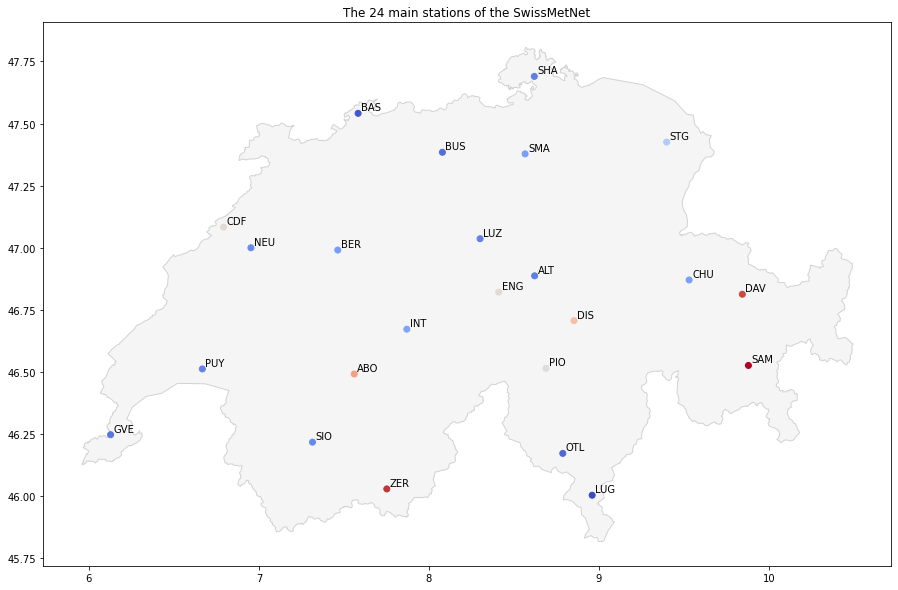

In [8]:
# Get the map of Switzerland
swiss_map = gpd.read_file(os.path.join('.', 'swiss-maps', 'switzerland.geojson')) # map from https://github.com/ZHB/switzerland-geojson/tree/master/country
# Plot the map
ax = swiss_map.plot(color='whitesmoke', edgecolor='lightgrey', figsize=(20, 10)) # Swiss border map
plt.scatter(df_stn_ok.longitude, df_stn_ok.latitude, c=df_stn_ok.altitude, cmap='coolwarm') # stations location
for x, y, label in zip(df_stn_ok.longitude, df_stn_ok.latitude, df_stn_ok.stn):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points") # stations name

plt.title('The 24 main stations of the SwissMetNet')
plt.show()

Later on the nearest geographical neighbour(s) of each station will be useful. So let's find the nearest three and compute their distance (the longitude/latitude is not relevant, the coordinates are more accurate).

In [9]:
geo_coord = df_stn_ok[['x_coord', 'y_coord']].values
nb_stn = len(geo_coord)

number_of_nn = 3 # number of recorded nearest neighbours
nn = []
nn_dist = []
for s in np.arange(nb_stn):
    s_x = geo_coord[s, 0]
    s_y = geo_coord[s, 1]
    dist_n = []
    for n in np.arange(nb_stn):
        dist_n.append((geo_coord[n, 0]-s_x)**2 + (geo_coord[n, 1]-s_y)**2) # compute the distance between s and n

    dist_n[s] = 10**12 # set an arbitrary high value instead of 0
    nn.append(list(np.argsort(dist_n)[:number_of_nn])) # get the index of the nns
    nn_dist.append(list(np.sort(dist_n)[:number_of_nn])) # get the distance of the nns

for i in np.arange(3):
    ind = [el[i] for el in nn] # indices of the i-th nns
    neigh_i = df_stn_ok.loc[ind, 'stn'].values # names of the i-th nns
    dist_i = [el[i] for el in nn_dist] # distances of the i-th nns
    df_stn_ok['neighbour_'+str(i)] = neigh_i
    df_stn_ok['neighbour_dist_'+str(i)] = dist_i

df_stn_ok

stn            station canton  altitude   latitude  longitude  lake  \
0   ABO          Adelboden     BE      1324  46.491733   7.560692     0   
1   ALT            Altdorf     UR       440  46.887042   8.621806     1   
2   BAS  Basel / Binningen     BL       318  47.541067   7.583556     0   
3   BER  Bern / Zollikofen     BE       555  46.990742   7.463997     0   
4   BUS      Buchs / Aarau     AG       389  47.384339   8.079461     0   
5   CHU               Chur     GR       558  46.870397   9.530583     0   
6   DAV              Davos     GR      1596  46.812956   9.843492     0   
7   DIS           Disentis     GR      1199  46.706525   8.853467     0   
8   ENG          Engelberg     OW      1037  46.821614   8.410450     0   
9   GVE  Genève / Cointrin     GE       413  46.247453   6.127722     1   
10  INT         Interlaken     BE       579  46.672231   7.870139     1   
11  CDF  La Chaux-de-Fonds     NE      1019  47.082944   6.792247     0   
12  OTL    Locarno / Monti     TI       369  46.172217   8.787486     1   
13  LUG             Lugano     TI       275  46.003833   8.960117     1   
14  LUZ             Luzern     LU       456  47.036417   8.300961     1   
15  NEU          Neuchatel     NE       486  46.999994   6.953106     1   
16  PIO             Piotta     TI       991  46.514775   8.688111     0   
17  PUY              Pully     VD       457  46.512278   6.667461     1   
18  SAM            Samedan     GR      1711  46.526244   9.879408     0   
19  SHA       Schaffhausen     SH       441  47.689803   8.620064     0   
20  SIO               Sion     VS       481  46.217492   7.315283     0   
21  STG         St. Gallen     SG       778  47.425456   9.398461     0   
22  ZER            Zermatt     VS      1641  46.029261   7.752397     0   
23  SMA  Zürich / Fluntern     ZH       558  47.377883   8.565733     0   

      x_coord    y_coord neighbour_0  neighbour_dist_0 neighbour_1  \
0   2609371.0  1148943.0         INT      9.651698e+08         SIO   
1   2690174.0  1193561.0         ENG      3.127193e+08         DIS   
2   2610911.0  1265604.0         BUS      1.701859e+09         BER   
3   2601929.0  1204409.0         NEU      1.511173e+09         INT   
4   2648390.0  1248365.0         SMA      1.348965e+09         BAS   
5   2759472.0  1193156.0         DAV      6.104964e+08         SAM   
6   2783514.0  1187457.0         CHU      6.104964e+08         SAM   
7   2708190.0  1173788.0         PIO      6.148432e+08         ALT   
8   2674157.0  1186066.0         ALT      3.127193e+08         LUZ   
9   2498903.0  1122624.0         PUY      2.591017e+09         SIO   
10  2633019.0  1169091.0         ABO      9.651698e+08         ENG   
11  2550914.0  1214862.0         NEU      2.344931e+08         BER   
12  2704166.0  1114311.0         LUG      5.286761e+08         PIO   
13  2717859.0  1095840.0         OTL      5.286761e+08         PIO   
14  2665540.0  1209847.0         ENG      6.397886e+08         ALT   
15  2563072.0  1205552.0         CDF      2.344931e+08         BER   
16  2695886.0  1152260.0         DIS      6.148432e+08         OTL   
17  2540815.0  1151510.0         GVE      2.591017e+09         NEU   
18  2787246.0  1155684.0         DAV      1.023451e+09         CHU   
19  2688698.0  1282799.0         SMA      1.219552e+09         BUS   
20  2590481.0  1118457.0         ABO      1.286228e+09         ZER   
21  2747861.0  1254585.0         CHU      3.908337e+09         SMA   
22  2624295.0  1097573.0         SIO      1.579528e+09         ABO   
23  2685117.0  1248061.0         SHA      1.219552e+09         BUS   

    neighbour_dist_1 neighbour_2  neighbour_dist_2  
0       1.286228e+09         ZER      2.861603e+09  
1       7.155478e+08         LUZ      8.720678e+08  
2       3.825504e+09         SMA      5.814287e+09  
3       2.213949e+09         CDF      2.711795e+09  
4       1.701859e+09         LUZ      1.777759e+09  
5       2.175546e+09         DIS      3.004963e+09  
6     

##### **B.1.3. Number and granularity of the features**

The main file contains 7 features corresponding to daily measurements, togheter with the station name and the day of the measurement, so 9 variables in total.

There are 7 years of daily measurments over 24 stations, so (7 x 365+2) x 24 = 61,368 samples.

Extra variables for the modelization will be created further.

##### **B.1.4. Quality of the data**

Data is of good quality. Some measurement are sometimes missing for a few dates and stations and some records are beginning later for some stations.

### C. Data processing and cleaning

#### **C.1. Data cleaning and data manipulation**

For convenience, we rename the variables

In [10]:
df.rename(columns={"gre000d0": "radiation", 
                   "p06stads": "pressure", 
                   "tre200d0": "temperature", 
                   "rre150d0": "precipitation", 
                   "ure200d0": "humidity", 
                   "sre000d0": "sunshine", 
                   "fkl010d0": "wind_speed"}, inplace=True)
df.head()

stn      time radiation pressure temperature precipitation humidity  \
0  ABO  20140101        66    865.2         0.5           0.0     65.0   
1  ABO  20140102        27    857.6         1.0           3.7     71.5   
2  ABO  20140103        44    862.2         3.1           2.2     61.6   
3  ABO  20140104        19    862.0         1.8           7.1     91.7   
4  ABO  20140105        67    858.1        -1.1           0.0     80.2   

  sunshine wind_speed  
0      286        1.2  
1       59        2.2  
2       54        2.1  
3        0        1.1  
4      262        1.6

In [11]:
df.dtypes

stn              object
time             object
radiation        object
pressure         object
temperature      object
precipitation    object
humidity         object
sunshine         object
wind_speed       object
dtype: object

All the variables are of dtype `object` and we want to convert them into `float` (except for `stn`). Note that the name of the variables (like a header) is repeted for each of the 24 stations (23 times plus the name of the DataFrame).

In [12]:
df.loc[df.temperature.str.contains('[A-Za-z]')==True] # check for entry in 'temperature' with letter(s)

stn  time radiation  pressure temperature precipitation  humidity  \
2557   stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
5115   stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
7673   stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
10231  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
12789  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
15347  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
17905  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
20463  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
23021  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
25579  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
28137  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
30695  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
33253  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
35811  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
38369  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
40927  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
43485  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
46043  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
48601  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
51159  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
53717  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
56275  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   
58833  stn  time  gre000d0  p06stads    tre200d0      rre150d0  ure200d0   

       sunshine wind_speed  
2557   sre000d0   fkl010d0  
5115   sre000d0   fkl010d0  
7673   sre000d0   fkl010d0  
10231  sre000d0   fkl010d0  
12789  sre000d0   fkl010d0  
15347  sre000d0   fkl010d0  
17905  fkl010d0   sre000d0  
20463  sre000d0   fkl010d0  
23021  sre000d0   fkl010d0  
25579  sre000d0   fkl010d0  
28137  sre000d0   fkl010d0  
30695  sre000d0   fkl010d0  
33253  sre000d0   fkl010d0  
35811  sre000d0   fkl010d0  
38369  sre000d0   fkl010d0  
40927  sre000d0   fkl010d0  
43485  sre000d0   fkl010d0  
46043  sre000d0   fkl010d0  
48601  sre000d0   fkl010d0  
51159  sre000d0   fkl010d0  
53717  sre000d0   fkl010d0  
56275  sre000d0   fkl010d0  
58833  sre000d0   fkl010d0

In [13]:
print(df.loc[df.temperature.str.contains('[A-Za-z]')==True].shape[0])

23


We drop it.

In [14]:
rows_to_clead = df.loc[df.temperature.str.contains('[A-Za-z]')==True].index
df.drop(rows_to_clead, axis=0, inplace=True)
df.loc[df.temperature.str.contains('[A-Za-z]')==True]

Empty DataFrame
Columns: [stn, time, radiation, pressure, temperature, precipitation, humidity, sunshine, wind_speed]
Index: []

Check for other non numeric entries

In [15]:
for c in df.columns:
    print('Number of non numeric entries in variable', c, ':', df.loc[df[c].str.contains('[A-Za-z]')==True].shape[0])

Number of non numeric entries in variable stn : 61368
Number of non numeric entries in variable time : 0
Number of non numeric entries in variable radiation : 0
Number of non numeric entries in variable pressure : 0
Number of non numeric entries in variable temperature : 0
Number of non numeric entries in variable precipitation : 0
Number of non numeric entries in variable humidity : 0
Number of non numeric entries in variable sunshine : 0
Number of non numeric entries in variable wind_speed : 0


Non-numeric entries cleaned. Converting is now possible.

In [16]:
# Converting to float is possible since non-numeric entries cleaned.
df.radiation = df.radiation.astype(np.float64, copy=False);
df.pressure = df.pressure.astype(np.float64, copy=False);
df.temperature = df.temperature.astype(np.float64, copy=False);
df.precipitation = df.precipitation.astype(np.float64, copy=False);
df.humidity = df.humidity.astype(np.float64, copy=False);
df.sunshine = df.sunshine.astype(np.float64, copy=False);
df.wind_speed = df.wind_speed.astype(np.float64, copy=False);

In [17]:
# Converting type of "time" variable into datetime 
time = pd.to_datetime(df.time)
df.time = time

Let's have a look to missing values.
First numerically ...

In [18]:
df.isnull().sum(axis=0)

stn                  0
time                 0
radiation         4256
pressure            32
temperature          0
precipitation       14
humidity             0
sunshine            68
wind_speed       14278
dtype: int64

In [19]:
for c in df.columns:
    pct_miss = df[c].isnull().sum(axis=0) / df.shape[0]
    print('Percentage of missing values in variable "{}" : {:.2%}'.format(c, pct_miss))

Percentage of missing values in variable "stn" : 0.00%
Percentage of missing values in variable "time" : 0.00%
Percentage of missing values in variable "radiation" : 6.94%
Percentage of missing values in variable "pressure" : 0.05%
Percentage of missing values in variable "temperature" : 0.00%
Percentage of missing values in variable "precipitation" : 0.02%
Percentage of missing values in variable "humidity" : 0.00%
Percentage of missing values in variable "sunshine" : 0.11%
Percentage of missing values in variable "wind_speed" : 23.27%


... Then graphically over time (missing values are represented in red (value set to 1).

In [20]:
from matplotlib.colors import ListedColormap
import seaborn as sns

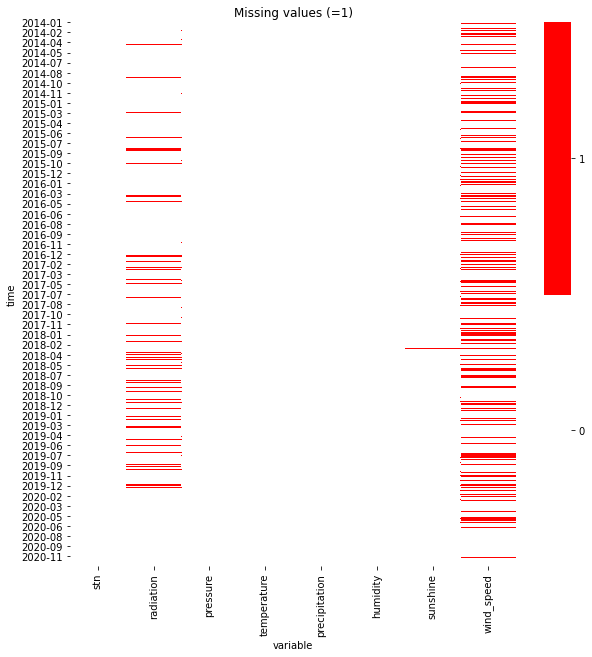

In [21]:
# Sort and format time
df_time_fmt = df.set_index('time').sort_values(by='time').copy()
df_time_fmt.index = pd.to_datetime(df_time_fmt.index, format = '%m/%d/%Y').strftime('%Y-%m')

# Plot the missing values
plt.figure(figsize=(10,10))
f = sns.heatmap(df_time_fmt.isnull(), cmap=ListedColormap(['white', 'red']))
colorbar = f.collections[0].colorbar
colorbar.set_ticks([.25, .75])
colorbar.set_ticklabels(['0', '1'])
f.set_xlabel('variable')
f.set_ylabel('time')
f.set_title('Missing values (=1)')

plt.show()

The variable `wind_speed` is missing for 23% observations *regularly* distributed over time. We decide to drop it.

In [22]:
df.drop('wind_speed', axis=1, inplace=True)

Let's investigate the other variables with missing observations, namely `radiation`, `pressure`, `precipitation` and `sunshine`. Let's first count the number of missing observations by station.

In [23]:
print('Total number of observations : {}.'.format(df.loc[df.stn=='ABO'].shape[0])) # Print the total number of rows.
var_miss = ['radiation', 'pressure', 'precipitation', 'sunshine']
var_miss_stn = ['stn'] + var_miss
df[var_miss_stn].groupby('stn', sort=False).count().rsub(df[var_miss_stn].groupby('stn', sort=False).size(), axis=0)

Total number of observations : 2557.


radiation  pressure  precipitation  sunshine
stn                                              
ABO          0         3              0         0
ALT          0         0              0         0
BAS          0         0              0         0
BER          0         0              0         0
BUS        818         0              0         0
CHU          0         2              0         0
DAV          0         0              0         0
DIS          0         2             14         0
ENG          0         0              0         0
GVE          0         1              0         0
INT       2283         5              0         0
CDF          0         0              0         0
OTL          0         0              0         0
LUG          0         0              0         0
LUZ          0         0              0         0
NEU          0         0              0         0
PIO       1140         0              0         0
PUY          0         1              0         0
SAM          0         0              0        11
SHA          0         1              0         0
SIO          0         0              0        12
STG         15         9              0        45
ZER          0         8              0         0
SMA          0         0              0         0

It seems relevent to remove the observations of stations `BUS`, `INT` and `PIO` since a large part of the 2,557 observations is missing for variable `radiation`. It is better to drop the data from these stations rather than the variable information since the records are complete for this variable in all the other stations except one.

In [24]:
stn_to_remove = ['BUS', 'INT', 'PIO']
df = df.loc[~df['stn'].isin(stn_to_remove)]
df.reset_index(inplace=True, drop=True)

In [25]:
df.loc[df['radiation'].isnull(), ['stn', 'time', 'radiation']]

stn       time  radiation
47580  STG 2018-04-04        NaN
47581  STG 2018-04-05        NaN
47582  STG 2018-04-06        NaN
47583  STG 2018-04-07        NaN
47584  STG 2018-04-08        NaN
47585  STG 2018-04-09        NaN
47586  STG 2018-04-10        NaN
47587  STG 2018-04-11        NaN
47588  STG 2018-04-12        NaN
47589  STG 2018-04-13        NaN
47590  STG 2018-04-14        NaN
47591  STG 2018-04-15        NaN
47592  STG 2018-04-16        NaN
47593  STG 2018-04-17        NaN
47594  STG 2018-04-18        NaN

The remaining missing values in variable 'radiation' concern only the station `STG` for some successive days. Let's fill these with the values of radiation of its geographically nearest neighbour. But first, let's remove stations `BUS`, `INT` and `PIO` from the DataFrame containing the stations informations, and update the nearest neighbours again.

In [26]:
df_stn_ok = df_stn_ok.loc[~df_stn_ok['stn'].isin(stn_to_remove + ['neighbour_0', 'neighbour_dist_0', 'neighbour_1', 'neighbour_dist_1', 'neighbour_2', 'neighbour_dist_2'])].copy()
df_stn_ok.reset_index(inplace=True, drop=True)

In [27]:
geo_coord = df_stn_ok[['x_coord', 'y_coord']].values
nb_stn = len(geo_coord)

number_of_nn = 3 # number of recorded nearest neighbours
nn = []
nn_dist = []
for s in np.arange(nb_stn):
    s_x = geo_coord[s, 0]
    s_y = geo_coord[s, 1]
    dist_n = []
    for n in np.arange(nb_stn):
        dist_n.append((geo_coord[n, 0]-s_x)**2 + (geo_coord[n, 1]-s_y)**2) # compute the distance between s and n

    dist_n[s] = 10**12 # set an arbitrary high value instead of 0
#     nn.append(np.argmin(dist_n)) # get the index of the nn
#     nn_dist.append(np.min(dist_n)) # get the distance of the nn
    nn.append(list(np.argsort(dist_n)[:number_of_nn])) # get the index of the nns
    nn_dist.append(list(np.sort(dist_n)[:number_of_nn])) # get the distance of the nns

for i in np.arange(3):
    ind = [el[i] for el in nn] # indices of the i-th nns
    neigh_i = df_stn_ok.loc[ind, 'stn'].values # names of the i-th nns
    dist_i = [el[i] for el in nn_dist] # distances of the i-th nns
    df_stn_ok['neighbour_'+str(i)] = neigh_i
    df_stn_ok['neighbour_dist_'+str(i)] = dist_i

df_stn_ok

stn            station canton  altitude   latitude  longitude  lake  \
0   ABO          Adelboden     BE      1324  46.491733   7.560692     0   
1   ALT            Altdorf     UR       440  46.887042   8.621806     1   
2   BAS  Basel / Binningen     BL       318  47.541067   7.583556     0   
3   BER  Bern / Zollikofen     BE       555  46.990742   7.463997     0   
4   CHU               Chur     GR       558  46.870397   9.530583     0   
5   DAV              Davos     GR      1596  46.812956   9.843492     0   
6   DIS           Disentis     GR      1199  46.706525   8.853467     0   
7   ENG          Engelberg     OW      1037  46.821614   8.410450     0   
8   GVE  Genève / Cointrin     GE       413  46.247453   6.127722     1   
9   CDF  La Chaux-de-Fonds     NE      1019  47.082944   6.792247     0   
10  OTL    Locarno / Monti     TI       369  46.172217   8.787486     1   
11  LUG             Lugano     TI       275  46.003833   8.960117     1   
12  LUZ             Luzern     LU       456  47.036417   8.300961     1   
13  NEU          Neuchatel     NE       486  46.999994   6.953106     1   
14  PUY              Pully     VD       457  46.512278   6.667461     1   
15  SAM            Samedan     GR      1711  46.526244   9.879408     0   
16  SHA       Schaffhausen     SH       441  47.689803   8.620064     0   
17  SIO               Sion     VS       481  46.217492   7.315283     0   
18  STG         St. Gallen     SG       778  47.425456   9.398461     0   
19  ZER            Zermatt     VS      1641  46.029261   7.752397     0   
20  SMA  Zürich / Fluntern     ZH       558  47.377883   8.565733     0   

      x_coord    y_coord neighbour_0  neighbour_dist_0 neighbour_1  \
0   2609371.0  1148943.0         SIO      1.286228e+09         ZER   
1   2690174.0  1193561.0         ENG      3.127193e+08         DIS   
2   2610911.0  1265604.0         BER      3.825504e+09         SMA   
3   2601929.0  1204409.0         NEU      1.511173e+09         CDF   
4   2759472.0  1193156.0         DAV      6.104964e+08         SAM   
5   2783514.0  1187457.0         CHU      6.104964e+08         SAM   
6   2708190.0  1173788.0         ALT      7.155478e+08         ENG   
7   2674157.0  1186066.0         ALT      3.127193e+08         LUZ   
8   2498903.0  1122624.0         PUY      2.591017e+09         SIO   
9   2550914.0  1214862.0         NEU      2.344931e+08         BER   
10  2704166.0  1114311.0         LUG      5.286761e+08         DIS   
11  2717859.0  1095840.0         OTL      5.286761e+08         DIS   
12  2665540.0  1209847.0         ENG      6.397886e+08         ALT   
13  2563072.0  1205552.0         CDF      2.344931e+08         BER   
14  2540815.0  1151510.0         GVE      2.591017e+09         NEU   
15  2787246.0  1155684.0         DAV      1.023451e+09         CHU   
16  2688698.0  1282799.0         SMA      1.219552e+09         STG   
17  2590481.0  1118457.0         ABO      1.286228e+09         ZER   
18  2747861.0  1254585.0         CHU      3.908337e+09         SMA   
19  2624295.0  1097573.0         SIO      1.579528e+09         ABO   
20  2685117.0  1248061.0         SHA      1.219552e+09         LUZ   

    neighbour_dist_1 neighbour_2  neighbour_dist_2  
0       2.861603e+09         BER      3.131861e+09  
1       7.155478e+08         LUZ      8.720678e+08  
2       5.814287e+09         NEU      5.894813e+09  
3       2.711795e+09         ABO      3.131861e+09  
4       2.175546e+09         DIS      3.004963e+09  
5       1.023451e+09         STG      5.777305e+09  
6       1.308994e+09         CHU      3.004963e+09  
7       6.397886e+08         DIS      1.308994e+09  
8       8.403894e+09         NEU      1.099471e+10  
9       2.711795e+09         PUY      4.115466e+09  
10      3.553706e+09         ENG      6.049320e+09  
11      6.169380e+09         SAM      8.395860e+09  
12      8.720678e+08         SMA      1.843569e+09  
13      1.511173e+09         PUY      3.415912e+09  
14      3.415912e

We can now fill the missing values for station `STG` with the values of radiation of its geographically nearest neighbour, namely Chur (`CHU`).

In [28]:
nn_STG = df_stn_ok.loc[df_stn_ok['stn']=='STG', 'neighbour_0'].iloc[0]
print("The nearest neighbour of 'STG' is '{}'.".format(nn_STG))

The nearest neighbour of 'STG' is 'CHU'.


In [29]:
time_to_fill_radiation = df.loc[df['radiation'].isnull(), 'time'] # Get the date of missing values
values_to_be_filled = df.loc[(df['stn']==nn_STG) & (df['time'].isin(time_to_fill_radiation)), 'radiation'].values.tolist() # Get the value to fill with
df.loc[df['radiation'].isnull(), 'radiation'] = values_to_be_filled # Fill the missing values with the previously computed values
df.loc[df['radiation'].isnull()] # no missing values remaining !

Empty DataFrame
Columns: [stn, time, radiation, pressure, temperature, precipitation, humidity, sunshine]
Index: []

Let's see where the variable `pressure` is missing.

In [30]:
df.loc[df['pressure'].isnull(), ['stn', 'time', 'pressure']]

stn       time  pressure
80     ABO 2014-03-22       NaN
81     ABO 2014-03-23       NaN
82     ABO 2014-03-24       NaN
10487  CHU 2014-09-17       NaN
10488  CHU 2014-09-18       NaN
15636  DIS 2014-10-22       NaN
15638  DIS 2014-10-24       NaN
22568  GVE 2019-10-14       NaN
36819  PUY 2016-10-18       NaN
42487  SHA 2018-04-25       NaN
46323  STG 2014-10-25       NaN
46324  STG 2014-10-26       NaN
46325  STG 2014-10-27       NaN
46326  STG 2014-10-28       NaN
46327  STG 2014-10-29       NaN
46328  STG 2014-10-30       NaN
46329  STG 2014-10-31       NaN
46330  STG 2014-11-01       NaN
46331  STG 2014-11-02       NaN
50055  ZER 2018-01-12       NaN
50056  ZER 2018-01-13       NaN
50057  ZER 2018-01-14       NaN
50058  ZER 2018-01-15       NaN
50059  ZER 2018-01-16       NaN
50595  ZER 2019-07-06       NaN
50596  ZER 2019-07-07       NaN
50597  ZER 2019-07-08       NaN

Fill the missing pressure measurement at D-day by the last non null value, let set it is at day D1, corrected by the mean over the other stations of the difference of pressure between D-day and D1. This way of imputing the pressure seems relevant since the measure at D-day highly depends on the pressure on the previous day.

In [31]:
# Define a function to fill a missing value with the previous non null + the mean of the difference in the other stations.
def fill_with_previous_notnull(var_name, df):
    # var_name: name of the variable to fill
    # df: dataframe to fill
    
    null_index = df.loc[df[var_name].isnull()].index
    for i in null_index: # Browse the index corresponding to missing values
        null_day = df.loc[i, 'time'] # Get the corresponding day
        k = i-1
        while k >= 0: # Go backwards to find a non-null value (namely the previous one)
#             if k not in null_index: # For not getting a filled value
            if ~np.isnan(df.loc[k, var_name]):
                not_null_day = df.loc[k, 'time'] # Get the day of the non-null value            
                df_tmp = df.loc[df['time']==null_day, var_name].reset_index(drop=True) - df.loc[df['time']==not_null_day, var_name].reset_index(drop=True) # compute the difference of var_name between null_day and non_null_day 
                df.loc[i, var_name] = df.loc[k, var_name] + df_tmp.mean(axis=0) # compute the mean of this difference over the other stations and add it to the value on non_null_day at the missing station
                print("Row {} corresponding to day {:%Y-%m-%d} for variable '{}' filled with {:.3f}".format(i, null_day, var_name, df.loc[i, var_name]))
                k=-1
            else:
                k -= 1

In [32]:
fill_with_previous_notnull('pressure', df)

Row 80 corresponding to day 2014-03-22 for variable 'pressure' filled with 859.490
Row 81 corresponding to day 2014-03-23 for variable 'pressure' filled with 855.480
Row 82 corresponding to day 2014-03-24 for variable 'pressure' filled with 859.875
Row 10487 corresponding to day 2014-09-17 for variable 'pressure' filled with 950.240
Row 10488 corresponding to day 2014-09-18 for variable 'pressure' filled with 949.665
Row 15636 corresponding to day 2014-10-22 for variable 'pressure' filled with 882.940
Row 15638 corresponding to day 2014-10-24 for variable 'pressure' filled with 882.595
Row 22568 corresponding to day 2019-10-14 for variable 'pressure' filled with 968.680
Row 36819 corresponding to day 2016-10-18 for variable 'pressure' filled with 968.960
Row 42487 corresponding to day 2018-04-25 for variable 'pressure' filled with 965.970
Row 46323 corresponding to day 2014-10-25 for variable 'pressure' filled with 930.635
Row 46324 corresponding to day 2014-10-26 for variable 'pressur

Let's see where the variable `precipitation` is missing.

In [33]:
df.loc[df['precipitation'].isnull(), ['stn', 'time', 'precipitation']]

stn       time  precipitation
16601  DIS 2017-06-13            NaN
16602  DIS 2017-06-14            NaN
16603  DIS 2017-06-15            NaN
16604  DIS 2017-06-16            NaN
16605  DIS 2017-06-17            NaN
16606  DIS 2017-06-18            NaN
16607  DIS 2017-06-19            NaN
16608  DIS 2017-06-20            NaN
16609  DIS 2017-06-21            NaN
16610  DIS 2017-06-22            NaN
16611  DIS 2017-06-23            NaN
16612  DIS 2017-06-24            NaN
16613  DIS 2017-06-25            NaN
16614  DIS 2017-06-26            NaN

It is only missing at station `DIS` (probably due to a technical problem) between '2017-06-13' and '2017-06-26'. We will not fill these missing values as before. Indeed, in contrast to pressure, precipitation does not seem as related to the previous day's measurement. Moreover, values are missing on a period of successive days, which makes the imputation tricky.

A way to fill these missing values is to get the geographically nearest neighbourg of `DIS` (Disentis) computed above, namely `ALT` (Altdorf), although they do not share other topographical characteristics (presence of a lake, altitude, ...).

In [34]:
nn_DIS = df_stn_ok.loc[df_stn_ok['stn']=='DIS', 'neighbour_0'].iloc[0]
print("The nearest neighbour of 'DIS' is '{}'.".format(nn_DIS))

The nearest neighbour of 'DIS' is 'ALT'.


In [35]:
time_to_fill_precipitation = df.loc[df['precipitation'].isnull(), 'time'] # Get the date of missing values
values_to_be_filled = df.loc[(df['stn']==nn_DIS) & (df['time'].isin(time_to_fill_precipitation)), 'precipitation'].values.tolist() # Get the value to fill with
df.loc[df['precipitation'].isnull(), 'precipitation'] = values_to_be_filled # Fill the missing values with the previously computed values
df.loc[df['precipitation'].isnull()] # no missing values remaining !

Empty DataFrame
Columns: [stn, time, radiation, pressure, temperature, precipitation, humidity, sunshine]
Index: []

Let's see where the variable `sunshine` is missing.

In [36]:
df.loc[df['sunshine'].isnull(), ['stn', 'time', 'sunshine']]

stn       time  sunshine
40276  SAM 2019-04-06       NaN
40277  SAM 2019-04-07       NaN
40278  SAM 2019-04-08       NaN
40279  SAM 2019-04-09       NaN
40280  SAM 2019-04-10       NaN
40281  SAM 2019-04-11       NaN
40282  SAM 2019-04-12       NaN
40283  SAM 2019-04-13       NaN
40284  SAM 2019-04-14       NaN
40285  SAM 2019-04-15       NaN
40286  SAM 2019-04-16       NaN
45599  SIO 2019-11-01       NaN
45600  SIO 2019-11-02       NaN
45601  SIO 2019-11-03       NaN
45602  SIO 2019-11-04       NaN
45603  SIO 2019-11-05       NaN
45604  SIO 2019-11-06       NaN
45605  SIO 2019-11-07       NaN
45606  SIO 2019-11-08       NaN
45607  SIO 2019-11-09       NaN
45608  SIO 2019-11-10       NaN
45609  SIO 2019-11-11       NaN
45610  SIO 2019-11-12       NaN
47545  STG 2018-02-28       NaN
47546  STG 2018-03-01       NaN
47547  STG 2018-03-02       NaN
47548  STG 2018-03-03       NaN
47549  STG 2018-03-04       NaN
47550  STG 2018-03-05       NaN
47551  STG 2018-03-06       NaN
...    ...        ...       ...
47560  STG 2018-03-15       NaN
47561  STG 2018-03-16       NaN
47562  STG 2018-03-17       NaN
47563  STG 2018-03-18       NaN
47564  STG 2018-03-19       NaN
47565  STG 2018-03-20       NaN
47566  STG 2018-03-21       NaN
47567  STG 2018-03-22       NaN
47568  STG 2018-03-23       NaN
47569  STG 2018-03-24       NaN
47570  STG 2018-03-25       NaN
47571  STG 2018-03-26       NaN
47572  STG 2018-03-27       NaN
47573  STG 2018-03-28       NaN
47574  STG 2018-03-29       NaN
47580  STG 2018-04-04       NaN
47581  STG 2018-04-05       NaN
47582  STG 2018-04-06       NaN
47583  STG 2018-04-07       NaN
47584  STG 2018-04-08       NaN
47585  STG 2018-04-09       NaN
47586  STG 2018-04-10       NaN
47587  STG 2018-04-11       NaN
47588  STG 2018-04-12       NaN
47589  STG 2018-04-13       NaN
47590  STG 2018-04-14       NaN
47591  STG 2018-04-15       NaN
47592  STG 2018-04-16       NaN
47593  STG 2018-04-17       NaN
47594  STG 2018-04-18       NaN

[68 rows x 3 columns]

As for the variable 'precipitation', the missing values concern a couple of stations for some successive days. Also, the nature of this variable (sunshine duration daily total) indicates that we can fill these with the geographically nearest neighbour:
- For `SAM` (Samedan) : `DAV` (Davos)
- For `SIO` (Sion) : `ZER` (Adelboden). The local topography is really different for these stations !
- For `STG` (Sankt-Gallen) : `CHU` (Chur).

In [37]:
nn_SAM = df_stn_ok.loc[df_stn_ok['stn']=='SAM', 'neighbour_0'].iloc[0]
print("The nearest neighbour of 'SAM' is '{}'.".format(nn_SAM))
nn_SIO = df_stn_ok.loc[df_stn_ok['stn']=='SIO', 'neighbour_0'].iloc[0]
print("The nearest neighbour of 'SIO' is '{}'.".format(nn_SIO))
nn_STG = df_stn_ok.loc[df_stn_ok['stn']=='STG', 'neighbour_0'].iloc[0]
print("The nearest neighbour of 'STG' is '{}'.".format(nn_STG))

The nearest neighbour of 'SAM' is 'DAV'.
The nearest neighbour of 'SIO' is 'ABO'.
The nearest neighbour of 'STG' is 'CHU'.


Note that local topography is really different in Sion and Adelboden !

In [38]:
stn_null_sunshine = ['SAM', 'SIO', 'STG'] # List of the station with missing values in 'sunshine'
dict_nn = {'SAM': nn_SAM, 'SIO': nn_SIO, 'STG': nn_STG} # dictionary giving the corresponding nn
for s in stn_null_sunshine:
    time_to_fill = df.loc[(df['sunshine'].isnull()) & (df['stn']==s), 'time'] # Get the date of missing values
    values_to_be_filled = df.loc[(df['stn']==dict_nn[s]) & (df['time'].isin(time_to_fill)), 'sunshine'].values.tolist() # Get the value to fill with
    df.loc[(df['sunshine'].isnull()) & (df['stn']==s), 'sunshine'] = values_to_be_filled # Fill the missing values with the previously computed values

In [39]:
df.isnull().sum(axis=0)

stn              0
time             0
radiation        0
pressure         0
temperature      0
precipitation    0
humidity         0
sunshine         0
dtype: int64

The way we proceed to fill deal with missing values keep the time series complete from 2014 to 2020. We can now compute basic statistcs.

In [40]:
df.drop(['stn', 'time'], axis=1).describe() # relevant since entries are of type numeric

radiation      pressure   temperature  precipitation      humidity  \
count  53697.000000  53697.000000  53697.000000   53697.000000  53697.000000   
mean     151.342794    929.884545      9.668967       2.991229     72.772820   
std       99.869865     50.442279      7.728248       7.501291     13.838383   
min        1.000000    790.000000    -20.400000       0.000000     14.900000   
25%       65.000000    892.700000      3.900000       0.000000     63.300000   
50%      134.000000    954.800000      9.600000       0.000000     74.100000   
75%      233.000000    967.600000     15.500000       2.300000     83.600000   
max      405.000000   1006.800000     29.600000     216.500000    100.000000   

           sunshine  
count  53697.000000  
mean     287.760491  
std      255.055040  
min        0.000000  
25%       20.000000  
50%      256.000000  
75%      494.000000  
max      922.000000

No outliers seem to be present and cleaned. A complementary graphical analysis will be performed later in part D.

#### **C.2. Feature engineering**

New variables can be computed from the present variables: lagged values (value the days/year before), mean of recent past values, month/season, duration of the day, ratio rain/humidity, ... . Some characteristics of the stations can also be taken into account as the altitude, presence of lake, ... (source https://www.meteoswiss.admin.ch/home/measurement-values.html?param=messwerte-lufttemperatur-10min&table=true).

In [41]:
 # add variables year, month and day
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day

# add variable season
df.loc[df['month'].isin([12, 1, 2]), 'season'] = 1 # meteorological winter
df.loc[df['month'].isin([3, 4, 5]), 'season'] = 2 # meteorological spring
df.loc[df['month'].isin([6, 7, 8]), 'season'] = 3 # meteorological summer
df.loc[df['month'].isin([9, 10, 11]), 'season'] = 4 # meteorological automn

# add variable quotient of precipitation by humidity
df['r_rain_humidity'] = df['precipitation'] / df['humidity'] # does not seem to be relevant later...

Remark : Other combinations of variables could have been computed, but none proved significantly. The ratio `r_rain_humidity` is kept here to indicate that adding combinations of variables has been considered in the feature engineering.

Compute lag temperatures for the last 7 days and for last year (temparature the same day, one year ago). Later on, year 2014 will only be used to compute lag, not for  training the models.

In [42]:
# add lag for the 7 last days

nb_daily_lag = 7

for i in np.arange(1, nb_daily_lag+1):
    lag = 't_'+np.str(i) # name of the lag
    df_lag = pd.DataFrame(columns=['stn', 'time']) # create empty DF to get the lag i
    for s in df['stn'].unique():
        lag_stn_time = df.loc[df.stn==s, 'time'] # get time for station s
        lag_stn_temp = df.loc[df.stn==s, 'temperature'].shift(periods=i) # get temperature lag i for station s
        lag_stn_temp.rename(lag, inplace=True) # rename lag in t_i
        lag_stn = pd.concat([lag_stn_time, lag_stn_temp], axis=1) # correspondance time - lag 
        lag_stn['stn'] = s # add the name
        df_lag = pd.concat([df_lag, lag_stn], sort=False) # concat data of station s to already computed stations. 'sort=False': To avoid a warning (index ok in our case)
        
    df = pd.merge(df, df_lag, on=['stn', 'time']) # merge the lag i temperature to already computed lag

df.head()

stn       time  radiation  pressure  temperature  precipitation  humidity  \
0  ABO 2014-01-01       66.0     865.2          0.5            0.0      65.0   
1  ABO 2014-01-02       27.0     857.6          1.0            3.7      71.5   
2  ABO 2014-01-03       44.0     862.2          3.1            2.2      61.6   
3  ABO 2014-01-04       19.0     862.0          1.8            7.1      91.7   
4  ABO 2014-01-05       67.0     858.1         -1.1            0.0      80.2   

   sunshine  year  month  day  season  r_rain_humidity  t_1  t_2  t_3  t_4  \
0     286.0  2014      1    1     1.0         0.000000  NaN  NaN  NaN  NaN   
1      59.0  2014      1    2     1.0         0.051748  0.5  NaN  NaN  NaN   
2      54.0  2014      1    3     1.0         0.035714  1.0  0.5  NaN  NaN   
3       0.0  2014      1    4     1.0         0.077426  3.1  1.0  0.5  NaN   
4     262.0  2014      1    5     1.0         0.000000  1.8  3.1  1.0  0.5   

   t_5  t_6  t_7  
0  NaN  NaN  NaN  
1  NaN  NaN  NaN  
2  NaN  NaN  NaN  
3  NaN  NaN  NaN  
4  NaN  NaN  NaN

In [43]:
# # add lag for the 7 last days
# nb_daily_lag = 7

# meas = ['temperature', 'humidity', 'precipitation', 'pressure', 'sunshine', 'radiation']
# meas_lag = ['hum_', 'preci_', 'press_', 'sun_', 'rad_']

# for v, v_lag in zip(meas, meas_lag):
#     for i in np.arange(1, nb_daily_lag+1):
#         lag = v_lag+np.str(i) # name of the lag
#         df_lag = pd.DataFrame(columns=['stn', 'time']) # create empty DF to get the lag i
#         for s in df['stn'].unique():
#             lag_stn_time = df.loc[df.stn==s, 'time'] # get time for station s
#             lag_stn_temp = df.loc[df.stn==s, v].shift(periods=i) # get temperature lag i for station s
#             lag_stn_temp.rename(lag, inplace=True) # rename lag in t_i
#             lag_stn = pd.concat([lag_stn_time, lag_stn_temp], axis=1) # correspondance time - lag 
#             lag_stn['stn'] = s # add the name
#             df_lag = pd.concat([df_lag, lag_stn], sort=False) # concat data of station s to already computed stations. 'sort=False': To avoid a warning (index ok in our case)

#         df = pd.merge(df, df_lag, on=['stn', 'time']) # merge the lag i temperature to already computed lag

# df.head()

<span style="color:red">
Modification compared with the original notebook: the lag "one year ago" is also computed for the other measurements in order to be able to compute seasonal adjustement for all the measurements.
</span>

In [44]:
# New for the adjusted version
meas = ['temperature', 'humidity', 'precipitation', 'pressure', 'sunshine', 'radiation']
meas_lag = ['t_', 'hum_', 'preci_', 'press_', 'sun_', 'rad_']

# add lag for the last n years (shift is not used here to lag date-to-date even in leap year)

y_i = 2014
y_f = 2020
nb_yearly_lag = 1
for v, v_lag in zip(meas, meas_lag):
    for i in 1+np.arange(nb_yearly_lag):
        lag = v_lag+'y'+np.str(i) # name of the lag
        df_lag_i = df.loc[df['time'].dt.year <= y_f-i, ['stn', 'time', v]].copy() # select year where the lag can be computed
        df_lag_i['time'] = df_lag_i['time'] + pd.DateOffset(years=i) # get temperature lag i for station s

        id_leap = df_lag_i.duplicated(subset=['stn', 'time']) # mark duplicates due to for leap year, 28-02 is duplicated (see e.g. 2017-02-28)
        df_lag_i = df_lag_i.loc[~id_leap].copy() # drop duplicates

        df_lag_i.rename(columns={v: lag}, inplace=True) # rename lag in ty_i
        df = pd.merge(df, df_lag_i, on=['stn', 'time'], how='left') # merge the lag i temperature to already computed lag
    
df.head()

stn       time  radiation  pressure  temperature  precipitation  humidity  \
0  ABO 2014-01-01       66.0     865.2          0.5            0.0      65.0   
1  ABO 2014-01-02       27.0     857.6          1.0            3.7      71.5   
2  ABO 2014-01-03       44.0     862.2          3.1            2.2      61.6   
3  ABO 2014-01-04       19.0     862.0          1.8            7.1      91.7   
4  ABO 2014-01-05       67.0     858.1         -1.1            0.0      80.2   

   sunshine  year  month  ...  t_4  t_5  t_6  t_7  t_y1  hum_y1  preci_y1  \
0     286.0  2014      1  ...  NaN  NaN  NaN  NaN   NaN     NaN       NaN   
1      59.0  2014      1  ...  NaN  NaN  NaN  NaN   NaN     NaN       NaN   
2      54.0  2014      1  ...  NaN  NaN  NaN  NaN   NaN     NaN       NaN   
3       0.0  2014      1  ...  NaN  NaN  NaN  NaN   NaN     NaN       NaN   
4     262.0  2014      1  ...  0.5  NaN  NaN  NaN   NaN     NaN       NaN   

   press_y1  sun_y1  rad_y1  
0       NaN     NaN     NaN  
1       NaN     NaN     NaN  
2       NaN     NaN     NaN  
3       NaN     NaN     NaN  
4       NaN     NaN     NaN  

[5 rows x 26 columns]

In [45]:
# New for the adjusted version
# Deal with t_y1 on day 02-29: impute the value on 02-28 one year ago
id_02_29 = df.loc[(df.month == 2) & (df.time.dt.day == 29)].index # id of 02-29
id_02_28_before_29 = id_02_29 - 1 # id of 02-28
for v_lag in meas_lag:
    v_y1_02_29 = df.loc[id_02_28_before_29, v_lag+'y1'] # t_y1 on 02-29
    df.loc[id_02_29, v_lag+'y1'] = v_y1_02_29.array

In [46]:
# add mean over previous week
# for v_lag in meas_lag:
#     df[v_lag+'mean7'] = (df[v_lag+'1']+df[v_lag+'2']+df[v_lag+'3']+df[v_lag+'4']+df[v_lag+'5']+df[v_lag+'6']+df[v_lag+'7'])/7

In [47]:
# add mean over previous week
df['t_mean7'] = (df['t_1']+df['t_2']+df['t_3']+df['t_4']+df['t_5']+df['t_6']+df['t_7'])/7

In [48]:
# Merge stations characteristics with data 
df_ok = pd.merge(df, df_stn_ok, on=['stn'])
df_ok.head()

stn       time  radiation  pressure  temperature  precipitation  humidity  \
0  ABO 2014-01-01       66.0     865.2          0.5            0.0      65.0   
1  ABO 2014-01-02       27.0     857.6          1.0            3.7      71.5   
2  ABO 2014-01-03       44.0     862.2          3.1            2.2      61.6   
3  ABO 2014-01-04       19.0     862.0          1.8            7.1      91.7   
4  ABO 2014-01-05       67.0     858.1         -1.1            0.0      80.2   

   sunshine  year  month  ...  longitude  lake    x_coord    y_coord  \
0     286.0  2014      1  ...   7.560692     0  2609371.0  1148943.0   
1      59.0  2014      1  ...   7.560692     0  2609371.0  1148943.0   
2      54.0  2014      1  ...   7.560692     0  2609371.0  1148943.0   
3       0.0  2014      1  ...   7.560692     0  2609371.0  1148943.0   
4     262.0  2014      1  ...   7.560692     0  2609371.0  1148943.0   

   neighbour_0  neighbour_dist_0  neighbour_1  neighbour_dist_1  neighbour_2  \
0          SIO      1.286228e+09          ZER      2.861603e+09          BER   
1          SIO      1.286228e+09          ZER      2.861603e+09          BER   
2          SIO      1.286228e+09          ZER      2.861603e+09          BER   
3          SIO      1.286228e+09          ZER      2.861603e+09          BER   
4          SIO      1.286228e+09          ZER      2.861603e+09          BER   

   neighbour_dist_2  
0      3.131861e+09  
1      3.131861e+09  
2      3.131861e+09  
3      3.131861e+09  
4      3.131861e+09  

[5 rows x 41 columns]

In [49]:
# add lag for the 7 last days

# nb_daily_lag = 7

# for i in np.arange(1, nb_daily_lag+1):
#     lag = 't_'+np.str(i) # name of the lag
#     df_lag = pd.DataFrame(columns=['stn', 'time']) # create empty DF to get the lag i
#     for s in df['stn'].unique():
#         lag_stn_time = df.loc[df.stn==s, 'time'] # get time for station s
#         lag_stn_temp = df.loc[df.stn==s, 'temperature'].shift(periods=i) # get temperature lag i for station s
#         lag_stn_temp.rename(lag, inplace=True) # rename lag in t_i
#         lag_stn = pd.concat([lag_stn_time, lag_stn_temp], axis=1) # correspondance time - lag 
#         lag_stn['stn'] = s # add the name
#         df_lag = pd.concat([df_lag, lag_stn], sort=False) # concat data of station s to already computed stations. 'sort=False': To avoid a warning (index ok in our case)
        
#     df = pd.merge(df, df_lag, on=['stn', 'time']) # merge the lag i temperature to already computed lag

# df.head()

In [50]:
# # add lag for the last n years (shift is not used here to lag date-to-date even in leap year)

# y_i = 2014
# y_f = 2020
# nb_yearly_lag = 1

# for i in 1+np.arange(nb_yearly_lag):
#     lag = 't_y'+np.str(i) # name of the lag
#     df_lag_i = df.loc[df['time'].dt.year <= y_f-i, ['stn', 'time', 'temperature']].copy() # select year where the lag can be computed
#     df_lag_i['time'] = df_lag_i['time'] + pd.DateOffset(years=i) # get temperature lag i for station s
    
#     id_leap = df_lag_i.duplicated(subset=['stn', 'time']) # mark duplicates due to for leap year, 28-02 is duplicated (see e.g. 2017-02-28)
#     df_lag_i = df_lag_i.loc[~id_leap].copy() # drop duplicates

#     df_lag_i.rename(columns={'temperature': lag}, inplace=True) # rename lag in ty_i
#     df = pd.merge(df, df_lag_i, on=['stn', 'time'], how='left') # merge the lag i temperature to already computed lag
    
# df.head()

In [51]:
# # Deal with t_y1 on day 02-29: impute the value on 02-28 one year ago
# id_02_29 = df.loc[(df.month == 2) & (df.time.dt.day == 29)].index # id of 02-29
# id_02_28_before_29 = id_02_29 - 1 # id of 02-28
# t_y1_02_29 = df.loc[id_02_28_before_29, 't_y1'] # t_y1 on 02-29
# df.loc[id_02_29, 't_y1'] = t_y1_02_29.array

In [52]:
# # add mean over previous week
# df['t_mean7'] = (df['t_1']+df['t_2']+df['t_3']+df['t_4']+df['t_5']+df['t_6']+df['t_7'])/7

In [53]:
# # Merge stations characteristics with data 
# df_ok = pd.merge(df, df_stn_ok, on=['stn'])
# df_ok.head()

### D. Exploratory data analysis (EDA)

#### **D.1. Preliminary EDA**

##### **D.1.1 Descriptive statistics and seasonal adjustment**

Descriptive statistics can be performed as at the end of point C.1. also for the added variables (when relevant):

In [54]:
df_ok.drop(['stn', 'time', 'year', 'month', 'day', 'season', 't_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_y1'], axis=1).describe() # relevant since entries are of type numeric

radiation      pressure   temperature  precipitation      humidity  \
count  53697.000000  53697.000000  53697.000000   53697.000000  53697.000000   
mean     151.342794    929.884545      9.668967       2.991229     72.772820   
std       99.869865     50.442279      7.728248       7.501291     13.838383   
min        1.000000    790.000000    -20.400000       0.000000     14.900000   
25%       65.000000    892.700000      3.900000       0.000000     63.300000   
50%      134.000000    954.800000      9.600000       0.000000     74.100000   
75%      233.000000    967.600000     15.500000       2.300000     83.600000   
max      405.000000   1006.800000     29.600000     216.500000    100.000000   

           sunshine  r_rain_humidity        hum_y1      preci_y1  \
count  53697.000000     53697.000000  46032.000000  46032.000000   
mean     287.760491         0.036625     72.943498      3.007373   
std      255.055040         0.089424     13.785911      7.417729   
min        0.000000         0.000000     14.900000      0.000000   
25%       20.000000         0.000000     63.600000      0.000000   
50%      256.000000         0.000000     74.200000      0.000000   
75%      494.000000         0.029448     83.700000      2.400000   
max      922.000000         2.599040    100.000000    216.500000   

           press_y1  ...       t_mean7      altitude      latitude  \
count  46032.000000  ...  53550.000000  53697.000000  53697.000000   
mean     929.811399  ...      9.694099    767.238095     46.783017   
std       50.439303  ...      7.397862    457.852430      0.478776   
min      790.000000  ...    -16.857143    275.000000     46.003833   
25%      892.600000  ...      4.042857    441.000000     46.491733   
50%      954.700000  ...      9.457143    555.000000     46.821614   
75%      967.500000  ...     15.428571   1037.000000     47.036417   
max     1004.900000  ...     28.057143   1711.000000     47.689803   

          longitude          lake       x_coord       y_coord  \
count  53697.000000  53697.000000  5.369700e+04  5.369700e+04   
mean       8.189928      0.333333  2.657271e+06  1.182128e+06   
std        1.049084      0.471409  8.018707e+04  5.321966e+04   
min        6.127722      0.000000  2.498903e+06  1.095840e+06   
25%        7.463997      0.000000  2.601929e+06  1.148943e+06   
50%        8.410450      0.000000  2.674157e+06  1.187457e+06   
75%        8.853467      1.000000  2.708190e+06  1.209847e+06   
max        9.879408      1.000000  2.787246e+06  1.282799e+06   

       neighbour_dist_0  neighbour_dist_1  neighbour_dist_2  
count      5.369700e+04      5.369700e+04      5.369700e+04  
mean       1.274747e+09      2.886898e+09      4.497506e+09  
std        1.065763e+09      1.942488e+09      2.372218e+09  
min        2.344931e+08      6.397886e+08      8.720678e+08  
25%        5.286761e+08      1.511173e+09      3.004963e+09  
50%        1.023451e+09      2.711795e+09      3.559212e+09  
75%        1.511173e+09      3.553706e+09      5.894813e+09  
max        3.908337e+09      8.403894e+09      1.099471e+10  

[8 rows x 22 columns]

A quick big picture can be made through histograms.

C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plot

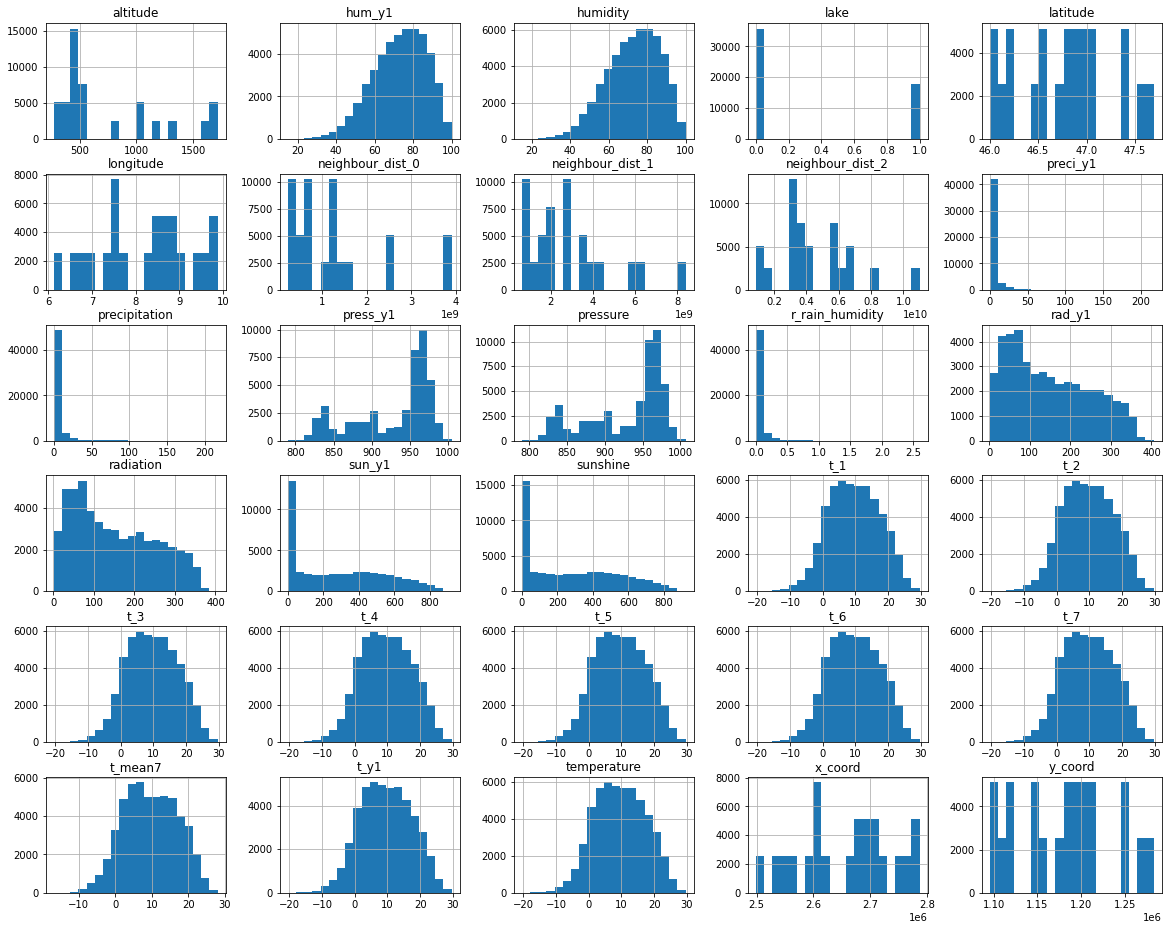

In [55]:
df_ok.drop(['stn', 'time', 'year', 'month', 'day', 'season'], axis=1).hist(figsize=(20,16), bins=20);

Analysis of the skewness in the original features.

In [56]:
# Analysis of the skewness (after 0 removal)
from scipy.stats import skew

orig_feat = ['radiation', 'pressure', 'temperature', 'precipitation', 'humidity', 'sunshine']

for c in orig_feat:
    s = skew(df_ok.loc[df_ok[c]!=0, c].dropna())
    print('Skewness of variable', c, ': {0:.2f}'.format(s))

Skewness of variable radiation : 0.41
Skewness of variable pressure : -0.86
Skewness of variable temperature : -0.05
Skewness of variable precipitation : 4.09
Skewness of variable humidity : -0.46
Skewness of variable sunshine : 0.24


Only the variable precipitaion is really skewed (after zeros removal). Let's apply a log-transform to it to remove skewness.

In [57]:
df_ok.loc[:, 'precipitation'] = np.log1p(df_ok['precipitation'])
print("Skewness of the log-transformed variable 'precipitation' : {0:.2f}".format(skew(df_ok.loc[df_ok['precipitation']!=0, 'precipitation'].dropna())))

Skewness of the log-transformed variable 'precipitation' : 0.35


As suggested in the additionnal notebook of [Unit 04.02.05](https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v2/subjects/k-nearest-neighbors-v2/units/standardization-and-k-nn-v2) called *Standardization and k-NN*, the trend, saisonality and variance's evolution ot the time serie must be analyzed.

<span style="color:red">
Modification compared with the original notebook: Let's plot the measurements in Neuchatel (not only the temperature).
</span>

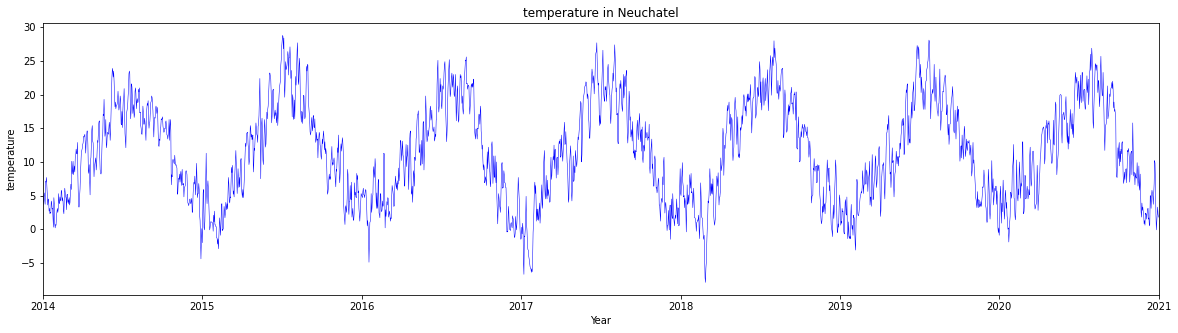

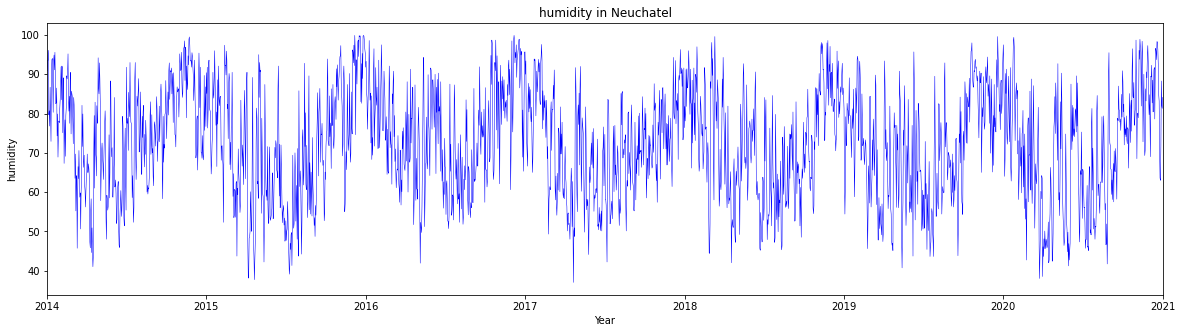

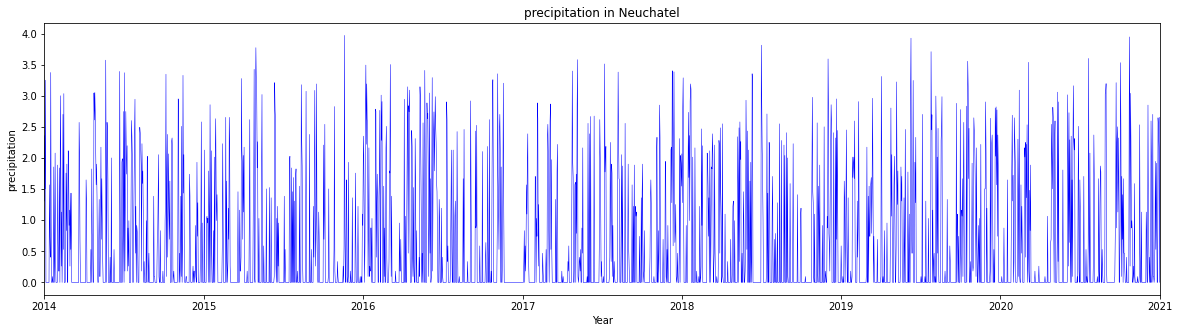

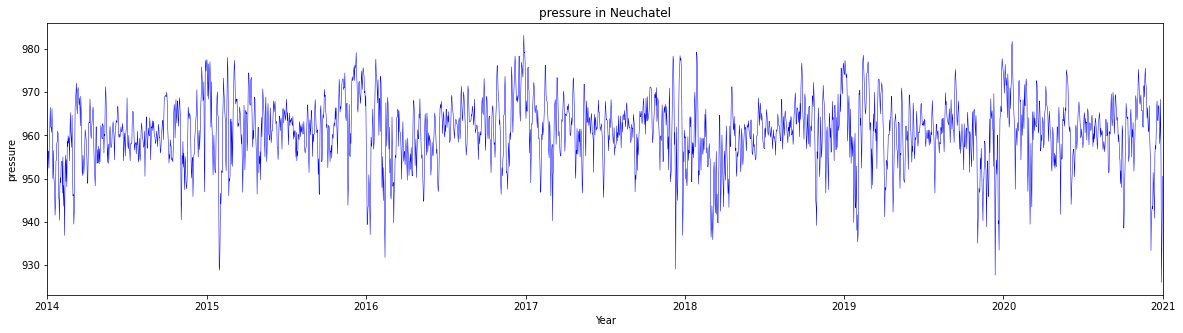

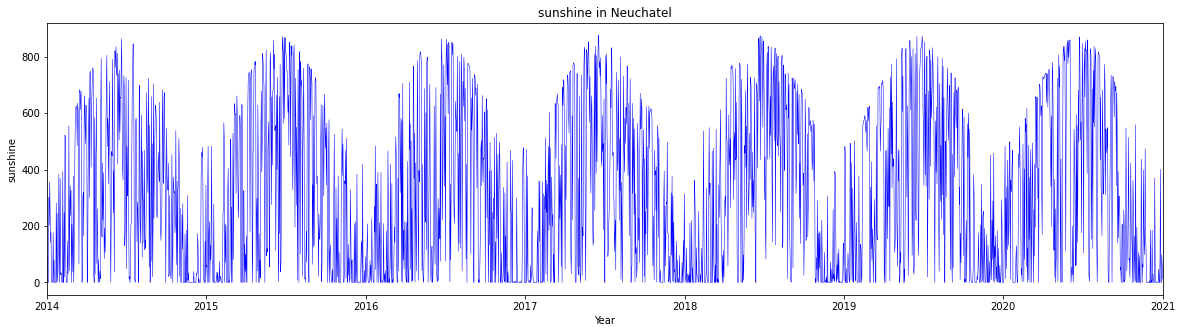

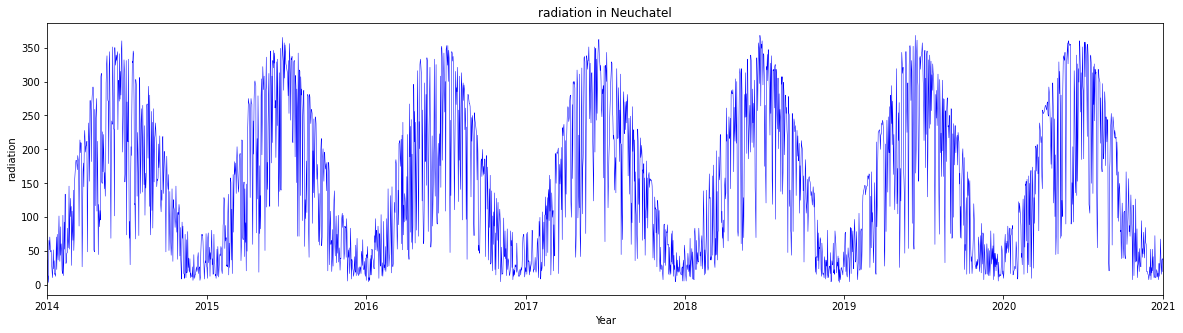

In [58]:
# New for the adjusted version
meas = ['temperature', 'humidity', 'precipitation', 'pressure', 'sunshine', 'radiation']
meas_adj = ['t_', 'hum_', 'preci_', 'press_', 'sun_', 'rad_']

# Plot the seasanal adjusted temperature
for v in meas:
    
    fig, ax = plt.subplots(figsize=(20,5))
    
    dates = matplotlib.dates.date2num(df_ok.loc[df_ok['stn']=='NEU', ['time']])
    values = df_ok.loc[df_ok['stn']=='NEU', v]
    plt.plot_date(dates, values, 'b-', linewidth=0.5)

    ax.set_xlim(xmin="2014-01-01", xmax="2021-01-01")

    plt.xlabel('Year')
    plt.ylabel(v)
    plt.title(v + ' in Neuchatel')

    plt.show()

<span style="color:red">
Modification compared with the original notebook: The other measurements are also seasonal adjusted.
</span>

In [59]:
# Define a function to adjust a series t by substracting a moving average over a couple of values of t_y1.
def seas_adj(t_serie, nb_rolling):
    # t_serie : Time serie to be seasonal adjusted
    # nb_rolling : number of lag in the rolling mean
    
    lags = pd.DataFrame()
    for l in np.arange(nb_rolling):
        to_add = t_serie.shift(periods=l) # compute lag
        to_add.rename('lag_'+np.str(l), inplace=True) # name of the lag
        lags = pd.concat([lags, to_add], axis=1)

    
    roll_mean = lags.mean(axis=1) # compute mean
    roll_mean.rename('mean_'+np.str(nb_rolling), inplace=True) # name of the mean
    lags = pd.concat([lags, roll_mean], axis=1)
    return lags    

Let's adjust the temperature serie by substracting a moving average over 7 days one year ago. Let's do it for each station.

In [60]:
# New for the adjusted version
nb_roll_mean = 7

for v, v_adj in zip(meas, meas_adj):
    series_adj = pd.Series([])
    
    for s in df_ok.stn.unique():
        rolling_mean = seas_adj(df_ok.loc[df_ok['stn']==s, v_adj+'y1'], nb_roll_mean)
        deseas_values = df_ok.loc[df_ok['stn']==s, v] - rolling_mean['mean_'+np.str(nb_roll_mean)]
        series_adj = series_adj.append(deseas_values)
        
    df_ok[v_adj+'adj'] = series_adj
# old version : substracting the value the same day one year ago (correspondng to seas_adj(df_ok.t_y1, 1)
# deseas_values = df_ok.loc[df_ok['stn']=='NEU', 'temperature'] - df_ok.loc[df_ok['stn']=='NEU', 't_y1']

<span style="color:red">
Modification compared with the original notebook: The lags `t_1`, ..., `t_7` are computed again from `t_adj` to obtain adjusted lags. The same is done for 't_mean7', the mean over previous week.
</span>

In [61]:
# New for the adjusted version
df_ok.drop(['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7'], axis=1, inplace=True)

# add lag for the 7 last days

nb_daily_lag = 7

for i in np.arange(1, nb_daily_lag+1):
    lag = 't_'+np.str(i) # name of the lag
    df_lag = pd.DataFrame(columns=['stn', 'time']) # create empty DF to get the lag i
    for s in df['stn'].unique():
        lag_stn_time = df_ok.loc[df_ok.stn==s, 'time'] # get time for station s
        lag_stn_temp = df_ok.loc[df.stn==s, 't_adj'].shift(periods=i) # get temperature lag i for station s
        lag_stn_temp.rename(lag, inplace=True) # rename lag in t_i
        lag_stn = pd.concat([lag_stn_time, lag_stn_temp], axis=1) # correspondance time - lag 
        lag_stn['stn'] = s # add the name
        df_lag = pd.concat([df_lag, lag_stn], sort=False) # concat data of station s to already computed stations. 'sort=False': To avoid a warning (index ok in our case)
        
    df_ok = pd.merge(df_ok, df_lag, on=['stn', 'time']) # merge the lag i temperature to already computed lag

df_ok.head()

stn       time  radiation  pressure  temperature  precipitation  humidity  \
0  ABO 2014-01-01       66.0     865.2          0.5       0.000000      65.0   
1  ABO 2014-01-02       27.0     857.6          1.0       1.547563      71.5   
2  ABO 2014-01-03       44.0     862.2          3.1       1.163151      61.6   
3  ABO 2014-01-04       19.0     862.0          1.8       2.091864      91.7   
4  ABO 2014-01-05       67.0     858.1         -1.1       0.000000      80.2   

   sunshine  year  month  ...  press_adj  sun_adj  rad_adj  t_1  t_2  t_3  \
0     286.0  2014      1  ...        NaN      NaN      NaN  NaN  NaN  NaN   
1      59.0  2014      1  ...        NaN      NaN      NaN  NaN  NaN  NaN   
2      54.0  2014      1  ...        NaN      NaN      NaN  NaN  NaN  NaN   
3       0.0  2014      1  ...        NaN      NaN      NaN  NaN  NaN  NaN   
4     262.0  2014      1  ...        NaN      NaN      NaN  NaN  NaN  NaN   

   t_4  t_5  t_6  t_7  
0  NaN  NaN  NaN  NaN  
1  NaN  NaN  NaN  NaN  
2  NaN  NaN  NaN  NaN  
3  NaN  NaN  NaN  NaN  
4  NaN  NaN  NaN  NaN  

[5 rows x 47 columns]

In [62]:
# New for the adjusted version
# add mean over previous week
df_ok.drop(['t_mean7'], axis=1, inplace=True)
df_ok['t_mean7'] = (df_ok['t_1']+df_ok['t_2']+df_ok['t_3']+df_ok['t_4']+df_ok['t_5']+df_ok['t_6']+df_ok['t_7'])/7

<span style="color:red">
Modification compared with the original notebook: The lag `t_y1` is computed again from `t_adj` to obtain adjusted lags.

In [63]:
# New for the adjusted version
# add lag for the last n years (shift is not used here to lag date-to-date even in leap year)
df_ok.drop(['t_y1'], axis=1, inplace=True)

y_i = 2015
y_f = 2020
nb_yearly_lag = 1

for i in 1+np.arange(nb_yearly_lag):
    lag = 't_y'+np.str(i) # name of the lag
    df_ok_lag_i = df_ok.loc[df_ok['time'].dt.year <= y_f-i, ['stn', 'time', 't_adj']].copy() # select year where the lag can be computed
    df_ok_lag_i['time'] = df_ok_lag_i['time'] + pd.DateOffset(years=i) # get temperature lag i for station s
    
    id_leap = df_ok_lag_i.duplicated(subset=['stn', 'time']) # mark duplicates due to for leap year, 28-02 is duplicated (see e.g. 2017-02-28)
    df_ok_lag_i = df_ok_lag_i.loc[~id_leap].copy() # drop duplicates

    df_ok_lag_i.rename(columns={'t_adj': lag}, inplace=True) # rename lag in ty_i
    df_ok = pd.merge(df_ok, df_ok_lag_i, on=['stn', 'time'], how='left') # merge the lag i temperature to already computed lag
    
df_ok.head()

stn       time  radiation  pressure  temperature  precipitation  humidity  \
0  ABO 2014-01-01       66.0     865.2          0.5       0.000000      65.0   
1  ABO 2014-01-02       27.0     857.6          1.0       1.547563      71.5   
2  ABO 2014-01-03       44.0     862.2          3.1       1.163151      61.6   
3  ABO 2014-01-04       19.0     862.0          1.8       2.091864      91.7   
4  ABO 2014-01-05       67.0     858.1         -1.1       0.000000      80.2   

   sunshine  year  month  ...  rad_adj  t_1  t_2  t_3  t_4  t_5  t_6  t_7  \
0     286.0  2014      1  ...      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1      59.0  2014      1  ...      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2      54.0  2014      1  ...      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3       0.0  2014      1  ...      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4     262.0  2014      1  ...      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

  t_mean7 t_y1  
0     NaN  NaN  
1     NaN  NaN  
2     NaN  NaN  
3     NaN  NaN  
4     NaN  NaN  

[5 rows x 47 columns]

In [64]:
# New for the adjusted version
# Deal with t_y1 on day 02-29: impute the value on 02-28 one year ago
id_02_29 = df_ok.loc[(df.month == 2) & (df_ok.time.dt.day == 29)].index # id of 02-29
id_02_28_before_29 = id_02_29 - 1 # id of 02-28
t_y1_02_29 = df_ok.loc[id_02_28_before_29, 't_y1'] # t_y1 on 02-29
df_ok.loc[id_02_29, 't_y1'] = t_y1_02_29.array

<span style="color:red">
Modification compared with the original notebook: Let's plot the adjusted measurements in Neuchatel (not only the temperature).
</span>

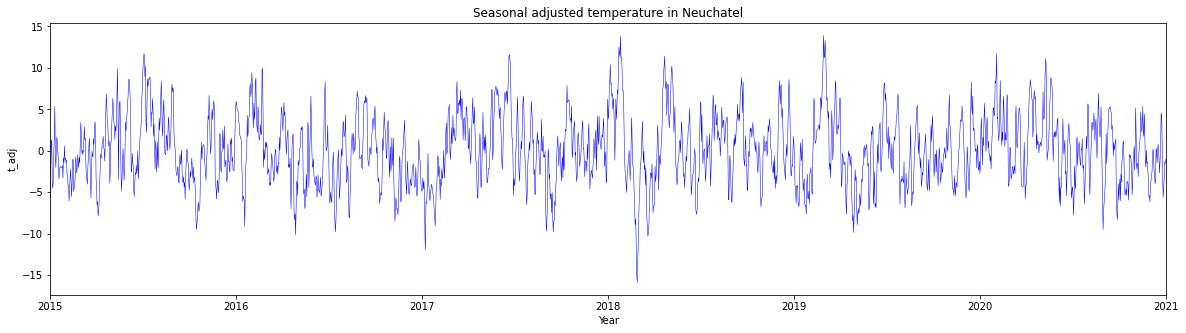

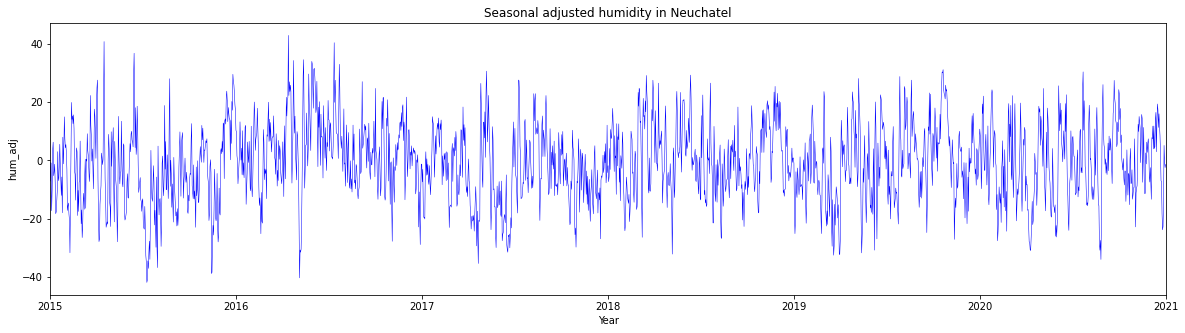

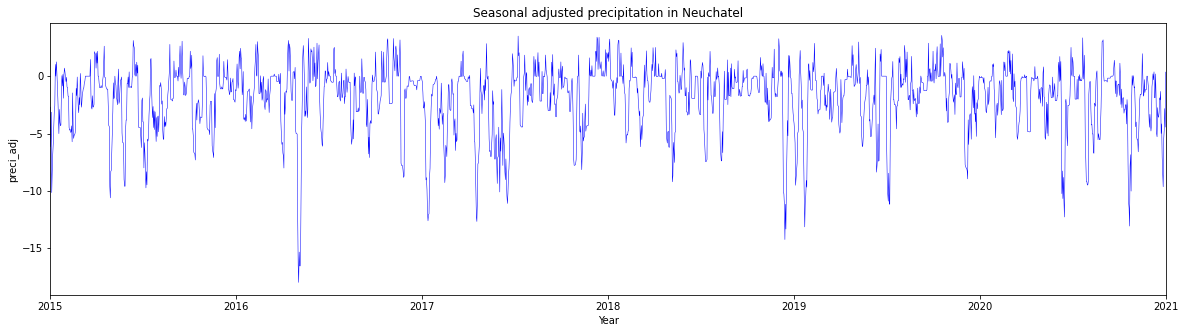

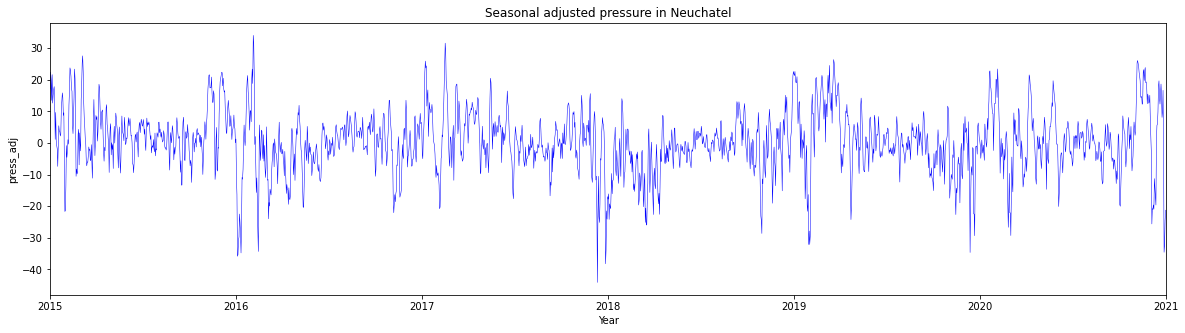

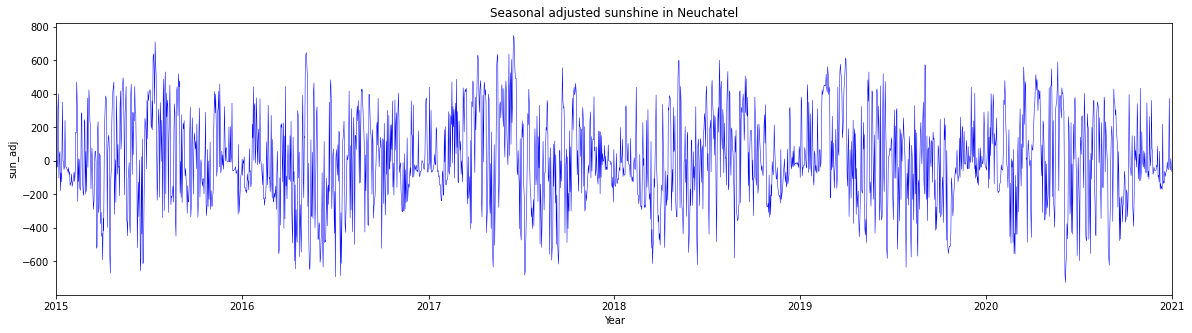

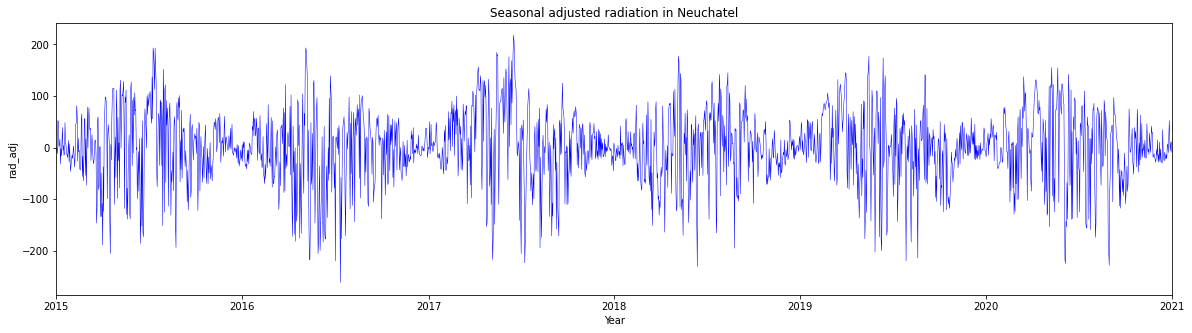

In [65]:
# New for the adjusted version
# Plot the seasanal adjusted temperature
for v, v_adj in zip(meas, meas_adj):
    
    fig, ax = plt.subplots(figsize=(20,5))

    plt.plot_date(dates, df_ok.loc[df_ok['stn']=='NEU', v_adj+'adj'] , 'b-', linewidth=0.5)
    # plt.plot(df_ok.loc[df_ok['stn']=='NEU', ['temperature']])

    ax.set_xlim(xmin="2015-01-01", xmax="2021-01-01")

    plt.xlabel('Year')
    plt.ylabel(v_adj+'adj')
    plt.title('Seasonal adjusted ' + v + ' in Neuchatel')

    plt.show()

<span style="color:red">
The variance is not always stationary. We could also have stabilize it by applying a logarithm transformation to the measurements (espacially for pressure, sunshine and radiation).
</span>

In order to work with a complete DataFrame for station Neuchatel, let's add (vertically) to the observations (=rows) about station `NEU` the measurements (temperature, radiation, pressure, precipitation, humidity and sunshine) the same days in all the other stations.

In [66]:
# New for the adjusted version
df_NEU = df_ok.loc[df_ok['stn']=='NEU']
for s in df_ok['stn'].unique():
    if s != 'NEU':
        var_temp = 't_'+np.str(s) # name of the temperature in station s
        var_radiation = 'rad_'+np.str(s) # name of the radiation in station s
        var_pressure = 'press_'+np.str(s) # name of the pressure in station s
        var_precipitation = 'preci_'+np.str(s) # name of the precipitation in station s
        var_humidity = 'hum_'+np.str(s) # name of the humidity in station s
        var_sunshine = 'sun_'+np.str(s) # name of the sunshine in station s
        var_altitude = 'alt_'+np.str(s) # name of the altitude in station s
        var_longitude = 'long_'+np.str(s) # name of the longitude in station s
        var_latitude = 'lat_'+np.str(s) # name of the latitude in station s
        var_lake = 'lake_'+np.str(s) # name of the presence of a lake in station s
        df_to_add = df_ok.loc[df_ok['stn']==s, ['time', 't_adj', 'rad_adj', 'press_adj', 'preci_adj', 'hum_adj', 'sun_adj', 'altitude', 'longitude', 'latitude', 'lake']] # keep the lag also ???????????????????????????????????
        df_to_add.rename(columns={'t_adj': var_temp, # t_adj instead of the original temperature
                                  'rad_adj': var_radiation,
                                  'press_adj': var_pressure,
                                  'preci_adj': var_precipitation,
                                  'hum_adj': var_humidity,
                                  'sun_adj': var_sunshine,
                                  'altitude': var_altitude,
                                  'longitude': var_longitude,
                                  'latitude': var_latitude,
                                  'lake': var_lake}, inplace=True)
        df_to_add.drop_duplicates(subset=['time'],inplace=True)
        df_NEU = pd.merge(df_NEU, df_to_add, on=['time'], how='left') # merge the lag i temperature to already computed lag

print(df_NEU.shape)
df_NEU.head()   

(2557, 247)


stn       time  radiation  pressure  temperature  precipitation  humidity  \
0  NEU 2014-01-01       37.0     959.8          3.6       1.308333      90.9   
1  NEU 2014-01-02       15.0     950.6          4.4       2.360854      93.5   
2  NEU 2014-01-03       13.0     956.4          4.9       1.504077      93.5   
3  NEU 2014-01-04        4.0     955.7          5.4       3.250374      96.1   
4  NEU 2014-01-05       66.0     952.4          4.4       0.000000      79.7   

   sunshine  year  month  ...  t_SMA  rad_SMA  press_SMA  preci_SMA  hum_SMA  \
0      97.0  2014      1  ...    NaN      NaN        NaN        NaN      NaN   
1      13.0  2014      1  ...    NaN      NaN        NaN        NaN      NaN   
2       0.0  2014      1  ...    NaN      NaN        NaN        NaN      NaN   
3       0.0  2014      1  ...    NaN      NaN        NaN        NaN      NaN   
4     302.0  2014      1  ...    NaN      NaN        NaN        NaN      NaN   

   sun_SMA  alt_SMA  long_SMA    lat_SMA lake_SMA  
0      NaN      558  8.565733  47.377883        0  
1      NaN      558  8.565733  47.377883        0  
2      NaN      558  8.565733  47.377883        0  
3      NaN      558  8.565733  47.377883        0  
4      NaN      558  8.565733  47.377883        0  

[5 rows x 247 columns]

Some variables (e.g. 'canton') take only a single value. They do not add any information and can be dropped.

In [67]:
col_unique_value = df_NEU.nunique()[df_NEU.nunique()==1].index
col_unique_value

Index(['stn', 'station', 'canton', 'altitude', 'latitude', 'longitude', 'lake',
       'x_coord', 'y_coord', 'neighbour_0', 'neighbour_dist_0', 'neighbour_1',
       'neighbour_dist_1', 'neighbour_2', 'neighbour_dist_2', 'alt_ABO',
       'long_ABO', 'lat_ABO', 'lake_ABO', 'alt_ALT', 'long_ALT', 'lat_ALT',
       'lake_ALT', 'alt_BAS', 'long_BAS', 'lat_BAS', 'lake_BAS', 'alt_BER',
       'long_BER', 'lat_BER', 'lake_BER', 'alt_CHU', 'long_CHU', 'lat_CHU',
       'lake_CHU', 'alt_DAV', 'long_DAV', 'lat_DAV', 'lake_DAV', 'alt_DIS',
       'long_DIS', 'lat_DIS', 'lake_DIS', 'alt_ENG', 'long_ENG', 'lat_ENG',
       'lake_ENG', 'alt_GVE', 'long_GVE', 'lat_GVE', 'lake_GVE', 'alt_CDF',
       'long_CDF', 'lat_CDF', 'lake_CDF', 'alt_OTL', 'long_OTL', 'lat_OTL',
       'lake_OTL', 'alt_LUG', 'long_LUG', 'lat_LUG', 'lake_LUG', 'alt_LUZ',
       'long_LUZ', 'lat_LUZ', 'lake_LUZ', 'alt_PUY', 'long_PUY', 'lat_PUY',
       'lake_PUY', 'alt_SAM', 'long_SAM', 'lat_SAM', 'lake_SAM', 'alt_SHA',
       '

In [68]:
df_NEU.drop(col_unique_value, axis=1, inplace=True)

Before going further let's have a look to dtype of the variables

In [69]:
non_float_var = df_NEU.dtypes.loc[df_NEU.dtypes!='float64'] # df_ok.dtypes has a not friendly output
non_float_var

time     datetime64[ns]
year              int64
month             int64
day               int64
dtype: object

In [70]:
df_NEU[['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_y1']].isnull().sum()

t_1     366
t_2     367
t_3     368
t_4     369
t_5     370
t_6     371
t_7     372
t_y1    730
dtype: int64

Missing values are present in lag variables by construction. As mentioned at the beginning, let's use year 2014 to compute lag values and drop it.

In [71]:
df_NEU = df_NEU.loc[df_NEU['time'] >= '2015-01-01'].copy()
df_NEU.isnull().sum()[df_NEU.isnull().sum()!=0]

t_1          1
t_2          2
t_3          3
t_4          4
t_5          5
t_6          6
t_7          7
t_mean7      7
t_y1       365
dtype: int64

<span style="color:red">
Modification compared with the original notebook: the first i values of `t_i` is null by construction. We decide to fill these with the adjusted temperature. Moreover, the `t_y1` lag is missing for year 2015. Year 2013 is required to get the adjusted value of `t_y1` for year 2015. Again, we decide to fill these with the adjusted temperature, even if it is not accurate and it concerns 365 entries.
</span>

In [72]:
for i in 1+np.arange(7):
    for k in np.arange(i):
        df_NEU.loc[365+k, 't_'+str(i)] = df_NEU['t_adj'].iloc[k].copy()

for k in np.arange(7):
    df_NEU.loc[365+k, 't_mean7'] = df_NEU['t_adj'].iloc[k].copy()

for k in np.arange(365):
    df_NEU.loc[365+k, 't_y1'] = df_NEU['t_adj'].iloc[k].copy()

In [73]:
df_NEU.isnull().sum()[df_NEU.isnull().sum()!=0]

Series([], dtype: int64)

No more variable will be added later on to the DataFrame df_NEU.

##### **D.1.2 Train-test split and standardization**

<span style="color:red">
Modification compared with the original notebook: The target is the adjusted temperature and not the temperature anymore. Moreover, the other measurements are replaced by their adjusted values.
</span>

It is time to split the data in order to predict value for temperature in 2020.

- The train set covers years 2015 to 2018.
- The test set consist in the year 2019.
- Year 2020 will be used to predict data.

<span style="color:red">
Modification compared with the original notebook: The target variable is the adjusted temperature. The temperature `t` will be removed. In the test set and for year 2020, the temperature will not be used for predictions but only to check the quality of them.
Be careful, `t` contains now the adjusted temperature and not the temperature. This way of doing allow to keep the original code valid with this version also.
</span>

In [74]:
# New for the adjusted version
original_temperature = df_NEU['temperature']
# save the original temperature


# replace real value by its adjusted correpondant
for v, v_adj in zip(meas, meas_adj):
    df_NEU[v] = df_NEU[v_adj+'adj']
    if v_adj != 't_':
        df_NEU.drop(v_adj+'adj', axis=1, inplace=True)
        df_NEU.drop(v_adj+'y1', axis=1, inplace=True) # Drop the lag of the measurements (except for temperature) used to construct the adjusted measurements but not present in the original notebook

In [75]:
# Create X/y arrays
X_orig = df_NEU.drop('t_adj', axis=1).loc[df_NEU.time<'2020-01-01'].copy() # observations of years before 2019 will be used for training and testing.
X_orig_tr = X_orig.loc[(X_orig.time<'2019-01-01')].copy() # observations of years up to 2018 will be used for training.
X_orig_te = X_orig.loc[(X_orig.time>='2019-01-01') & (X_orig.time<'2020-01-01')].copy() # observations of year 2019 will be used for testing.
X_to_predict = df_NEU.drop('t_adj', axis=1).loc[df_NEU.time>='2020-01-01'].copy() # observations of year 2020 will be predicted.

time_te = X_orig.loc[(X_orig.time>='2019-01-01') & (X_orig.time<'2020-01-01')].time
time_to_predict = X_to_predict.time

y = X_orig.temperature.copy()
y_tr = X_orig_tr.temperature.copy()
y_te = X_orig_te.temperature.copy()
y_to_predict = X_to_predict.temperature.copy()

# drop variable 'temperature' in "X_" Dataframe
X_orig.drop('temperature', axis=1, inplace=True)
X_orig_tr.drop('temperature', axis=1, inplace=True)
X_orig_te.drop('temperature', axis=1, inplace=True)
X_to_predict.drop('temperature', axis=1, inplace=True)

print('X_orig:', X_orig.shape)
print('y:', y.shape, y.dtypes)

X_orig: (1826, 140)
y: (1826,) float64


Let's standardize the features using 'StandardScaler' from Scikit-learn.

In [76]:
from sklearn.preprocessing import StandardScaler

# Create the StandardScaler object and fit it to train data
scaler = StandardScaler()
scaler.fit(X_orig_tr.drop(['time'], axis=1).astype(float)) # To standardize the features, all variable must be of type `float` (or `int`, but a warning is displayed for 'int').

StandardScaler(copy=True, with_mean=True, with_std=True)

In [77]:
# Standardize features
X_orig_rescaled_array = scaler.transform(X_orig.drop(['time'], axis=1).astype(float))
X_orig_tr_rescaled_array = scaler.transform(X_orig_tr.drop(['time'], axis=1).astype(float))
X_orig_te_rescaled_array = scaler.transform(X_orig_te.drop(['time'], axis=1).astype(float))
X_to_predict_rescaled_array = scaler.transform(X_to_predict.drop(['time'], axis=1).astype(float))

# Transform the array into DataFrame
col_rescaled = X_orig_tr.drop(['time'], axis=1).columns
X_orig_rescaled = pd.DataFrame(data = X_orig_rescaled_array, columns = col_rescaled)
X_orig_tr_rescaled = pd.DataFrame(data = X_orig_tr_rescaled_array, columns = col_rescaled)
X_orig_te_rescaled = pd.DataFrame(data = X_orig_te_rescaled_array, columns = col_rescaled)
X_to_predict_rescaled = pd.DataFrame(data = X_to_predict_rescaled_array, columns = col_rescaled)

##### **D.1.3. Relationships among the features themselves and with the target**

First, let's compute the correlation between all the variables and the target.

In [78]:
corr_y_tr = X_orig_tr_rescaled.corrwith(y_tr, axis=0, drop=False, method='pearson')
corr_y_tr.sort_values()

t_BER           -0.273482
t_GVE           -0.271339
t_SMA           -0.268498
t_LUZ           -0.266416
t_PUY           -0.262796
t_SHA           -0.259681
t_BAS           -0.259198
t_SIO           -0.250827
t_STG           -0.245863
t_CHU           -0.245620
t_ENG           -0.240875
t_CDF           -0.231941
t_ALT           -0.227890
t_ABO           -0.221083
t_DAV           -0.220871
t_1             -0.219392
t_OTL           -0.214967
t_DIS           -0.206207
t_ZER           -0.204455
t_LUG           -0.203681
t_SAM           -0.195995
rad_SMA         -0.193814
t_mean7         -0.189589
sun_SMA         -0.188632
t_2             -0.186506
rad_SHA         -0.181380
sun_GVE         -0.179116
sun_LUZ         -0.177981
rad_LUZ         -0.173950
sun_ALT         -0.173462
                   ...   
preci_GVE        0.112340
hum_ENG          0.113934
hum_CHU          0.115019
preci_ABO        0.128862
hum_GVE          0.130861
precipitation    0.132482
hum_LUZ          0.137753
preci_PUY   

And for measurements in Neuchatel only.

In [79]:
var_meas = ['humidity', 'precipitation', 'pressure', 'sunshine', 'radiation']
corr_y_tr[var_meas + ['season', 'year', 'month']].sort_values()

sunshine        -0.170584
radiation       -0.162516
pressure        -0.102080
month           -0.055999
season          -0.004158
year             0.018181
precipitation    0.132482
humidity         0.156059
dtype: float64

Unsurprisingly, temperatures the same day in the other stations and temperature's lags are highly correlated to temperature in Neuchatel (decreasing with the lag). The presence of sun (variables `sunshine` and `radiation`), the `season` and `humidity` also are.

Now let's do the same between some *relevant* variables themselves. Temperature in the others stations is not displayed for ease of reading.

In [80]:
# select relevant columns
corr_columns = var_meas + ['year', 'month', 'season', 'r_rain_humidity', 't_1', 't_y1', 't_mean7']
X_orig_tr_corr = X_orig_tr_rescaled[corr_columns].corr(method='pearson')

# determine threshold
corr_thresh = 0.5

id_corr = X_orig_tr_corr>corr_thresh
X_orig_tr_corr[id_corr]

humidity  precipitation  pressure  sunshine  radiation  year  \
humidity              1.0            NaN       NaN       NaN        NaN   NaN   
precipitation         NaN            1.0       NaN       NaN        NaN   NaN   
pressure              NaN            NaN       1.0       NaN        NaN   NaN   
sunshine              NaN            NaN       NaN  1.000000   0.948441   NaN   
radiation             NaN            NaN       NaN  0.948441   1.000000   NaN   
year                  NaN            NaN       NaN       NaN        NaN   1.0   
month                 NaN            NaN       NaN       NaN        NaN   NaN   
season                NaN            NaN       NaN       NaN        NaN   NaN   
r_rain_humidity       NaN            NaN       NaN       NaN        NaN   NaN   
t_1                   NaN            NaN       NaN       NaN        NaN   NaN   
t_y1                  NaN            NaN       NaN       NaN        NaN   NaN   
t_mean7               NaN            NaN       NaN       NaN        NaN   NaN   

                    month    season  r_rain_humidity       t_1  t_y1   t_mean7  
humidity              NaN       NaN              NaN       NaN   NaN       NaN  
precipitation         NaN       NaN              NaN       NaN   NaN       NaN  
pressure              NaN       NaN              NaN       NaN   NaN       NaN  
sunshine              NaN       NaN              NaN       NaN   NaN       NaN  
radiation             NaN       NaN              NaN       NaN   NaN       NaN  
year                  NaN       NaN              NaN       NaN   NaN       NaN  
month            1.000000  0.574696              NaN       NaN   NaN       NaN  
season           0.574696  1.000000              NaN       NaN   NaN       NaN  
r_rain_humidity       NaN       NaN              1.0       NaN   NaN       NaN  
t_1                   NaN       NaN              NaN  1.000000   NaN  0.760443  
t_y1                  NaN       NaN              NaN       NaN   1.0       NaN  
t_mean7               NaN       NaN              NaN  0.760443   NaN  1.000000

Unsurprisingly, temperature-lags are correlated. Precipitations and the ratio of itself by humidity also is, as well as radiation and sunshine. To complete this comparison, let's perform a pairplot of the variables selected from the IDAweb portal.

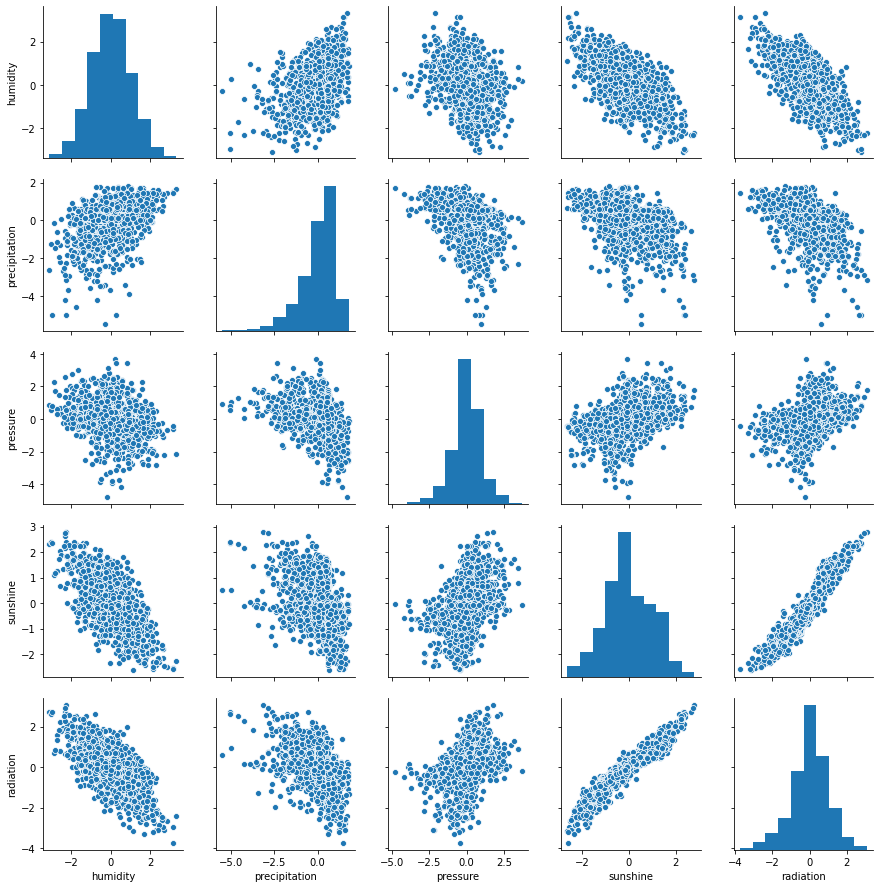

In [81]:
import seaborn as sns
check_coor = X_orig_tr_rescaled[var_meas]
# check_coor = X_orig_tr[var_meas] # correlation computed with non rescaled data
sns.pairplot(check_coor);

##### **D.1.4. Check for missing values and outliers**

Removal of missing values is already performed.

In [82]:
# missing values
X_orig_rescaled.isnull().sum()[X_orig_rescaled.isnull().sum() != 0]

Series([], dtype: int64)

C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plot

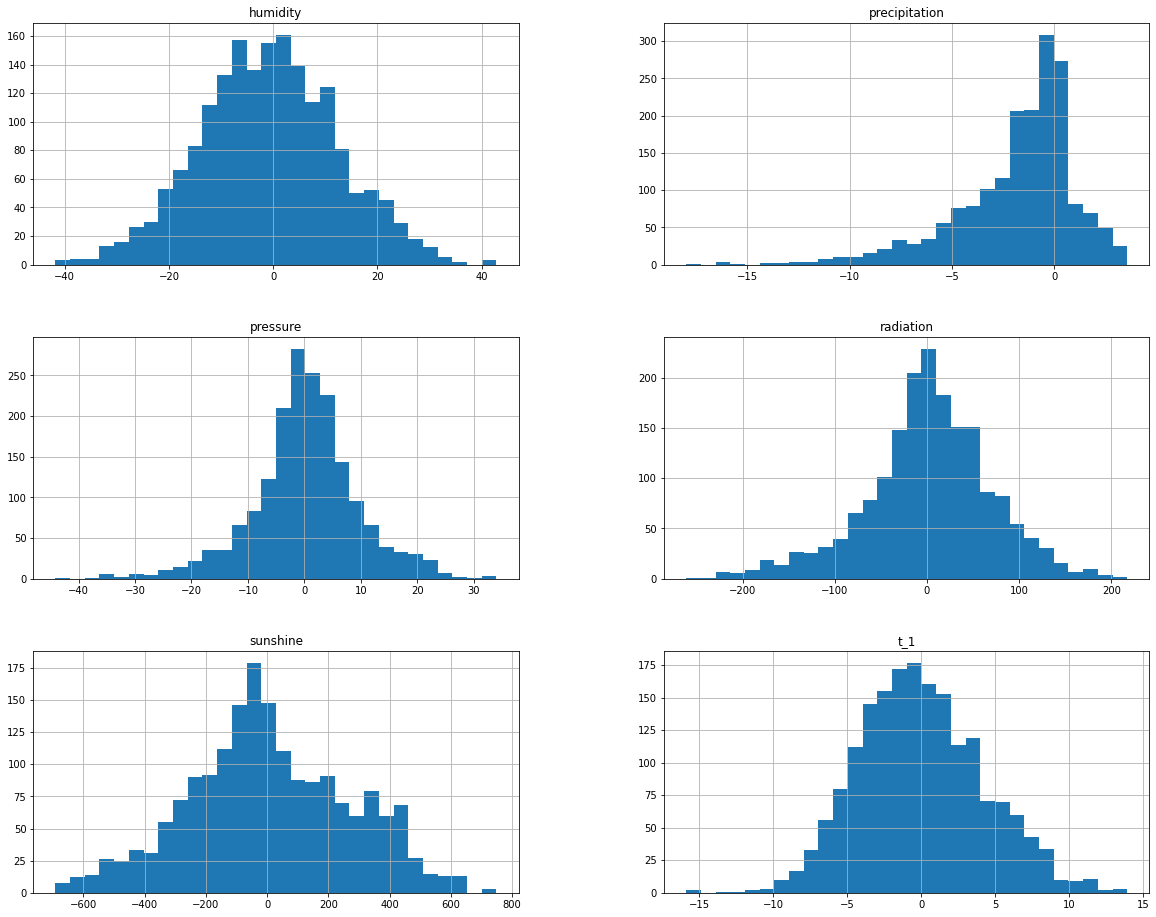

In [83]:
X_orig[var_meas + ['t_1']].hist(figsize=(20,16), bins=30);

No outliers seem to be present. Days without sunshine or precipitation are clearly visible.

#### **D.2. Principal Component Analysis**

##### **D.2.1 PCA**

In [84]:
from sklearn.decomposition import PCA

In [85]:
# Components selection
# n_comp = 7 # number of components
# n_comp = .8 # select the number of components such that the amount of variance that needs to be explained is > the percentage specified.

# Create PCA transformer
# pca = PCA(n_components=n_comp, svd_solver='full') # svd_solver = 'full' if n_comp is a percentage.
pca = PCA(n_components=None) # Compute all the components in order to display the scree plot below

# Apply PCA
# var_pca = var_meas + ['season', 'month', 'year', 't_1', 't_y1']
var_pca = var_meas + ['season', 'month', 'year']
X_pca = X_orig_rescaled[var_pca].values
pca.fit(X_pca, y=None); # Unsupervised learning, no y variable

# Project data onto the first n_comp components
X_pca_ndim = pca.transform(X_pca)

In [86]:
# Create DataFrame with variance and the principal components
df_pca = pd.DataFrame({'variance': X_pca.var(axis=0)}).set_index([var_pca])
for k in np.arange(pca.n_components_):
    k_comp = 'loading vector ' + np.str(k+1) # name of k-th column
    df_pca[k_comp] = pca.components_[k]
    

# Sort DataFrame by variance
df_pca.sort_values('variance', ascending=False)

variance  loading vector 1  loading vector 2  loading vector 3  \
year           1.600438         -0.058451          0.985285         -0.065577   
pressure       1.043901          0.351906         -0.108303          0.001139   
month          0.999901         -0.072996         -0.055120         -0.697271   
season         0.999888         -0.064636         -0.055293         -0.698775   
humidity       0.997820         -0.458512         -0.015441          0.073612   
sunshine       0.993601          0.515638          0.068841         -0.090948   
precipitation  0.985912         -0.350251         -0.014336         -0.049044   
radiation      0.983902          0.514245          0.078772         -0.071615   

               loading vector 4  loading vector 5  loading vector 6  \
year                  -0.124769         -0.048119         -0.021743   
pressure              -0.726275         -0.553714         -0.069035   
month                 -0.053287          0.014094          0.670172   
season                -0.061940          0.061766         -0.657856   
humidity              -0.271417         -0.182851          0.274691   
sunshine               0.269320         -0.196002          0.110175   
precipitation          0.475487         -0.776317         -0.099939   
radiation              0.279272         -0.112038          0.123593   

               loading vector 7  loading vector 8  
year                   0.056038          0.000704  
pressure               0.153864         -0.043778  
month                  0.230646         -0.008961  
season                -0.253003         -0.006415  
humidity              -0.775519          0.011100  
sunshine              -0.313769          0.706801  
precipitation          0.183238         -0.048930  
radiation             -0.350031         -0.704185

No loading vector has a coordinate close to 1 (meanning that it corresponds to a feature). Variable `year` has the largest absolute variance and the corresponding coordinate of `component 2` is about .98.

Remark: variance is about 1 because of the standardization applied before

Let's now display a 2D plot of the PCA components. In order to do that, let define the following function to display scatter plots with markers defined by values of year. The code source comes from https://github.com/matplotlib/matplotlib/issues/11155.

In [87]:
#see https://github.com/matplotlib/matplotlib/issues/11155
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [88]:
import matplotlib.patheffects as path_effects

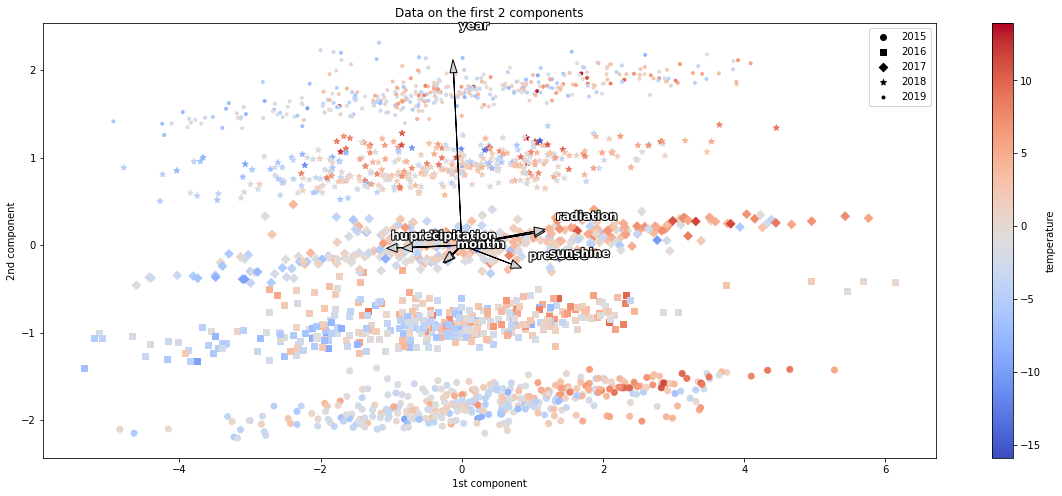

In [89]:
# Plot
fig, ax = plt.subplots(figsize=(20,8))

# Define a correspondance between years and markers to plot each year with a different marker
years = X_orig.year.unique()
markers = np.array(["o", "s", "D", "*", "."])
years_markers_dict = dict(zip(years, markers))
m = X_orig.replace({'year': years_markers_dict}).year

# use the function defined above to display the scatter plot
scatter = mscatter(X_pca_ndim[:, 0], X_pca_ndim[:, 1], c=y, cmap='coolwarm', m=m, ax=ax) # color in function of the temperature
fig.colorbar(matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=np.min(y), vmax=np.max(y)), cmap='coolwarm'), ax=ax, label='temperature') # add the bar on the right

# Plot a few features using the weights in the loading vectors
for feature in var_pca:
    # Get weights
    weight1 = df_pca.loc[feature, 'loading vector 1']*2 # rescale them
    weight2 = df_pca.loc[feature, 'loading vector 2']*2 # (2 is arbitrary)
    # Plot arrows
    plt.arrow(
        0, 0, # Vector starts at (x,y)=(0,0)
        weight1, weight2, # ends at (x,y)=(weight1, weight2)
        head_width=0.1, head_length=0.15, fc='lightgrey', ec='black')
    # Add text
    text = plt.text(
        weight1 * 1.2 + 0.1, # x location (1.2 is arbitrary)
        weight2 * 1.2 + 0.1, # y location
        feature, # Feature name
        weight='bold', color='white', size=12)
    if feature == 'sunshine': # to avoid overlapping of 'radiation' and 'sunshine'
        text = plt.text(
            weight1 * 1.2, # x location (1.2 is arbitrary)
            weight2 * 1.2 - 0.3, # y location
            feature, # Feature name
            weight='bold', color='white', size=12)      
    # Make the text stand out
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()])

# add the correspondance years <-> markers in the legend
custom_handles = []
for year, mark, n in zip(years, markers, np.arange(len(years))):
    custom_handles.append(plt.scatter([], [], c='black', marker=mark, label=str(year)))
plt.legend(handles=custom_handles)
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.title('Data on the first 2 components')
plt.show()

<span style="color:red">
Modification compared with the original notebook: `year` is pointing in the opposite direction, which does not modify fundamentally the interpretation of this analysis.
</span>

The plot on the two first components shows a particular pattern: points corresponding to high (resp. low) temperature have a low (resp. large) 1<sup>st</sup> component. It makes the *colour gradient* horizontally. Moreover, radiation, sunshine and in a less pronounced way 'pressure'  point to high temperatures, while 'precipitation' and 'humidity' point to low temperatures. This seems to be logical. 

Vertically, the five different years seem to be separated on the 2<sup>nd</sup> component (each year is represented by a marker with a different shape). This was already highlighted by the first coordinate of the second loading vector for the `year` feature. A 3D-plot emphasizes better the separation by years (using module `Axes3D`from library `mpl_toolkits` and adapted from https://www.studytonight.com/matplotlib/matplotlib-3d-plotting-line-and-scatter-plot).

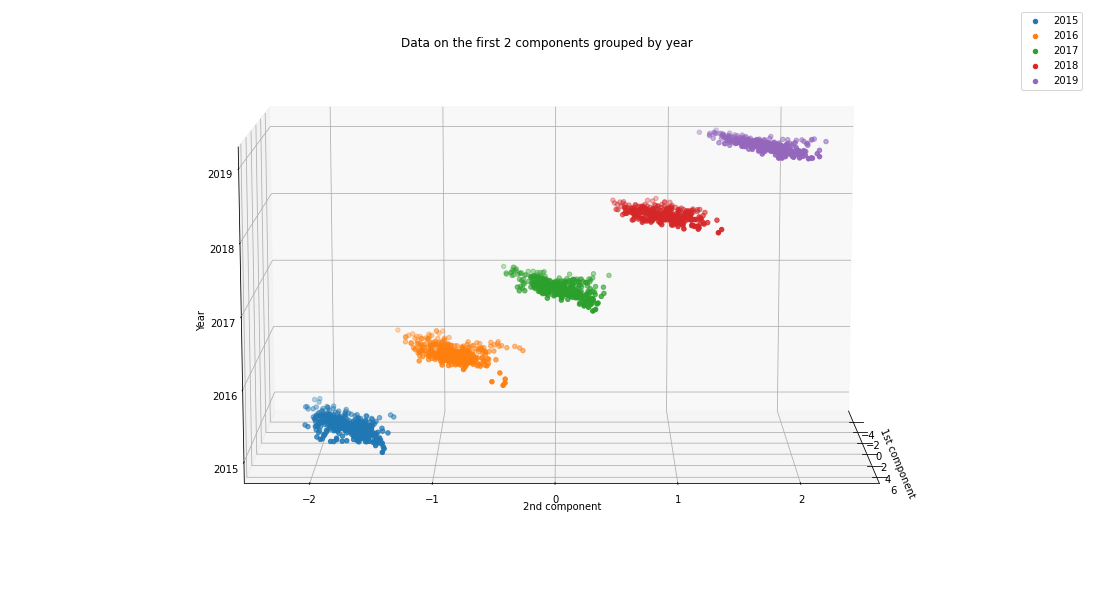

In [90]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,8)) # Size of the figure
ax = Axes3D(fig)

# Plot each year in a different colour
years_rescaled_dict = dict(zip(np.unique(X_pca[:,-1]), X_orig.year.unique()))

# for kind in np.unique(X_orig.year):
for kind in np.unique(X_pca[:,-1]):

    # Image samples of this type
    idx = (X_pca[:,-1] == kind)

    # Plot their components
    ax.scatter(X_pca_ndim[idx, 0], X_pca_ndim[idx, 1], X_pca[idx, -1], label=years_rescaled_dict[kind])
    ax.view_init(elev=10, azim=0) # set a view where the clusters are clearly visibles

# set z ticks and labels
ax.set_zticks(list(years_rescaled_dict.keys()))
ax.set_zticklabels(years_rescaled_dict.values())

# Labels and legend
plt.legend()
ax.set_xlabel('1st component')
ax.set_ylabel('2nd component')
ax.set_zlabel('Year', rotation=90)
plt.title('Data on the first 2 components grouped by year')
plt.show()

On this plot, Data points are projected on the first two components (horizontally in 2D), vertically grouped and coloured by year. We can clearly see that data points are shifted on the second component in function to the year.

Now let's compute the explained variance ratio b component.

In [91]:
# Display variance info
pve = pca.explained_variance_ratio_.transpose() # Proportion of variance explained
df_explained_variance_ratio_ = pd.DataFrame(data=pve, columns=(['explained variance ratio']), index=1 + np.arange(pca.n_components_))
df_explained_variance_ratio_.index.set_names(['component'], inplace=True)
display(df_explained_variance_ratio_)

explained variance ratio
component                          
1                          0.358783
2                          0.187651
3                          0.182205
4                          0.093947
5                          0.077757
6                          0.050160
7                          0.043541
8                          0.005956

To visualize these ratios, let's display a Scree plot, that is a bar chart with the proportion of variance explained for each component.

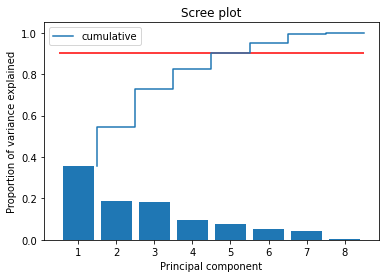

In [92]:
# Create bar plot
xcor = 1 + np.arange(len(pve)) # 1,2,..,n_components
plt.bar(xcor, pve)
plt.hlines(y=0.9, xmin=.5, xmax=len(pve)+.5, color='red') # display the threshold of 90%
plt.xticks(xcor)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor+0.5, # 1.5,2.5,..,n_components+0.5
    pve_cumsum, # Cumulative sum
    label='cumulative'
)

# Add labels
plt.title('Scree plot')
plt.xlabel('Principal component')
plt.ylabel('Proportion of variance explained')
plt.legend()
plt.show()

Five components are required to explain 90% of the variance (only 4 are needed to reach 80%).

In order to analyze the most influent variables, let's select the k best variables according to the p-value. First among the measurements and the lags.

In [93]:
from sklearn.feature_selection import SelectKBest, f_regression

In [94]:
X_tr_intermediate_tmp = X_orig_tr[var_meas + ['t_1', 't_y1']].copy() # consider only the original measurement and the temperature
dates = matplotlib.dates.date2num(X_orig_tr['time'])
X_tr_intermediate_tmp['time'] = dates
y_tr_intermediate = y_tr.copy()

# Number of features considered
k = 5 

# Create the selecter object
skb = SelectKBest(f_regression, k=k)

# Fit the selecter to the data
X_tr_intermediate_tmp2 = skb.fit_transform(X_tr_intermediate_tmp, y_tr_intermediate)

# Extract the top k features from the `pvalues_` attribute
k_feat = np.argsort(skb.pvalues_)[:k]
var_skb_meas = X_tr_intermediate_tmp.columns[k_feat]
var_skb_meas

Index(['t_1', 'sunshine', 'radiation', 'humidity', 'pressure'], dtype='object')

<span style="color:red">
Modification compared with the original notebook: 4 over 5 of the selected variables are also present here. The corresponding result of the original version is ['t_1', 't_y1', 'radiation', 'sunshine', 'humidity'].
</span>

Then among all variables.

In [95]:
from sklearn.feature_selection import SelectKBest, f_regression

# convert variable 'time' from TimeStamp to dates
X_tr_intermediate_tmp = X_orig_tr.drop(['time'], axis=1) # consider all variables
dates = matplotlib.dates.date2num(X_orig_tr['time'])
X_tr_intermediate_tmp['time'] = dates
y_tr_intermediate = y_tr.copy()

# Number of features considered
k = 5 

# Create the selecter object
skb = SelectKBest(f_regression, k=k)

# Fit the selecter to the data
X_tr_intermediate_tmp2 = skb.fit_transform(X_tr_intermediate_tmp, y_tr_intermediate)

# Extract the top k features from the `pvalues_` attribute
k_feat = np.argsort(skb.pvalues_)[:k]
var_skb_meas_all = X_tr_intermediate_tmp.columns[k_feat]
var_skb_meas_all

Index(['t_SHA', 't_ZER', 't_SIO', 't_CDF', 't_STG'], dtype='object')

<span style="color:red">
The corresponding result of the original version is ['t_ZER', 't_DIS', 't_OTL', 't_BER', 't_ALT']. Only Zermatt is common in both, despite its geographical/topographical characteristics !
</span>

Note that the temperature in the geographical nearest neighbours (`CDF`) are not present in these selected variables (the difference of altitude and topography could explain that). No measurements other than temperature are present anymore.

##### **D.2.2 Final check**

Let's take again a final look at the dataset to confirm everything is ready for the machine learning part. First let's plot each variable as a time serie (grouped by measurement).

C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plotting\_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\pandas\plot

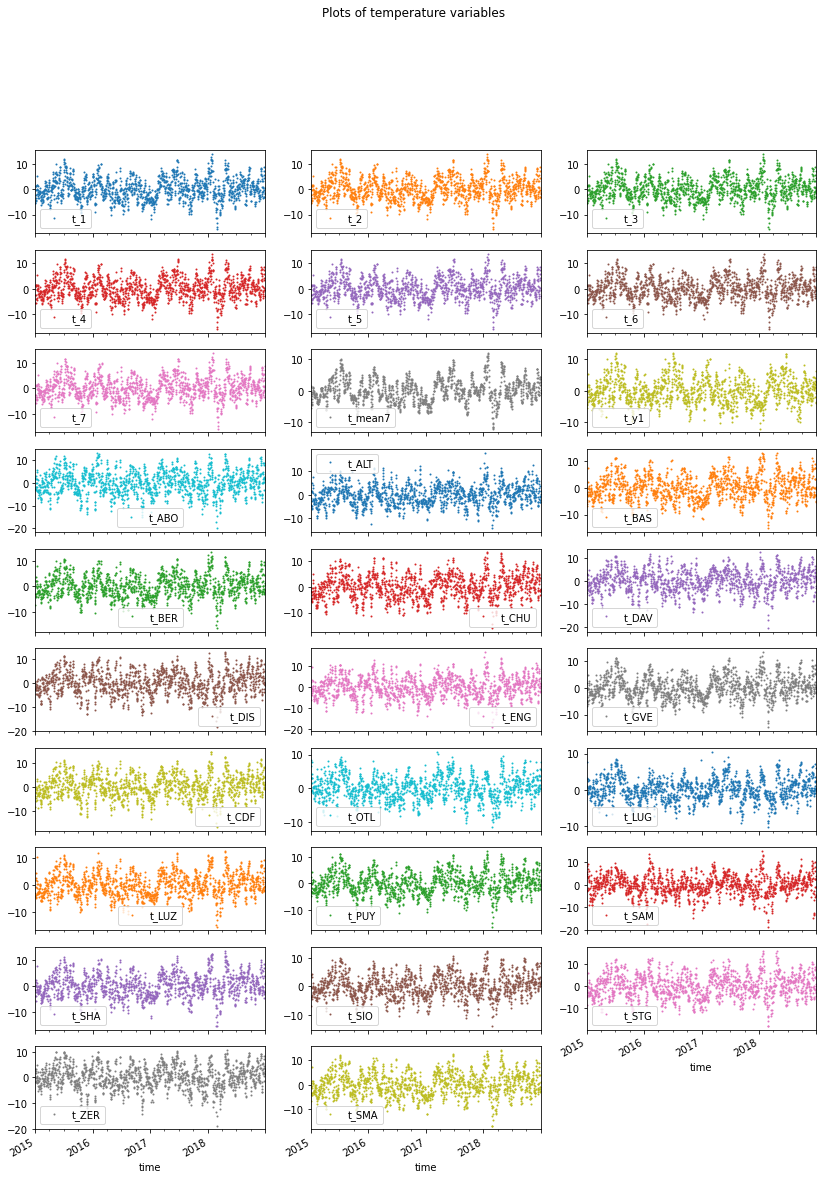

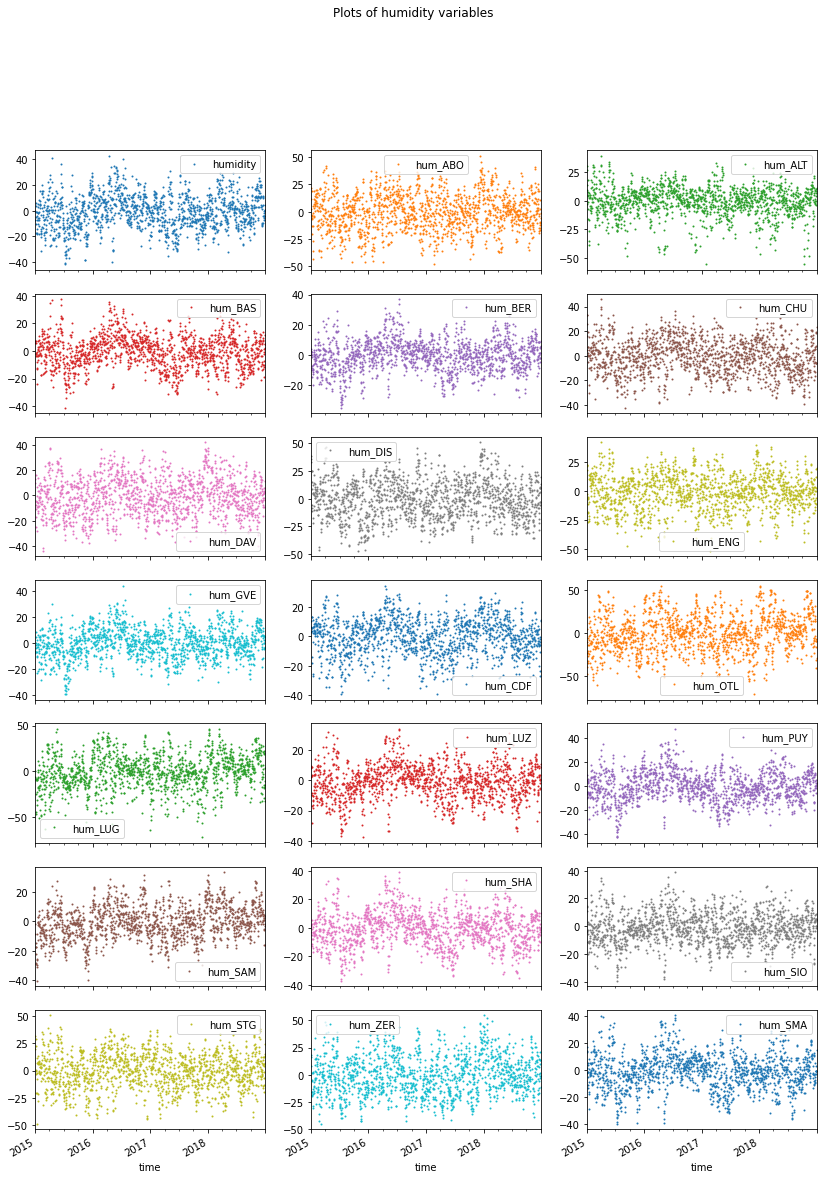

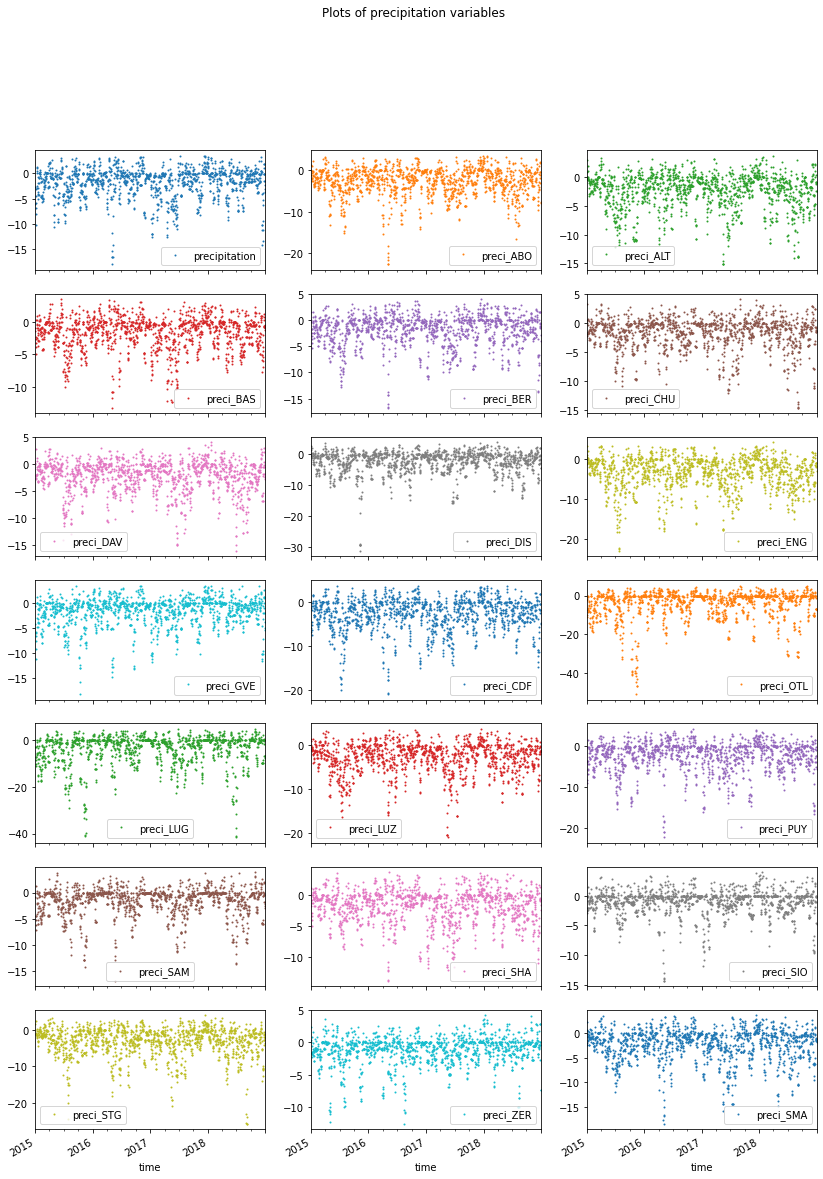

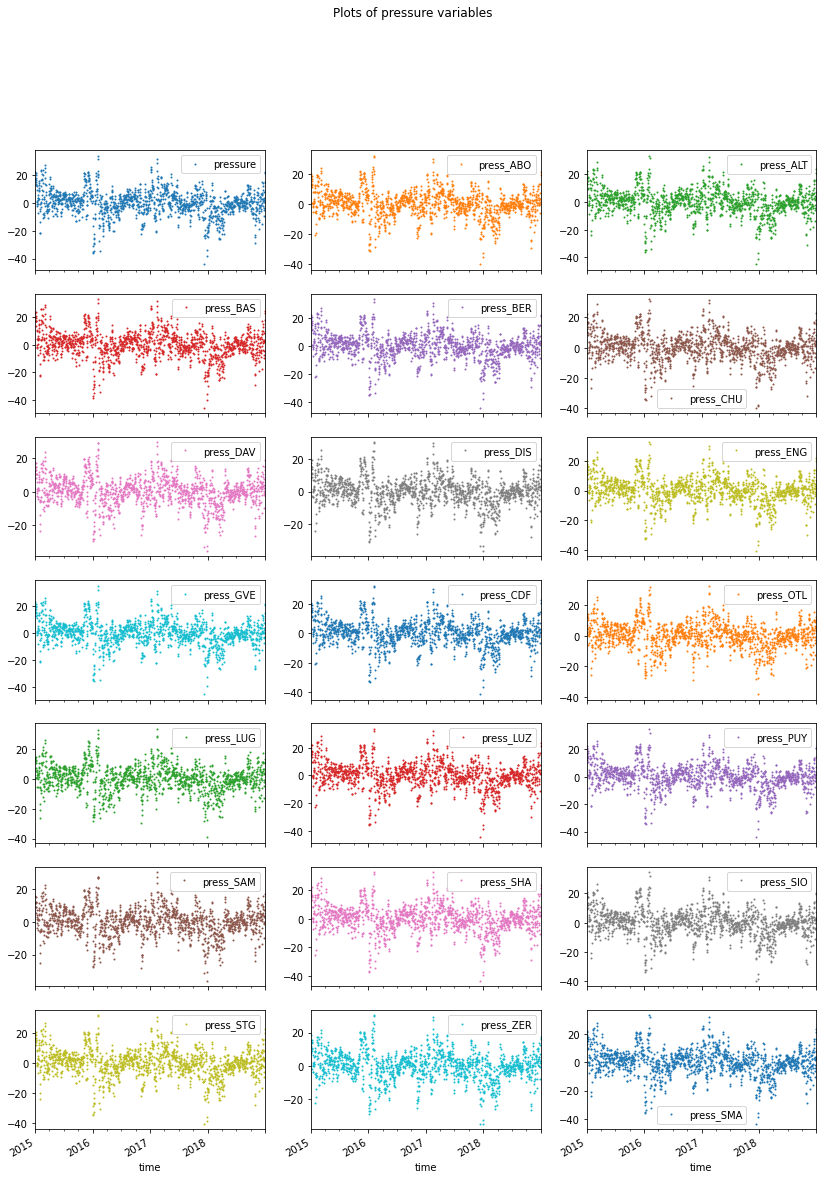

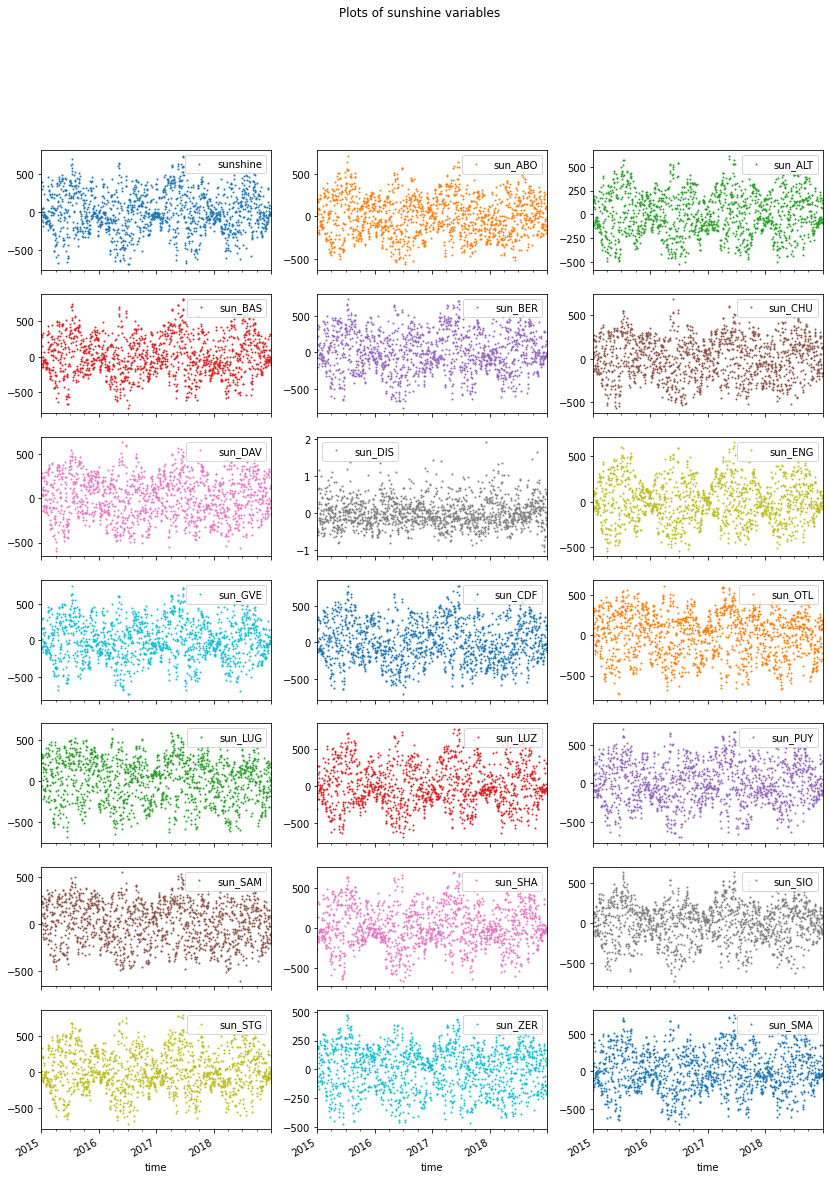

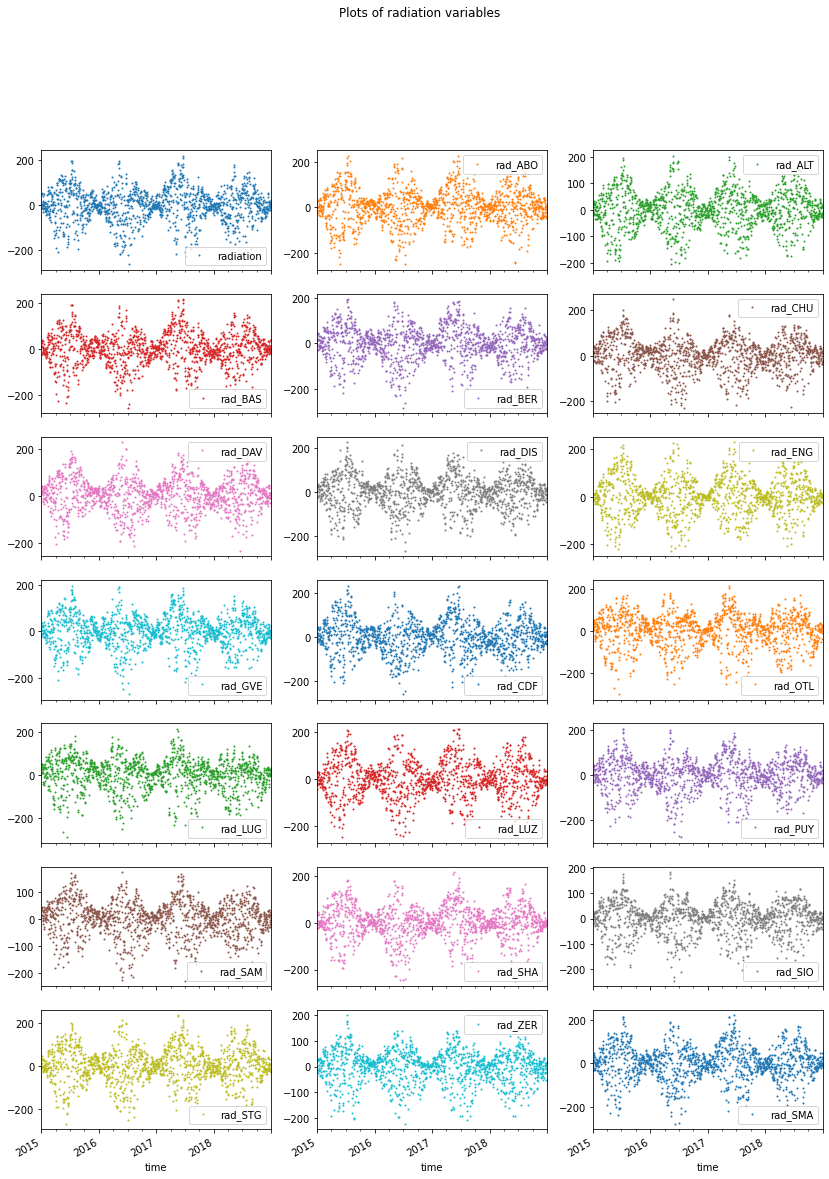

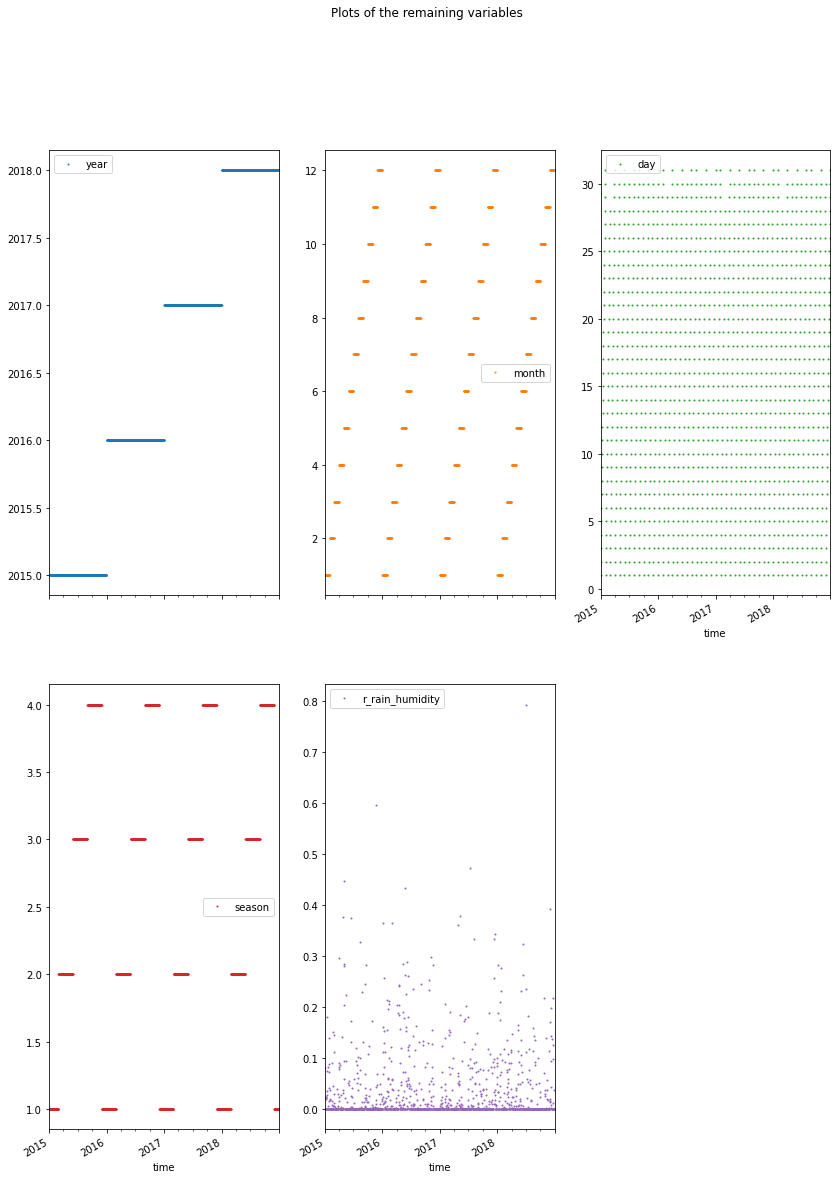

In [96]:
filter_col = [col for col in X_orig_tr if col.startswith('t_')]
X_orig_tr.set_index('time').loc[:, filter_col].plot(lw=0, marker='.', subplots=True, layout=(-1,3), figsize=(14, 20), markersize=2, title='Plots of temperature variables');
diplayed_col = filter_col

for v in var_meas:
    prefix = v[0:3]
    if prefix == 'pre':
        prefix = v[0:4]
    filter_col = [col for col in X_orig_tr if col.startswith(prefix)]
    # plot
    X_orig_tr.set_index('time').loc[:, filter_col].plot(lw=0, marker='.', subplots=True, layout=(-1,3), figsize=(14, 20), markersize=2, 
                                                        title='Plots of '+ v +' variables');
    diplayed_col = diplayed_col + filter_col

filter_col = [col for col in X_orig_tr if col not in diplayed_col]
filter_col.remove('time')
X_orig_tr.set_index('time').loc[:, filter_col].plot(lw=0, marker='.', subplots=True, layout=(-1,3), figsize=(14, 20), markersize=2, title='Plots of the remaining variables');

Seasonality is clearly visible for the original measurements (less pronounced for 'precipitation'). Then look at the relationship (i.e. the pearson correlation) between the features with heatmaps.

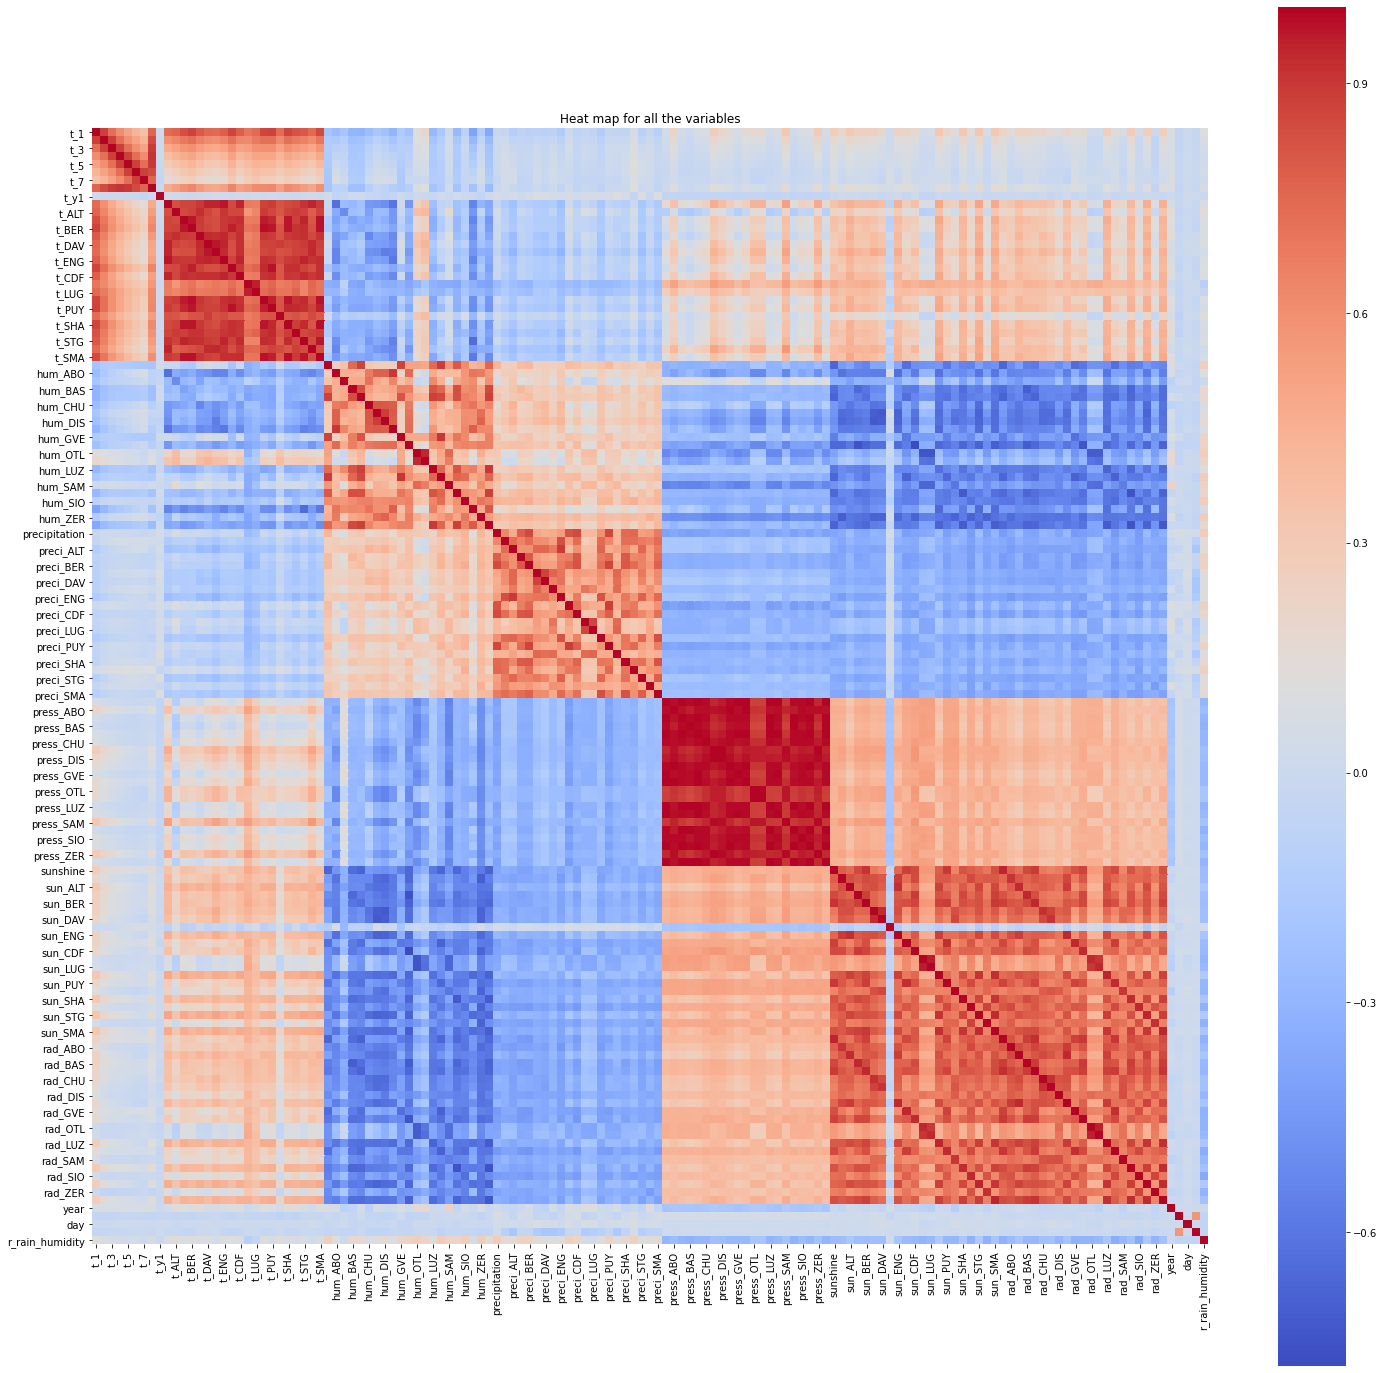

In [97]:
tot_col = diplayed_col + filter_col
plt.figure(figsize=(25, 25))
plt.title('Heat map for all the variables');
sns.heatmap(X_orig_tr.loc[:, tot_col].corr(), square=True, cmap='coolwarm');

Each kind of measurements (e.g. temperatures variables, humidity variables, ...) is clearly visible in the heatmap. Inside a kind of measurements, the correlation is mostly higher in comparison to the other variables. It gives a *partition* in rectangles and highlights *super-square* patterns along the diagonal.

#### **D.3. Complementary discussion**

Data appears to be of good quality after the cleaning process. A log-transform to remove skewnees from the variable 'precipitation' and a seasonal adjustment for the temperature have been performed.

The Principal Component Analysis show that 5 variables are required to explain more than 90% of the variance. Natural relationship between variables are clearly visible ('sunshine', 'radiation' and 'pressure' associated to high temperatures, 'humidity' and 'precipitation' to low temperatures). Each year is more or less well clustered, which can also be seen in the value of the first coordinate of the second loading vector.

The highest correlated measurements with temperature are sunshine, radiation, humidity and season. They can reasonably be considered to predict temperature. Models based on these variables will be considered, as well as full-variables models to compare with. Other selections (e.g. with the "SelectKBest" module of SciKitLearn, or based on geographically characteristics, ...) will be performed as well.

A word about the baseline : The high correlations between temperature and its lag indicate that the `t_1`-baseline for prediction will be challenging to beat.

#### **D.4. Export cleaned data**

In [98]:
# Save the principal data
X_orig.to_csv('X_orig.txt',index=False)

### E. Machine learning 

The goal of the project is to guess the temperature in Neuchâtel for year 2020 based on the daily measurments of the 24 main stations of the Swiss Meteorogical Network (SwissMetNet) performed during the years 2015 to 2020. To compute these predictions:

- Several models based on various regressors (kNN, Ridge, Lasso, RandomForest) will be compared to baselines;
- Different selections of variables will be considered :
    - the whole set of available variables;   
    - most correlated variables with the temperature in Neuchatel;
    - using SelectKBest;
    - a couple of the nearest geographical stations, but without any weather measurements in Neuchatel;
    - measurements in Neuchâtel only (without any information from the other stations);
    - without temperature variables variants.
    
With all variables, this is the "technical problem" version. On the other hand, the "prediction problem" consisting in guessing the temperature on next day is addressed in the latter by selecting only temperatures lags (and the other features). Lastly, the "new station problem" corresponds to the variables selection without temperature in Neuchatel "without t in NEU".

Finally, the whole notebook can be runned again with adjusted temperature.

#### **E.1. Baselines**

##### **E.2.1 Baseline 1: temperature one year before**

In [99]:
# Test set
y_te_baseline_y = X_orig_te.loc[(X_orig_te.time>='2019-01-01') & (X_orig_te.time<'2020-01-01'), ['t_y1']]
y_te_baseline_y = y_te_baseline_y.squeeze() # Squeeze 1 dimensional axis objects into scalars.

# Predictions
y_pred_baseline_y = X_to_predict.loc[(X_to_predict.time>='2020-01-01'), ['t_y1']]
y_pred_baseline_y = y_pred_baseline_y.squeeze() # Squeeze 1 dimensional axis objects into scalars.

In [100]:
# Test set
delta_y_te_baseline_y = y_te - y_te_baseline_y

# Predictions
delta_y_pred_baseline_y = y_to_predict - y_pred_baseline_y

Compute and display model performance for baseline.

In [101]:
# Mean Absolute error (MAE)
def MAE(y, y_pred):    
    return(np.mean(np.abs(y-y_pred)))

# Mean Square error (MSE)
def MSE(y, y_pred):
    return np.mean(np.square(y-y_pred))

# Compute model error
def model_error(y, y_pred):
#    score = MSE(y, y_pred) # MSE version
    score = MAE(y, y_pred) # MAE version
    return score

<span style="color:red">
Remark : By construction, the score is already in °C, so the `model_error` function does not need to be adapted.
</span>

In [102]:
# Model performance on the test set
MAE_te_baseline_y = model_error(y_te, y_te_baseline_y)
print('Baseline 1: Test set - MAE score: {:.2f} degres'.format(MAE_te_baseline_y))

# Model performance for predictions
MAE_pred_baseline_y = model_error(y_to_predict, y_pred_baseline_y)
print('Baseline 1: Predictions - MAE score: {:.2f} degres'.format(MAE_pred_baseline_y))

Baseline 1: Test set - MAE score: 6.35 degres
Baseline 1: Predictions - MAE score: 5.44 degres


<span style="color:red">
Modification compared with the original notebook: We still need to adapt the plot to display the predicted temperature and not the adjusted temperature.
</span>

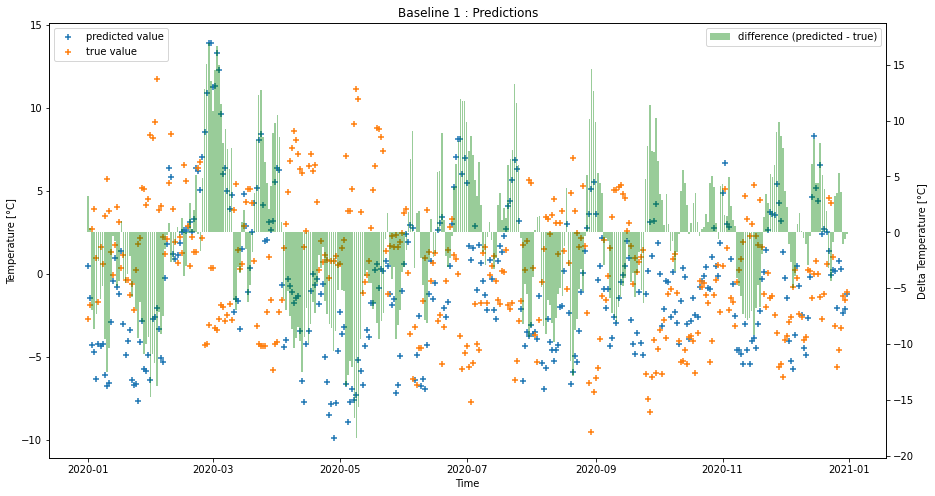

In [103]:
# Bar plot
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.scatter(time_to_predict, y_pred_baseline_y, marker='+', label='predicted value')
ax1.scatter(time_to_predict, y_to_predict, marker='+', label='true value')
ax2.bar(time_to_predict, y_pred_baseline_y - y_to_predict, label='difference (predicted - true)', color='green', alpha=.4)

plt.title('Baseline 1 : Predictions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature [°C]')
ax2.set_ylabel('Delta Temperature [°C]')
ax1.legend(loc=2) # legend for y values upper left
ax2.legend(loc=1) # legend for difference upper right
plt.show()    

<span style="color:red">
Comparison with the original notebook: The graphic above shows adjusted temperatures and not true temperatures. However, the scale is still in °C (as for the score). A way to display true temperatures would be to plot the original temperature saved in Cell 74 (part D.1.2) and to *reverse* the predicted temperature by adding the mean over 7 days one year ago of the true temperatures for the first year, then using the reconstructed temperature in the mean for the following years.
</span>

##### **E.2.2 Baseline 2: temperature one day before**

In [104]:
# Test set
y_te_baseline_1 = X_orig_te.loc[(X_orig_te.time>='2019-01-01') & (X_orig_te.time<'2020-01-01'), ['t_1']]
y_te_baseline_1 = y_te_baseline_1.squeeze() # Squeeze 1 dimensional axis objects into scalars.

# Predictions
y_pred_baseline_1 = X_to_predict.loc[(X_to_predict.time>='2020-01-01'), ['t_1']]
y_pred_baseline_1 = y_pred_baseline_1.squeeze() # Squeeze 1 dimensional axis objects into scalars.

In [105]:
# Test set
delta_y_te_baseline_1 = y_te - y_te_baseline_1

# Predictions
delta_y_pred_baseline_1 = y_to_predict - y_pred_baseline_1

Compute and display model performance for baseline.

In [106]:
# Model performance on the test set
MAE_te_baseline_1 = model_error(y_te, y_te_baseline_1)
print('Baseline 2: Test set - MAE score: {:.2f} degres'.format(MAE_te_baseline_1))

# Model performance for predictions
MAE_pred_baseline_1 = model_error(y_to_predict, y_pred_baseline_1)
print('Baseline 2: Predictions - MAE score: {:.2f} degres'.format(MAE_pred_baseline_1))

Baseline 2: Test set - MAE score: 1.62 degres
Baseline 2: Predictions - MAE score: 1.75 degres


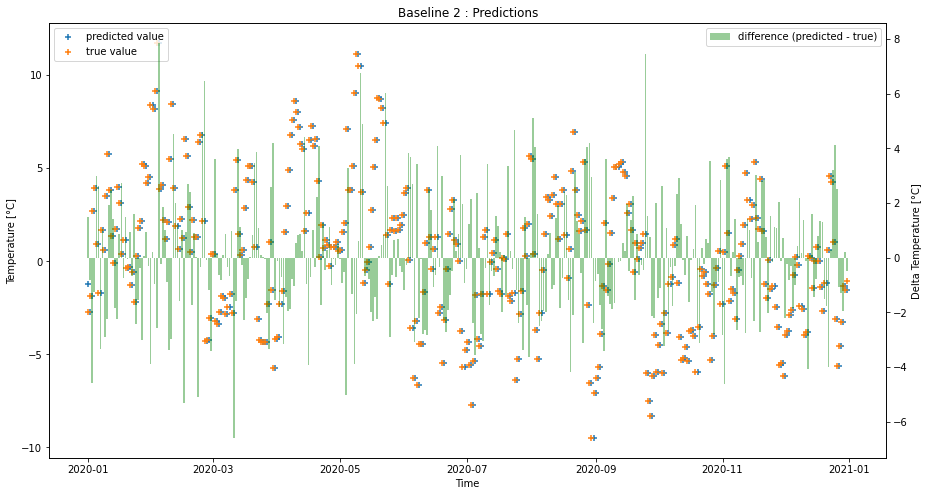

In [107]:
# Bar plot
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax1.scatter(time_to_predict, y_pred_baseline_1, marker='+', label='predicted value')
ax1.scatter(time_to_predict, y_to_predict, marker='+', label='true value')
ax2.bar(time_to_predict, y_pred_baseline_1 - y_to_predict, label='difference (predicted - true)', color='green', alpha=.4)

plt.title('Baseline 2 : Predictions')
ax1.set_xlabel('Time')
ax1.set_ylabel('Temperature [°C]')
ax2.set_ylabel('Delta Temperature [°C]')
ax1.legend(loc=2) # legend for y values upper left
ax2.legend(loc=1) # legend for difference upper right
plt.show()    

#### **E.2. Regressors**

First, let's encode the time with LabelEncoder (to avoid technical issues) and modify dtype for variables of type `int` to `float` to avoid warnings with Standardscaler below.

In [108]:
# Encode target variable Temperature as int (for use in k-NN and LogReg)
from sklearn import preprocessing
from sklearn import utils

# Encode the time variable
lab_enc = preprocessing.LabelEncoder()
X_orig_tr_enc_tmp = X_orig_tr.copy()
X_orig_te_enc_tmp = X_orig_te.copy()
X_to_predict_enc_tmp = X_to_predict.copy()
X_orig_tr_enc_tmp.loc[:, 'time'] = lab_enc.fit_transform(X_orig_tr.time) # Timestamp not allowed in knn-Regressor.
X_orig_te_enc_tmp.loc[:, 'time'] = lab_enc.fit_transform(X_orig_te.time)
X_to_predict_enc_tmp.loc[:, 'time'] = lab_enc.fit_transform(X_to_predict.time)

# Convert from int to float the integer variables 
col_int_to_float = X_orig_tr_enc_tmp.columns[(X_orig_tr_enc_tmp.dtypes=='int64').values].values # columns of type int
X_orig_tr_enc = X_orig_tr_enc_tmp.copy()
X_orig_tr_enc[col_int_to_float] = X_orig_tr_enc[col_int_to_float].astype(float, copy=False) # int -> float
X_orig_te_enc = X_orig_te_enc_tmp.copy()
X_orig_te_enc[col_int_to_float] = X_orig_te_enc[col_int_to_float].astype(float, copy=False) # int -> float
X_to_predict_enc = X_to_predict_enc_tmp.copy()
X_to_predict_enc[col_int_to_float] = X_to_predict_enc[col_int_to_float].astype(float, copy=False) # int -> float
print('Variables encoded from int to float :', col_int_to_float)

Variables encoded from int to float : ['time' 'year' 'month' 'day']


In order to replicate the various Machine Learning modelization's process (standardize, fit and transform, predict, get results and plots) for each model, let's define two functions and a class object to get the results of the modelization.

In [109]:
class ML_modelize_class():
    
    def __init__(self, scaler, estimator, df_res, df_best_res, best_estim, y_te_pred, delta_y_te): 
        self.scaler = scaler              # scaler
        self.estimator = estimator        # estimator 
        self.df_res = df_res              # result of the grid search in a DF
        self.df_best_res = df_best_res    # best result from df_res
        self.best_estim = best_estim      # best estimator
        self.y_te_pred = y_te_pred        # predicted target of the test set
        self.delta_y_te = delta_y_te      # y_te_pred - y_te        

In [110]:
def ML_modelize(scaler, estimator, df_tr, df_te, y_tr, y_te, gs_param, gs_range, **kwargs):
    # function to fit, transform and perform a grid search
    
    # scaler    : name of the scaler
    # estimator : name of the estimator
    # df_tr     : dataframe of the training set
    # df_te     : dataframe of the test set
    # y_tr      : target of the training set
    # y_te      : target of the test set
    # gs_param  : parameter of the grid_search
    # gs_range  : range of the values for the grid_search
    # **kwargs  : optionnal paremeter-value pairs to set for the estimator/regressor
    
    # Create pipeline
    pipe = Pipeline([
        ('scaler', scaler),
        ('estimator', estimator)
    ])
    
    # set parameters passed in kwargs through a dictionary
    for key, value in kwargs.items():
        param = {'estimator__'+key: value} # create dict to set parameters passed in **kwargs
        pipe.set_params(**param)
    
    # Variable to store the results
    gs_results = []

    # Grid search
    for gsp in gs_range:
        # Set hyperparameter
        gsparam = {'estimator__'+gs_param: gsp}
        pipe.set_params(**gsparam)

        # Fit the estimator
        pipe.fit(df_tr, y_tr)

        # Save model and its performance on train/test sets
        gs_results.append({
            'gs_param': gsp,
            'train_mse': MSE(y_tr, pipe.predict(df_tr)),
            'train_mae': MAE(y_tr, pipe.predict(df_tr)),
            'test_mse': MSE(y_te, pipe.predict(df_te)),
            'test_mae': MAE(y_te, pipe.predict(df_te)),
        })

    # Convert results to DataFrame
    gs_results = pd.DataFrame(gs_results)
    
    
    # Get entry with the best test MAE
    best_result = gs_results.loc[gs_results.test_mae.idxmin()]

    # Model performance
    best_gsp = best_result.gs_param
    best_MAE_te = best_result.test_mae
    print('{}-regressor: Test set - MAE score: {:.2f} degrees'.format(estimator.__class__.__name__, best_MAE_te))
    
    
    # Model predictions with best hyperparameter
    if abs(best_gsp-int(best_gsp)) < 1e-10:
        # integer parameter
        bgsp = {'estimator__'+gs_param: int(best_gsp)}
    else:
        # non-integer parameter
        bgsp = {'estimator__'+gs_param: best_gsp}
    pipe.set_params(**bgsp)
    pipe.fit(df_tr, y_tr)
    y_te_pred = pipe.predict(df_te)
    delta_y_te = y_te_pred - y_te
    best_estim = pipe
    
    return ML_modelize_class(scaler, estimator, gs_results, best_result, best_estim, y_te_pred, delta_y_te)

In [111]:
def ML_plot_predictions(time, y_true, y_pred, regr_name):
        
    # Bar plot
    fig, ax1 = plt.subplots(figsize=(15,8))
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax1.scatter(time, y_pred, marker='+', label='predicted value')
    ax1.scatter(time, y_true, marker='+', label='true value')
    ax2.bar(time, y_pred - y_true, label='difference (predicted - true)', color='green', alpha=.4)

    plt.title('{} : Predictions'.format(regr_name))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Temperature [°C]')
    ax2.set_ylabel('Delta Temperature [°C]')
    ax1.legend(loc=2) # legend for y values upper left
    ax2.legend(loc=1) # legend for difference upper right
    plt.show()
    
    return

In [112]:
def ML_plot_val_curves(ML_modelize_class_inst, regr_name, regr_param, log_scale=0):
    # Plot the validation curves
    plt.figure(figsize=(15,5)) # Size of the figure
    
    if log_scale == 0:
        plt.plot(ML_modelize_class_inst.df_res['gs_param'], ML_modelize_class_inst.df_res['train_mae'], label='train curve')
        plt.plot(ML_modelize_class_inst.df_res['gs_param'], ML_modelize_class_inst.df_res['test_mae'], label='test curve')
        plt.scatter(ML_modelize_class_inst.df_best_res.gs_param, ML_modelize_class_inst.df_best_res.test_mae, marker='x', c='red', zorder=10) # Mark best gs_param value
    else:
        plt.plot(np.log10(ML_modelize_class_inst.df_res['gs_param']), ML_modelize_class_inst.df_res['train_mae'], label='train curve')
        plt.plot(np.log10(ML_modelize_class_inst.df_res['gs_param']), ML_modelize_class_inst.df_res['test_mae'], label='test curve')
        plt.scatter(np.log10(ML_modelize_class_inst.df_best_res.gs_param), ML_modelize_class_inst.df_best_res.test_mae, marker='x', c='red', zorder=10) # Mark best gs_param value
    

    plt.title('{} : Best {}: {:.3f} - mae: {:,.3f} degrees'.format(regr_name, regr_param, ML_modelize_class_inst.df_best_res.gs_param, ML_modelize_class_inst.df_best_res.test_mae))
    if log_scale == 0:
        plt.xlabel(regr_param)
    else:
        plt.xlabel('$log_{10}$('+regr_param+')')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
    
    return

##### **E.2.1 kNN-Regression**

As suggested in [Unit 04.02.05](https://learn.extensionschool.ch/learn/programs/applied-data-science-machine-learning-v2/subjects/k-nearest-neighbors-v2/units/standardization-and-k-nn-v2) *Standardization and k-NN*, kNN-Regression leads to better results when applied to standardized data, so we apply the `StandardScaler()` in the preprocessing step.

In [113]:
# k-NN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

KNeighborsRegressor-regressor: Test set - MAE score: 1.26 degrees


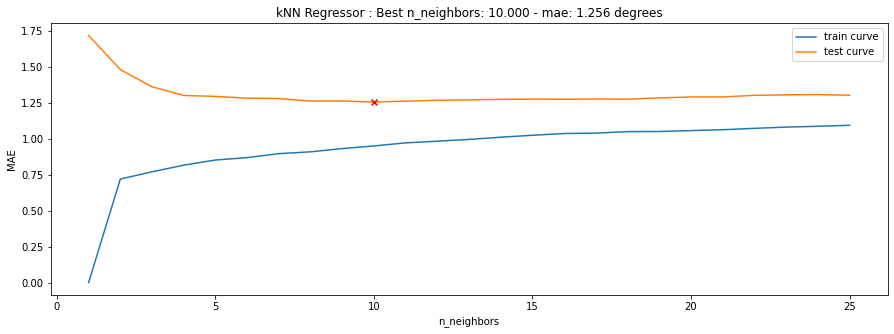

knn-regressor: Test set - MAE score: 1.26 degres


In [114]:
gs_results_knn = ML_modelize(StandardScaler(), # scaler
                             KNeighborsRegressor(), # knn estimator
                             X_orig_tr_enc, # dataframe of the training set
                             X_orig_te_enc, # dataframe of the test set
                             y_tr, # target of the training set
                             y_te, # target of the test set
                             'n_neighbors', # parameter of the grid_search
                             1+np.arange(25), # parameter range
                             algorithm='brute') # additional arguments to the estimator

ML_plot_val_curves(gs_results_knn, 'kNN Regressor', 'n_neighbors')

# Model performance on the test set
MAE_te_knn = gs_results_knn.df_best_res.test_mae
print('knn-regressor: Test set - MAE score: {:.2f} degres'.format(MAE_te_knn))

<span style="color:red">
Comparison with the original notebook: the optimal number of neighbours is 15 in the original version and the test score 1.303.
</span>

Let's perform the predictions for year 2020 with the best hyperparemeter defined on the test set.

kNN-regressor: MAE score for predictions: 1.09 degrees


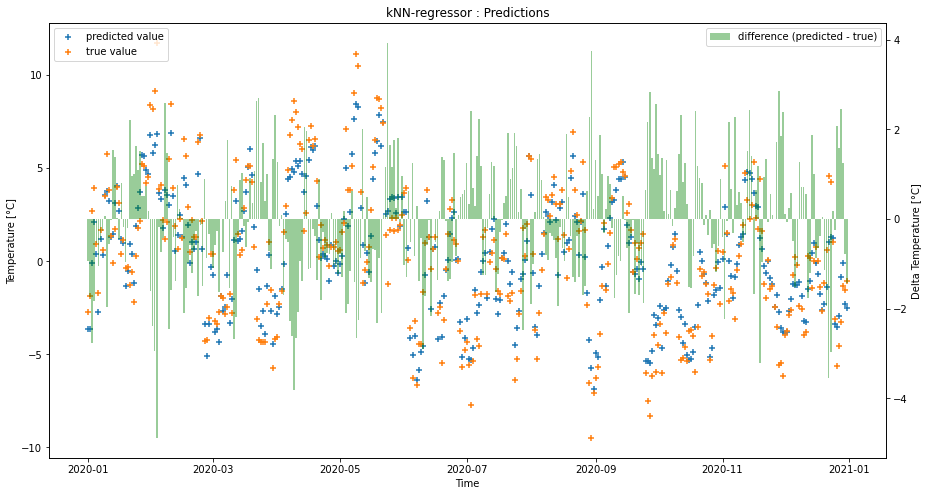

In [115]:
# Predictions from the model
y_pred_knn = gs_results_knn.best_estim.predict(X_to_predict_enc)

# Predictions score (Model performance for the predictions)
MAE_pred_knn = model_error(y_to_predict, y_pred_knn)
print('kNN-regressor: MAE score for predictions: {:.2f} degrees'.format(MAE_pred_knn))

# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_knn, 'kNN-regressor')

##### **E.2.2 Ridge-Regression**

In [116]:
from sklearn.linear_model import Ridge

Ridge-regressor: Test set - MAE score: 0.26 degrees


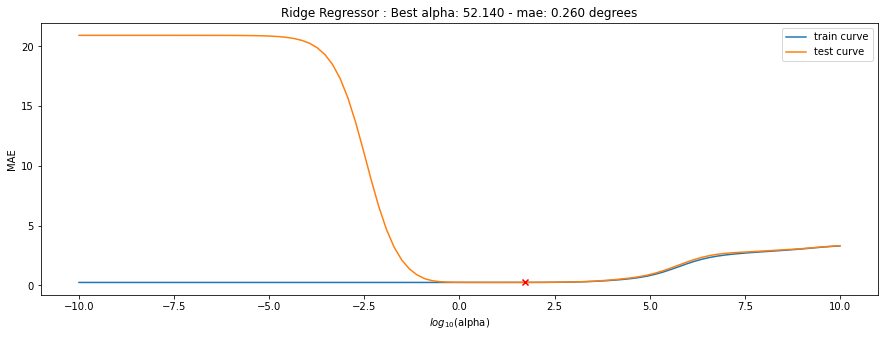

Ridge-regressor: Test set - MAE score: 0.26 degres


In [117]:
# Without preprocessed standardization
gs_results_ridge = ML_modelize(None, Ridge(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'alpha', np.logspace(-10, 10, num=100))
ML_plot_val_curves(gs_results_ridge, 'Ridge Regressor', 'alpha', log_scale=1)
# Model performance
MAE_te_ridge = gs_results_ridge.df_best_res.test_mae
print('Ridge-regressor: Test set - MAE score: {:.2f} degres'.format(MAE_te_ridge))

To avoid working with ill-conditioned matrices, let's standarize the data first.

Ridge-regressor: Test set - MAE score: 0.26 degrees


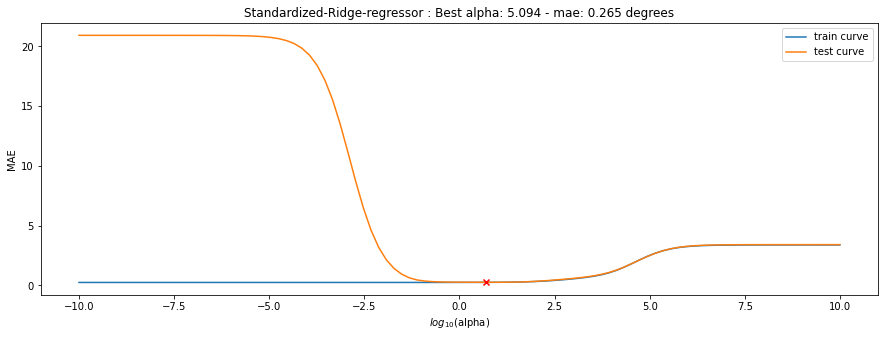

Standardized-Ridge-regressor: Test set - MAE score: 0.26 degres


In [118]:
# With preprocessed standardization
gs_results_ridge_std = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'alpha', np.logspace(-10, 10, num=100))
ML_plot_val_curves(gs_results_ridge_std, 'Standardized-Ridge-regressor', 'alpha', log_scale=1)
# Model performance
MAE_te_ridge_std = gs_results_ridge_std.df_best_res.test_mae
print('Standardized-Ridge-regressor: Test set - MAE score: {:.2f} degres'.format(MAE_te_ridge_std))

<span style="color:red">
Comparison with the original notebook: The optimized parameter found in the original version is 1.262 for a test score of 0.24.
Note that the best test score is not improved with the standardization performed in the preprocessing unlike the original version
</span>

In [119]:
# save the best hyperparameter
best_alpha_ridge_std = gs_results_ridge_std.df_best_res.gs_param
print('Hyperparameter of the best model : alpha = {:.3f}'.format(best_alpha_ridge_std))

Hyperparameter of the best model : alpha = 5.094


Let's plot the prediction with the model optimized on the standardized data.

Standardized-Ridge-regressor: MAE score for predictions: 0.29 degrees


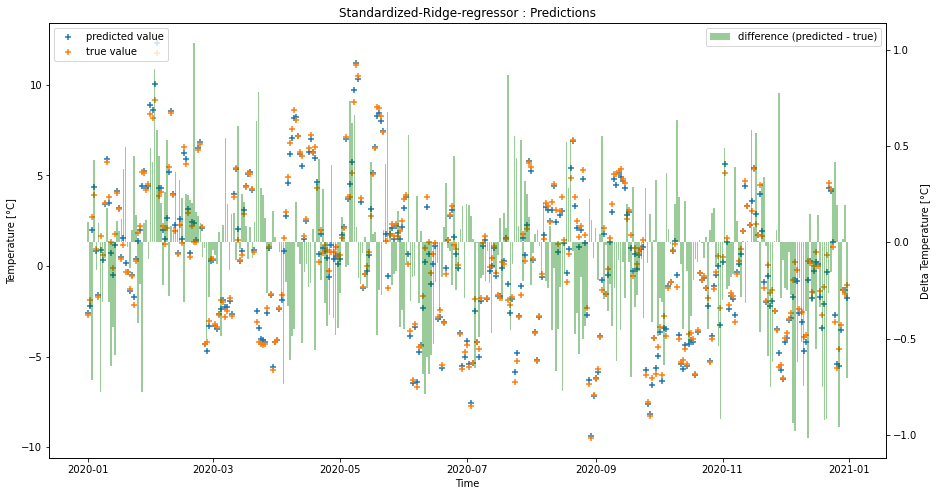

In [120]:
# Predictions from the model
y_pred_ridge_std = gs_results_ridge_std.best_estim.predict(X_to_predict_enc)

# Predictions score (Model performance for the predictions)
MAE_pred_ridge_std = model_error(y_to_predict, y_pred_ridge_std)
print('Standardized-Ridge-regressor: MAE score for predictions: {:.2f} degrees'.format(MAE_pred_ridge_std))

# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_ridge_std, 'Standardized-Ridge-regressor')

##### **E.2.3 Lasso-Regression**

In [121]:
from sklearn.linear_model import Lasso

First, without standardization in the preprocessing.

C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\muriel\.conda\envs\exts-ml\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso-regressor: Test set - MAE score: 0.26 degrees


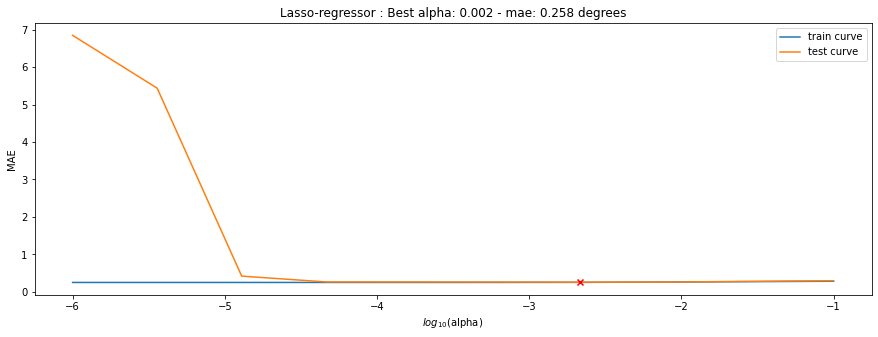

Lasso-regressor: Test set - MAE score: 0.26 degres


In [122]:
gs_results_lasso = ML_modelize(None, Lasso(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'alpha', np.logspace(-6,-1, num=10), max_iter=2e5)
ML_plot_val_curves(gs_results_lasso, 'Lasso-regressor', 'alpha', log_scale=1)
# Model performance
MAE_te_lasso = gs_results_lasso.df_best_res.test_mae
print('Lasso-regressor: Test set - MAE score: {:.2f} degres'.format(MAE_te_lasso))

Then, with standardization in the preprocessing.

Lasso-regressor: Test set - MAE score: 0.28 degrees


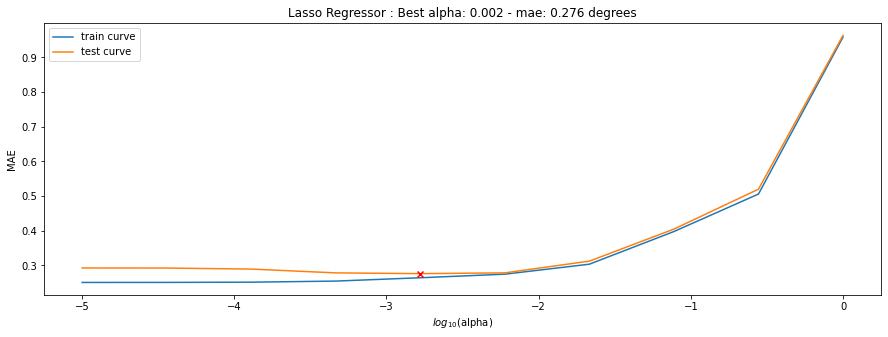

Standardized-Lasso-regressor: Test set - MAE score: 0.28 degres


In [123]:
gs_results_lasso_std = ML_modelize(StandardScaler(), Lasso(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'alpha', np.logspace(-5, 0, num=10), max_iter=2e5)
ML_plot_val_curves(gs_results_lasso_std, 'Lasso Regressor', 'alpha', log_scale=1)
# Model performance
MAE_te_lasso_std = gs_results_lasso_std.df_best_res.test_mae
print('Standardized-Lasso-regressor: Test set - MAE score: {:.2f} degres'.format(MAE_te_lasso_std))

<span style="color:red">
Comparison with the original notebook: The optimized parameter found in the original version is 0.006 for a test score of 0.242.
Note that the best test score is not improved with the standardization performed in the preprocessing unlike the original version
</span>

Standardized-Lasso-regressor: MAE score for predictions: 0.30 degrees


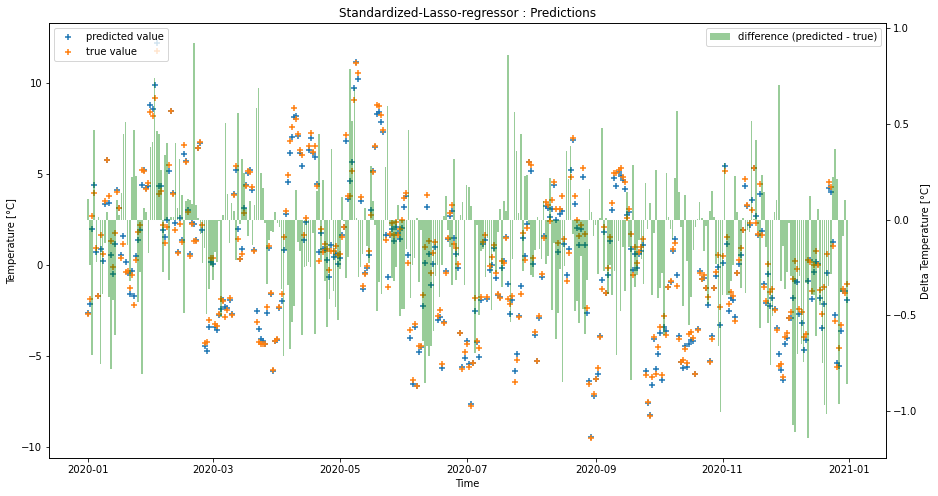

In [124]:
# Predictions from the model
y_pred_lasso_std = gs_results_lasso_std.best_estim.predict(X_to_predict_enc)

# Predictions score (Model performance for the predictions)
MAE_pred_lasso_std = model_error(y_to_predict, y_pred_lasso_std)
print('Standardized-Lasso-regressor: MAE score for predictions: {:.2f} degrees'.format(MAE_pred_lasso_std))

# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_lasso_std, 'Standardized-Lasso-regressor')

##### **E.2.4 RandomForest-Regression**

In [125]:
from sklearn.ensemble import RandomForestRegressor

RandomForestRegressor-regressor: Test set - MAE score: 0.51 degrees


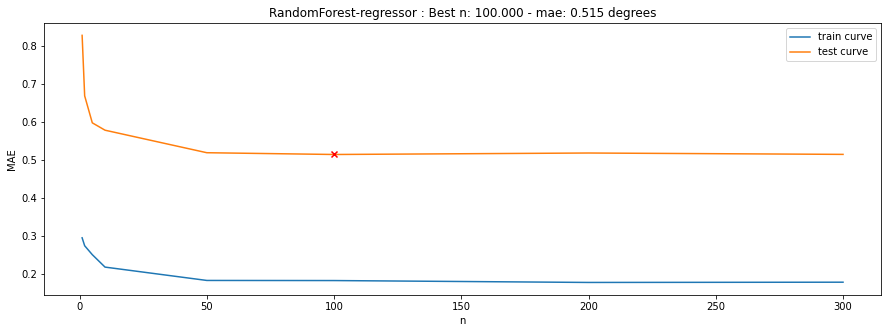

In [126]:
gs_rf_range = [1, 2, 5, 10, 50, 100, 200, 300]
gs_results_rf = ML_modelize(None, RandomForestRegressor(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'n_estimators', gs_rf_range)
ML_plot_val_curves(gs_results_rf, 'RandomForest-regressor', 'n')

In [127]:
# Displays the score in function of the parameter value
gs_results_rf.df_res

gs_param  test_mae  test_mse  train_mae  train_mse
0         1  0.828415  1.089495   0.295326   0.399182
1         2  0.669066  0.739822   0.274439   0.231888
2         5  0.598073  0.536014   0.250941   0.144110
3        10  0.578683  0.509621   0.218210   0.088610
4        50  0.519379  0.433200   0.183082   0.058684
5       100  0.514731  0.419941   0.182789   0.057970
6       200  0.518617  0.422960   0.177814   0.054511
7       300  0.515014  0.411876   0.178471   0.054121

The model reaching the best score contains 300 trees. It is overfitting (low bias but high variance). A plateau seems to appears from around 100 trees. Let's refine the grid search around this number of estimators.

<span style="color:red">
Comparison with the original notebook: The optimized number of trees found in the original version is 300.
</span>

RandomForestRegressor-regressor: Test set - MAE score: 0.51 degrees


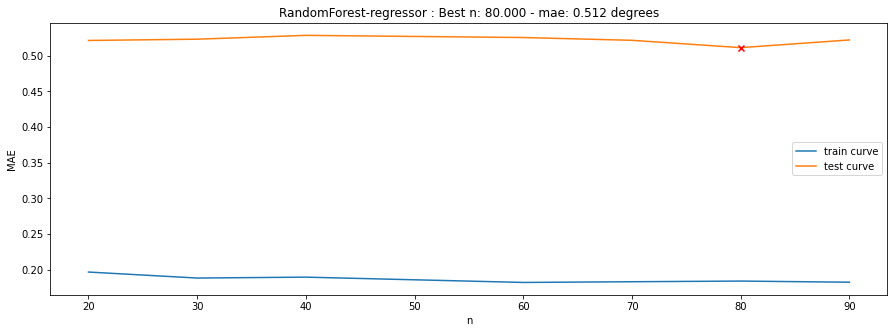

In [128]:
gs_rf_range2 = [20, 30, 40, 60, 70, 80, 90]
gs_results_rf2 = ML_modelize(None, RandomForestRegressor(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'n_estimators', gs_rf_range2)
ML_plot_val_curves(gs_results_rf2, 'RandomForest-regressor', 'n')

In [129]:
# Displays the score in function of the parameter value
gs_results_rf2.df_res

gs_param  test_mae  test_mse  train_mae  train_mse
0        20  0.521646  0.436280   0.196568   0.071545
1        30  0.523433  0.437302   0.188152   0.062550
2        40  0.528811  0.442982   0.189415   0.061450
3        60  0.525759  0.429587   0.181970   0.057242
4        70  0.521850  0.426892   0.182970   0.059249
5        80  0.511563  0.410185   0.183896   0.059105
6        90  0.522362  0.424962   0.182294   0.057463

<span style="color:red">
Comparison with the original notebook: The number of trees considered at the end in the original version is 70. The associated test score is 0.447.
</span>

Number of estimators : 70
RandomForestRegressor-regressor: Test set - MAE score: 0.52 degrees


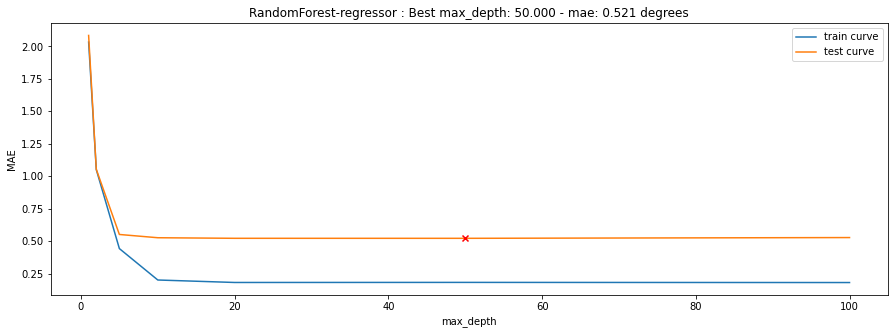

In [130]:
# best_rf_n = int(gs_results_rf2.df_best_res.gs_param)
best_rf_n = 70
print('Number of estimators :', best_rf_n)
gs_results_rf_depth = ML_modelize(None, RandomForestRegressor(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'max_depth', [1, 2, 5, 10, 20, 50, 100], n_estimators=best_rf_n)
ML_plot_val_curves(gs_results_rf_depth, 'RandomForest-regressor', 'max_depth')

The best score with the default depth (`max_depth=None`, meanning nodes are expanded until all leaves are pure or contain less than 2 samples) is similar. For the final comparison, let's set the number of trees to 70 and the maximal depth to 20.

In [131]:
gs_results_rf_ok = ML_modelize(None, RandomForestRegressor(), X_orig_tr_enc, X_orig_te_enc, y_tr, y_te, 'n_estimators', [70], max_depth=20)
# Model performance
MAE_te_rf = gs_results_rf_ok.df_best_res.test_mae
print('RandomForest-regressor : Test set - MAE score: {:.2f} degres'.format(MAE_te_rf))

RandomForestRegressor-regressor: Test set - MAE score: 0.52 degrees
RandomForest-regressor : Test set - MAE score: 0.52 degres


RandomForest-regressor: MAE score for predictions: 0.50 degrees


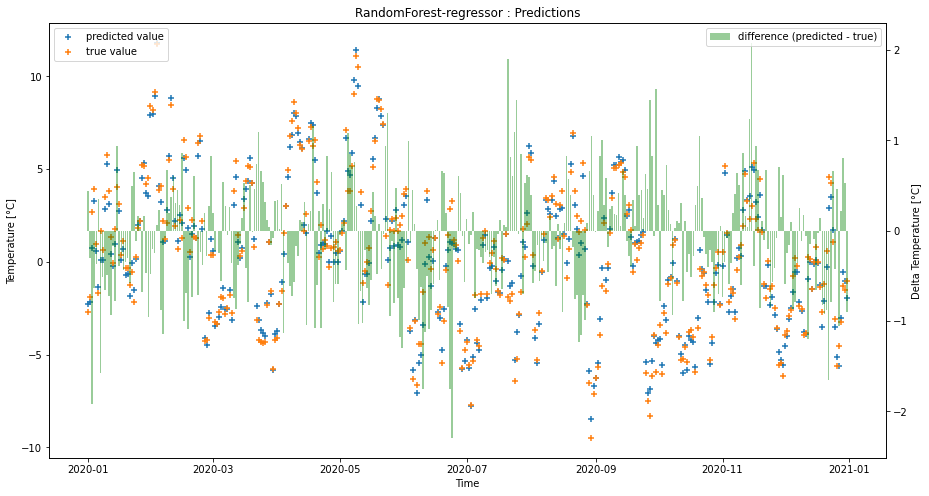

In [132]:
# Predictions from the model
y_pred_rf = gs_results_rf_ok.best_estim.predict(X_to_predict_enc)

# Predictions score (Model performance for the predictions)
MAE_pred_rf = model_error(y_to_predict, y_pred_rf)
print('RandomForest-regressor: MAE score for predictions: {:.2f} degrees'.format(MAE_pred_rf))

# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_rf, 'RandomForest-regressor')

#### **E.3. Intermediate comparison of ML models**

The Mean Absolute Error (MAE) will be used to compare the models. Mean Square Error (MSE) could also be used because no outliers seem to be present (which would have been a reason to use this latter).

Comparison of the models with a bar chart of the scores.

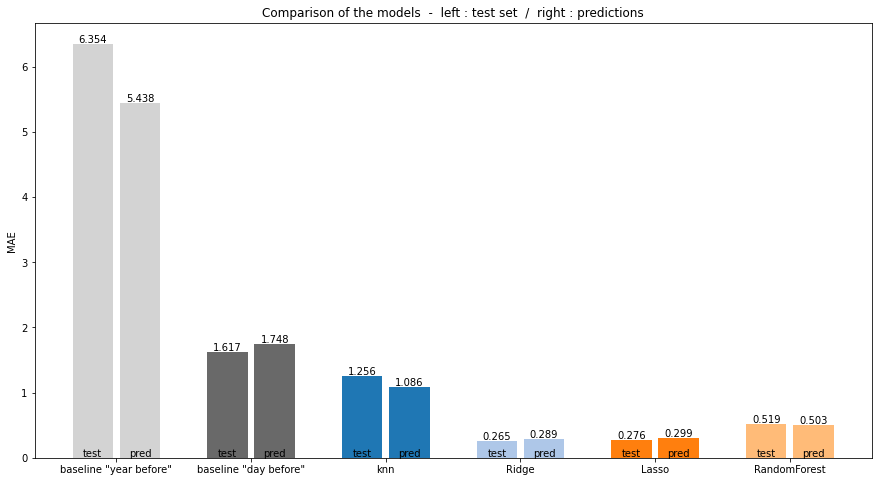

In [133]:
# scores
mae_te_values_mod = [MAE_te_baseline_y, MAE_te_baseline_1, MAE_te_knn, MAE_te_ridge_std, MAE_te_lasso_std, MAE_te_rf]
mae_pred_values_mod = [MAE_pred_baseline_y, MAE_pred_baseline_1, MAE_pred_knn, MAE_pred_ridge_std, MAE_pred_lasso_std, MAE_pred_rf]

# legend
mae_titles_mod = ['baseline "year before"', 'baseline "day before"', 'knn', 'Ridge', 'Lasso', 'RandomForest']

# colors
nb_mae_mod = len(mae_te_values_mod) # number of mae scores to plot
cmap = matplotlib.cm.get_cmap('tab20') # set a discrete colormap
mae_colors_mod = ['lightgrey', 'dimgrey'] +[cmap(i) for i in np.arange(nb_mae_mod)] # get color for each bar, two different greys for baselines

# plot
fig, ax = plt.subplots(figsize=(15,8)) # Size of the figure

width = .3
space = .05
xcor_te = np.arange(nb_mae_mod) - (width+space)/2
xcor_pred = np.arange(nb_mae_mod) + (width+space)/2
xcor = np.arange(nb_mae_mod)

plt.bar(xcor_te, mae_te_values_mod, width, color=mae_colors_mod)
plt.bar(xcor_pred, mae_pred_values_mod, width, color=mae_colors_mod)
plt.xticks(xcor, mae_titles_mod)

# display score values
for h_te, h_pred, v_te, v_pred in zip(xcor_te, xcor_pred, mae_te_values_mod, mae_pred_values_mod):
    ax.text(h_te, v_te + .02, str(round(v_te, 3)), horizontalalignment='center')
    ax.text(h_te, .02, 'test', horizontalalignment='center')
    ax.text(h_pred, v_pred + .02, str(round(v_pred, 3)), horizontalalignment='center')
    ax.text(h_pred, .02, 'pred', horizontalalignment='center')

plt.title('Comparison of the models  -  left : test set  /  right : predictions')
plt.ylabel('MAE')
plt.show()

<span style="color:red">
Comparison with the original notebook: Results are very similar, although a little worse in the adjusted version.
</span>

So far, the Ridge model gives the best results for the predictions (and also for the test set). This model (and its optimized hyperparameter) will be used to consider the various selections of variables. With this model, the standardization will be applied (to avoid ill-conditioned matrices).

Remark : As expected, the score on the test set is lower than the one for predictions in the Machine Learning models. The baselines do not *learn* from the the data and it turns out that the opposite arises for the baseline "day before".

#### **E.4. Modelisation with various selections of variables**

Remark : The best model obtained is the Standardized Ridge regressor with parameter $\alpha=1.262$. We could also have optimized the parameter for each selection to get even more precise results in order to reach better predictions. Another approach would have been to merge train and validation sets to get a new larger training set for the Standardized Ridge regressor on the whole set of variables and get an optimal value of the hyperparameter $\alpha$. Then, this (fixed) hyperparameter and new training sets (namely years 2015 - 2019 for each selection of variables) would have been used to train the model. That way, the predictions based on the various selections would have been even better...

However, we focus on the selections themself not to lose the thread of the presentation...

##### **E.4.1 Variables with the highest correlation with the temperature in Neuchâtel**

Let's consider the set containing the $n$ highest correlated variables with temperature, then train the Ridge regressor with the hyperparameter found above and finally compute the best score for $n=1, ..., 20$.

In [134]:
corr_y_tr_abs = corr_y_tr.abs().sort_values(ascending=False)

In [135]:
results_sel = []
for n_var in 1+np.arange(20):
    print(n_var, 'highest correlated variables : ')
    sel_var = corr_y_tr_abs.index[:n_var]
    X_orig_tr_sel = X_orig_tr_enc[sel_var].copy()
    X_orig_te_sel = X_orig_te_enc[sel_var].copy()
    X_pred_sel = X_to_predict_enc[sel_var].copy()

    # Run the Standardized-Ridge-regressor only with the best hyperparameter on the selected variables
    res_sel = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_sel, X_orig_te_sel, y_tr, y_te, 'alpha', [best_alpha_ridge_std]) # best_alpha_ridge_std: best hyperparameter
    # Predictions from the model
    y_pred_sel = res_sel.best_estim.predict(X_pred_sel)
    # Predictions score (Model performance for the predictions)
    MAE_pred_sel = model_error(y_to_predict, y_pred_sel)
    print('Ridge-regressor: MAE score for predictions: {:.2f} degrees'.format(MAE_pred_sel))

    results_sel.append({
            'n_var': n_var,
            'last_added_var': sel_var[-1],
            'test_mae':  res_sel.df_best_res.test_mae,
            'pred_mae':  MAE_pred_sel
        })
    
# Convert results to DataFrame
results_sel = pd.DataFrame(results_sel)
results_sel

1 highest correlated variables : 
Ridge-regressor: Test set - MAE score: 3.41 degrees
Ridge-regressor: MAE score for predictions: 3.07 degrees
2 highest correlated variables : 
Ridge-regressor: Test set - MAE score: 0.75 degrees
Ridge-regressor: MAE score for predictions: 0.67 degrees
3 highest correlated variables : 
Ridge-regressor: Test set - MAE score: 0.68 degrees
Ridge-regressor: MAE score for predictions: 0.63 degrees
4 highest correlated variables : 
Ridge-regressor: Test set - MAE score: 0.62 degrees
Ridge-regressor: MAE score for predictions: 0.57 degrees
5 highest correlated variables : 
Ridge-regressor: Test set - MAE score: 0.61 degrees
Ridge-regressor: MAE score for predictions: 0.57 degrees
6 highest correlated variables : 
Ridge-regressor: Test set - MAE score: 0.56 degrees
Ridge-regressor: MAE score for predictions: 0.52 degrees
7 highest correlated variables : 
Ridge-regressor: Test set - MAE score: 0.52 degrees
Ridge-regressor: MAE score for predictions: 0.48 degrees

last_added_var  n_var  pred_mae  test_mae
0            t_y1      1  3.070735  3.411468
1           t_BER      2  0.673078  0.747566
2           t_GVE      3  0.631148  0.684328
3           t_SMA      4  0.573348  0.616736
4           t_LUZ      5  0.571169  0.606780
5           t_PUY      6  0.522662  0.556174
6           t_SHA      7  0.475088  0.520972
7           t_BAS      8  0.478665  0.519856
8           t_SIO      9  0.480988  0.509182
9           t_STG     10  0.476493  0.498984
10          t_CHU     11  0.471571  0.487374
11          t_ENG     12  0.469099  0.487903
12          t_CDF     13  0.470106  0.479014
13          t_ALT     14  0.468773  0.481265
14      preci_SMA     15  0.468376  0.475204
15          t_ABO     16  0.466367  0.476325
16          t_DAV     17  0.462706  0.472443
17            t_1     18  0.463935  0.459229
18          t_OTL     19  0.468365  0.461114
19      preci_CHU     20  0.467370  0.462692

Plot the evolution of the score with respect to the selected variables.

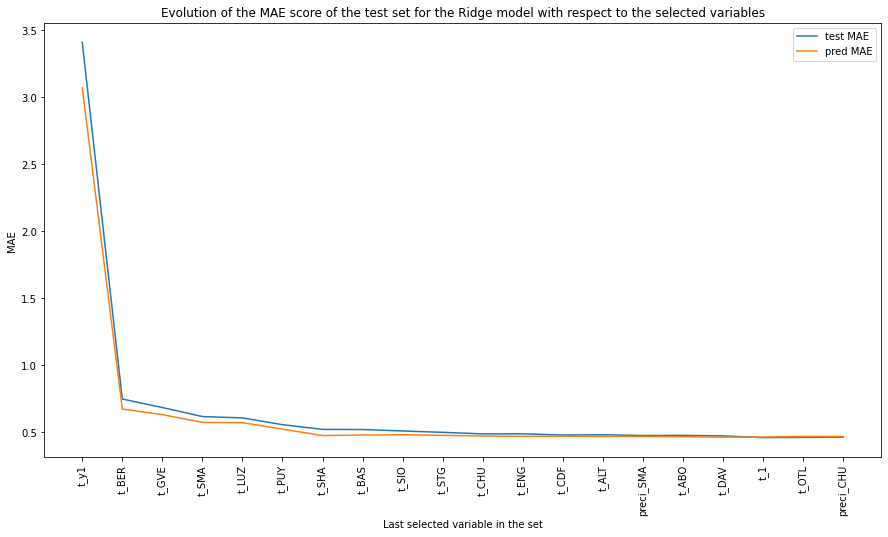

In [136]:
plt.figure(figsize=(15,8)) # Size of the figure

plt.plot(results_sel['n_var'], results_sel['test_mae'], label='test MAE')
plt.plot(results_sel['n_var'], results_sel['pred_mae'], label='pred MAE')

xcor = 1+np.arange(len(sel_var))
plt.xticks(xcor, sel_var, rotation='vertical')

plt.title('Evolution of the MAE score of the test set for the Ridge model with respect to the selected variables')
plt.xlabel('Last selected variable in the set')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [137]:
# Model performance for the Ridge-regressor over the 20 highest correlated variables with t.
MAE_te_sel_20_high_corr = results_sel.iloc[-1,:].loc['test_mae']
print('{}-regressor: Test set - MAE score: {:.2f} degrees'.format('Ridge_20_high_corr', MAE_te_sel_20_high_corr))    
MAE_pred_sel_20_high_corr = results_sel.iloc[-1,:].loc['pred_mae'] 
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_20_high_corr', MAE_pred_sel_20_high_corr))

Ridge_20_high_corr-regressor: Test set - MAE score: 0.46 degrees
Ridge_20_high_corr-regressor: MAE score for predictions: 0.47 degrees


<span style="color:red">
Comparison with the original notebook: Unlike the original version, not only 'temperature' variables are selected in the first 20 highly correlated variables. The 5 variables which decrease the most the score are t_LUG, t_SIO, t_GVE, t_PUY and t_SHA in the original version and the magnitude of the decline is greater. In this version we select ['t_y1', 't_BER', 't_SMA', 't_PUY', 't_SHA'].
</span>

Note that only 'temperature' variables are selected in the first 20 highly correlated variables. Let's select now the 5 variables which decrease the most the score. In the plot above, we can clearly determine them as `t_LUG`, `t_SIO`, `t_GVE`, `t_PUY` and `t_SHA`.

In [138]:
# New for the adjusted version
# sel_var2 = ['t_LUG', 't_SIO', 't_GVE', 't_PUY', 't_SHA']
sel_var2 = ['t_y1', 't_BER', 't_SMA', 't_PUY', 't_SHA']
X_orig_tr_sel2 = X_orig_tr_enc[sel_var2].copy()
X_orig_te_sel2 = X_orig_te_enc[sel_var2].copy()
X_pred_sel2 = X_to_predict_enc[sel_var2].copy()

# With the 5 selected variables
res_sel_5_high_corr = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_sel2, X_orig_te_sel2, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the 5 highest correlated variables with t which decrease the most the score.
MAE_te_sel_5_high_corr = model_error(y_te, res_sel_5_high_corr.y_te_pred)
# Predictions from the model
y_pred_sel_5_high_corr = res_sel_5_high_corr.best_estim.predict(X_pred_sel2)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_5_high_corr = model_error(y_to_predict, y_pred_sel_5_high_corr)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_5_high_corr', MAE_pred_sel_5_high_corr))

Ridge-regressor: Test set - MAE score: 0.54 degrees
Ridge_5_high_corr-regressor: MAE score for predictions: 0.48 degrees


The score obtained on the test set (about 0.54 degrees) is really near the score with the 20 selected variables above (about 0.46 degrees).

<span style="color:red">
Comparison with the original notebook: The scores are similar (original 0.44, adjusted 0.54).
</span>

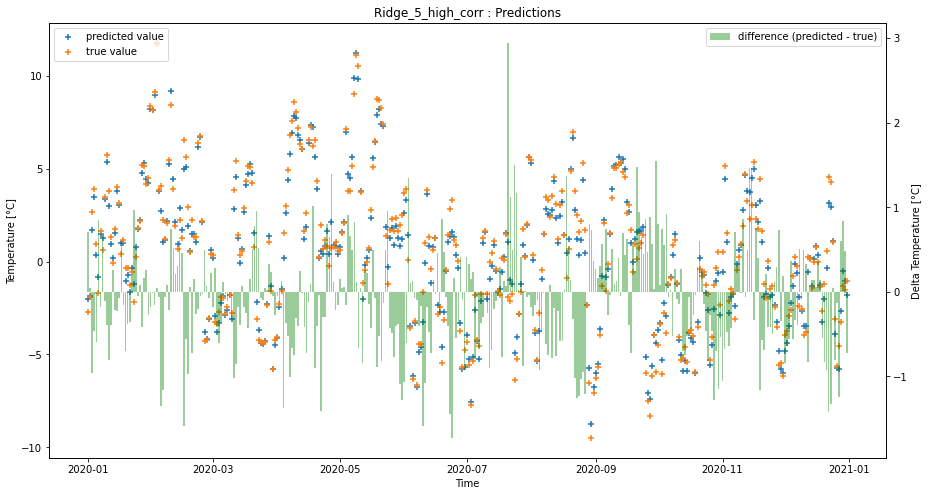

In [139]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_5_high_corr, 'Ridge_5_high_corr')

##### **E.4.2 Variables selected with SelectKBest**

In the Principal Component Analysis (section D.2), 5 variables were selected with SelectKBest.

In [140]:
var_skb_meas

Index(['t_1', 'sunshine', 'radiation', 'humidity', 'pressure'], dtype='object')

Let's compute the score for these 5 selected variables and plot the associated predictions.

In [141]:
# select the variables
X_orig_tr_skb = X_orig_tr_enc[var_skb_meas].copy()
X_orig_te_skb = X_orig_te_enc[var_skb_meas].copy()
X_pred_skb = X_to_predict_enc[var_skb_meas].copy()

In [142]:
# Without preprocessed standardization
res_sel_skb = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_skb, X_orig_te_skb, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the selected variables with selectKBest.
MAE_te_sel_skb = model_error(y_te, res_sel_skb.y_te_pred)
# Predictions from the model
y_pred_sel_skb = res_sel_skb.best_estim.predict(X_pred_skb)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_skb = model_error(y_to_predict, y_pred_sel_skb)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_skb', MAE_pred_sel_skb))

Ridge-regressor: Test set - MAE score: 1.45 degrees
Ridge_skb-regressor: MAE score for predictions: 1.46 degrees


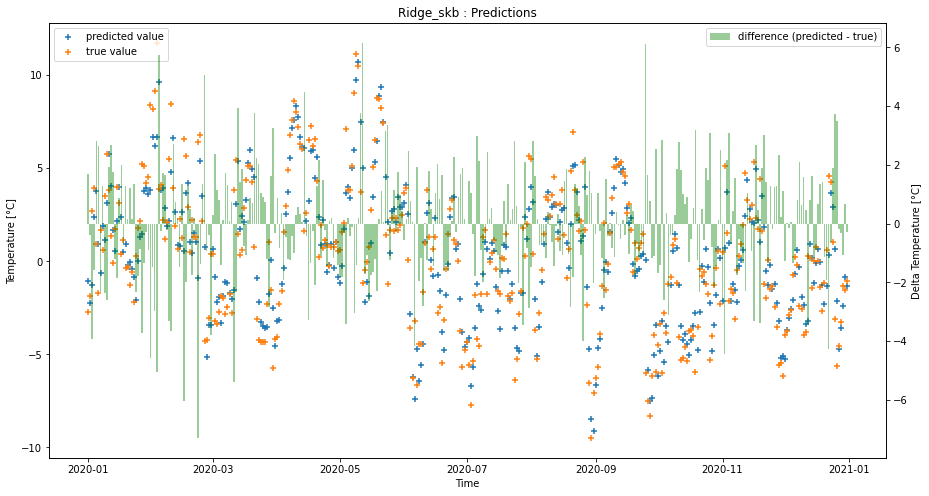

In [143]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_skb, 'Ridge_skb')

<span style="color:red">
Comparison with the original notebook: The scores are similar (original 1.36, adjusted 1.45).
</span>

##### **E.4.3 Geographical nearest neighbour model**

##### **E.4.3.1 A single geographical nearest neighbour**

Let's compute the score for set containing only the data of the nearest neighbour of Neuchatel, namely `CDF`, and plot the associated predictions.

In [144]:
# select the variables
NEU_neigh = df_stn_ok.loc[df_stn_ok.stn=='NEU', 'neighbour_0'].iloc[0]
NEU_neigh_station = df_stn_ok.loc[df_stn_ok.stn==NEU_neigh, 'station'].iloc[0]
print('Nearest geographical neighbour of Neuchatel : {} ({})'.format(NEU_neigh_station, NEU_neigh))

neigh_var = list(X_orig_tr_enc.columns[[var[-3:]==NEU_neigh for var in X_orig_tr_enc.columns]])
sel_neigh_var = neigh_var + ['year', 'month', 'day', 'season', 'time']
X_orig_tr_neigh = X_orig_tr_enc[sel_neigh_var].copy()
X_orig_te_neigh = X_orig_te_enc[sel_neigh_var].copy()
X_pred_neigh = X_to_predict_enc[sel_neigh_var].copy()

Nearest geographical neighbour of Neuchatel : La Chaux-de-Fonds (CDF)


In [145]:
# Without preprocessed standardization
res_sel_neigh = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_neigh, X_orig_te_neigh, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the neigbour's variables.
MAE_te_sel_neigh = model_error(y_te, res_sel_neigh.y_te_pred)
# Predictions from the model
y_pred_sel_neigh = res_sel_neigh.best_estim.predict(X_pred_neigh)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_neigh = model_error(y_to_predict, y_pred_sel_neigh)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_geo_nn', MAE_pred_sel_neigh))

Ridge-regressor: Test set - MAE score: 1.21 degrees
Ridge_geo_nn-regressor: MAE score for predictions: 1.17 degrees


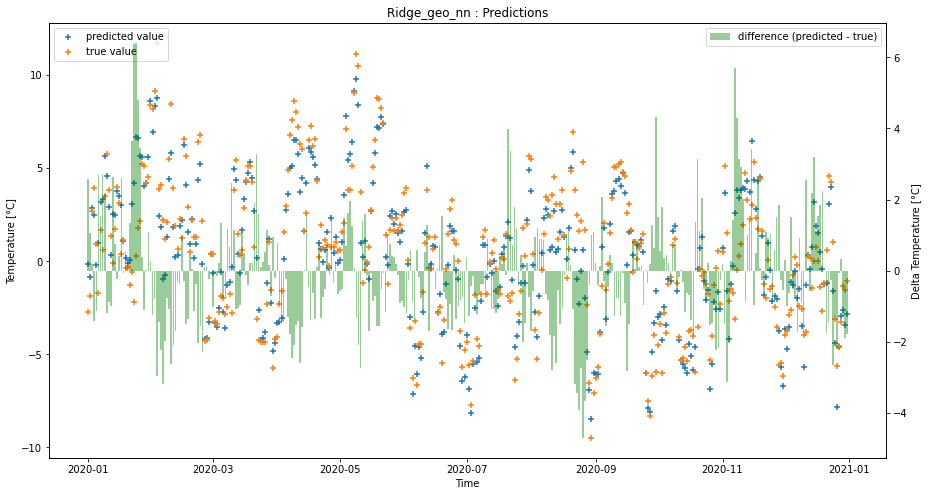

In [146]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_neigh, 'Ridge_geo_nn')

The score of this model is better than the previous one computed with the data available in Neuchatel (test 1.21, predictions 1.17 vs 1.45 and 1.46). It means that the temperature the same day in another (near) location gives more information than the most correlated variables in the place where the temperature has to be predicted.

<span style="color:red">
Comparison with the original notebook: The scores are similar (original 1.03, 1.13, adjusted 1.21, 1.17).
</span>

##### **E.4.3.2 Three geographical nearest neighbours**

Let's compute the score for set containing only the data of the 3 nearest neighbours of Neuchatel, namely `CDF`, `BER`and `PUY`, and plot the associated predictions.

In [147]:
# select the variables

neighs_var = []
for i in np.arange(number_of_nn):
    NEU_neigh_i = df_stn_ok.loc[df_stn_ok.stn=='NEU', 'neighbour_'+str(i)].iloc[0]
    NEU_neigh_station_i = df_stn_ok.loc[df_stn_ok.stn==NEU_neigh_i, 'station'].iloc[0]
    print('{}-th Nearest geographical neighbour of Neuchatel : {} ({})'.format(1+i, NEU_neigh_station_i, NEU_neigh_i))
    neighs_var = neighs_var + list(X_orig_tr_enc.columns[[var[-3:]==NEU_neigh_i for var in X_orig_tr_enc.columns]])

sel_neighs_var = neighs_var + ['year', 'month', 'day', 'season', 'time']
X_orig_tr_neighs = X_orig_tr_enc[sel_neighs_var].copy()
X_orig_te_neighs = X_orig_te_enc[sel_neighs_var].copy()
X_pred_neighs = X_to_predict_enc[sel_neighs_var].copy()

1-th Nearest geographical neighbour of Neuchatel : La Chaux-de-Fonds (CDF)
2-th Nearest geographical neighbour of Neuchatel : Bern / Zollikofen (BER)
3-th Nearest geographical neighbour of Neuchatel : Pully (PUY)


In [148]:
# Without preprocessed standardization
res_sel_neighs = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_neighs, X_orig_te_neighs, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the 3 neighbours' variables.
MAE_te_sel_neighs = model_error(y_te, res_sel_neighs.y_te_pred)
# Predictions from the model
y_pred_sel_neighs = res_sel_neighs.best_estim.predict(X_pred_neighs)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_neighs = model_error(y_to_predict, y_pred_sel_neighs)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_3geo_nn', MAE_pred_sel_neighs))

Ridge-regressor: Test set - MAE score: 0.54 degrees
Ridge_3geo_nn-regressor: MAE score for predictions: 0.52 degrees


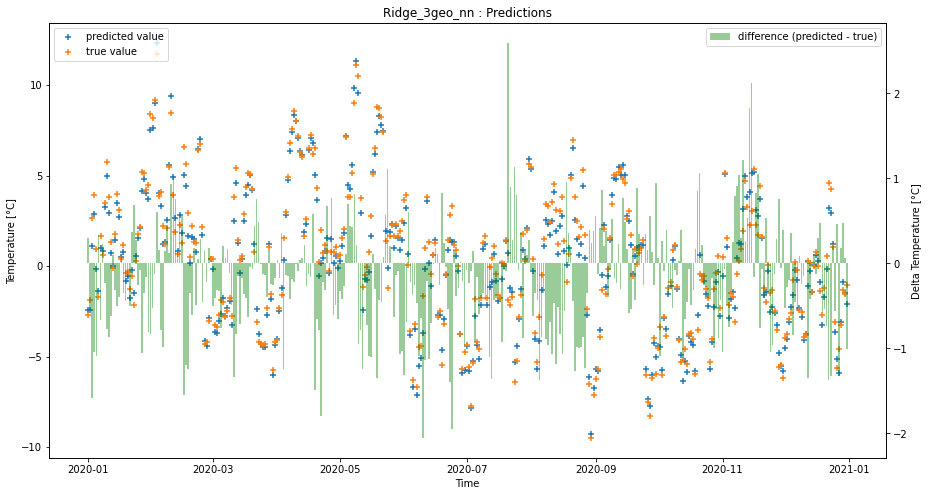

In [149]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_neighs, 'Ridge_3geo_nn')

With the nearest 3 neighbours, predictions are quite better (test 0.54, predictions 0.52 vs 1.21 and 1.17). Note that the neighbours are *well* distributed around Neuchâtel geographically. But they are not the stations with the highest correlated temperature (BER, GVE, SMA).

<span style="color:red">
Comparison with the original notebook: The scores are similar (original 0.4, 0.44, adjusted 0.54, 0.52).
</span>

##### **E.4.4 Measurements in Neuchatel only**

Let's compute the score for set containing only the measurements in Neuchatel.

In [150]:
# select the variables
# var_meas = ['humidity', 'precipitation', 'pressure', 'sunshine', 'radiation']
sel_NEU_var = var_meas + ['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_y1', 't_mean7'] + ['year', 'month', 'day', 'season', 'time']
X_orig_tr_NEU = X_orig_tr_enc[sel_NEU_var].copy()
X_orig_te_NEU = X_orig_te_enc[sel_NEU_var].copy()
X_pred_NEU = X_to_predict_enc[sel_NEU_var].copy()

In [151]:
# Without preprocessed standardization
res_sel_NEU = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_NEU, X_orig_te_NEU, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the variables of NEU.
MAE_te_sel_NEU = model_error(y_te, res_sel_NEU.y_te_pred)
# Predictions from the model
y_pred_sel_NEU = res_sel_NEU.best_estim.predict(X_pred_NEU)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_NEU = model_error(y_to_predict, y_pred_sel_NEU)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_NEU', MAE_pred_sel_NEU))

Ridge-regressor: Test set - MAE score: 1.43 degrees
Ridge_NEU-regressor: MAE score for predictions: 1.43 degrees


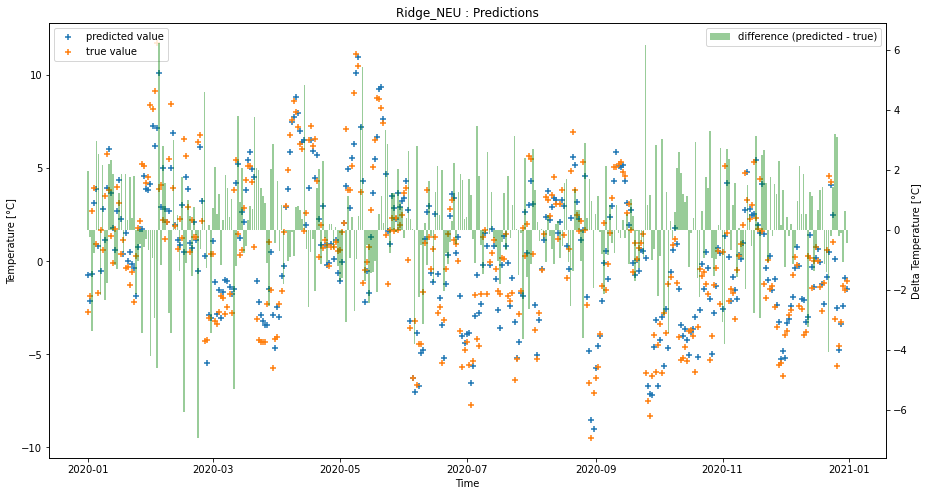

In [152]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_NEU, 'Ridge_NEU')

The score of this model is worse than the one computed with the measurements in Neuchatel (test 1.43, predictions 1.41 vs 1.21, 1.17). It means that the temperature the same day in another (near) location gives more information than the measurements in the place where the temperature has to be predicted.

<span style="color:red">
Comparison with the original notebook: The scores are similar (original 1.32, 1.36, adjusted 1.43, 1.41).
</span>

##### **E.4.5 Without temperature variants**

##### **E.4.5.1 Without any temperature measurement in Neuchatel**

This corresponds to the "new station problem" mentioned at the beginning of the project.

In [153]:
# select the variables
sel_var_wo_t_NEU = list(X_orig_tr_enc.columns[[var not in ['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_y1', 't_mean7', 't_adj'] for var in X_orig_tr_enc.columns]])

X_orig_tr_wo_t_NEU = X_orig_tr_enc[sel_var_wo_t_NEU].copy()
X_orig_te_wo_t_NEU = X_orig_te_enc[sel_var_wo_t_NEU].copy()
X_pred_wo_t_NEU = X_to_predict_enc[sel_var_wo_t_NEU].copy()

In [154]:
# Without preprocessed standardization
res_sel_wo_t_NEU = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_wo_t_NEU, X_orig_te_wo_t_NEU, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the variables of NEU without t.
MAE_te_sel_wo_t_NEU = model_error(y_te, res_sel_wo_t_NEU.y_te_pred)
# Predictions from the model
y_pred_sel_wo_t_NEU = res_sel_wo_t_NEU.best_estim.predict(X_pred_wo_t_NEU)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_wo_t_NEU = model_error(y_to_predict, y_pred_sel_wo_t_NEU)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_wo_t_NEU', MAE_pred_sel_wo_t_NEU))

Ridge-regressor: Test set - MAE score: 0.27 degrees
Ridge_wo_t_NEU-regressor: MAE score for predictions: 0.29 degrees


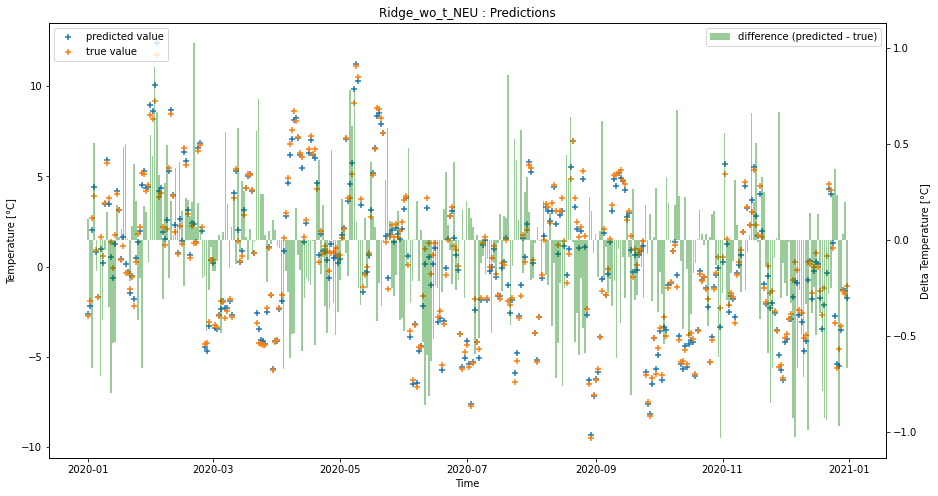

In [155]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_wo_t_NEU, 'Ridge_wo_t_NEU')

The score for the "new station problem" is similar to the one obtained for the "technical problem" (test 0.27, predictions 0.29 vs 0.265 and 0.289).

<span style="color:red">
Comparison with the original notebook: The scores are very similar (original 0.24, 0.28, adjusted 0.27, 0.29).
</span>

##### **E.4.5.2 Without any temperature measurement on D-day (only lags are considered)**

This corresponds to the problem of guessing the temperature on next day ("prediction problem") mentioned at the beginning of the project.

In [156]:
# select the variables
var_wo_t = list(X_orig_tr_enc.columns[[var[:2]!='t_' for var in X_orig_tr_enc.columns]]) # without temperature variables at all
# list(X_orig_tr_enc.columns[~X_orig_tr_enc.columns.str.startswith('t_')])
sel_var_lags = var_wo_t + ['t_1', 't_2', 't_3', 't_4', 't_5', 't_6', 't_7', 't_y1', 't_mean7']

In [157]:
# select the variables
X_orig_tr_lags = X_orig_tr_enc[sel_var_lags].copy()
X_orig_te_lags = X_orig_te_enc[sel_var_lags].copy()
X_pred_lags = X_to_predict_enc[sel_var_lags].copy()

In [158]:
# Without preprocessed standardization
res_sel_lags = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_lags, X_orig_te_lags, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the variables without t but lags.
MAE_te_sel_lags = model_error(y_te, res_sel_lags.y_te_pred)
# Predictions from the model
y_pred_sel_lags = res_sel_lags.best_estim.predict(X_pred_lags)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_lags = model_error(y_to_predict, y_pred_sel_lags)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_lags', MAE_pred_sel_lags))

Ridge-regressor: Test set - MAE score: 0.78 degrees
Ridge_lags-regressor: MAE score for predictions: 0.76 degrees


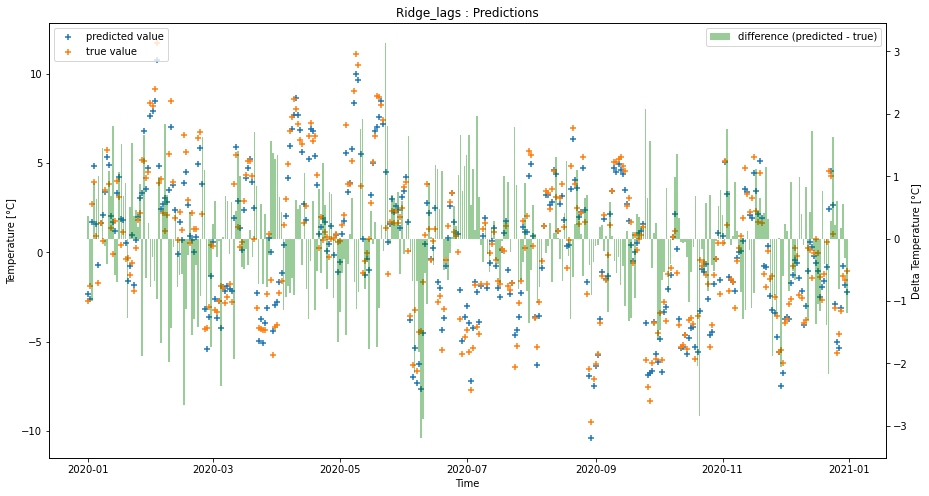

In [159]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_lags, 'Ridge_lags')

For this "prediction problem", the score are significantly higher than for the other two,namely the "new station" and "technical problem" (test 0.78, predictions 0.76 vs 0.265 and 0.289).

<span style="color:red">
Comparison with the original notebook: The scores are similar (original 0.71, 0.66, adjusted 0.78, 0.76).
</span>

##### **E.4.5.3 Without any temperature measurement at all**

In [160]:
# select the variables
X_orig_tr_wo_t_tot = X_orig_tr_enc[var_wo_t].copy()
X_orig_te_wo_t_tot = X_orig_te_enc[var_wo_t].copy()
X_pred_wo_t_tot = X_to_predict_enc[var_wo_t].copy()

In [161]:
# Without preprocessed standardization
res_sel_wo_t_tot = ML_modelize(StandardScaler(), Ridge(), X_orig_tr_wo_t_tot, X_orig_te_wo_t_tot, y_tr, y_te, 'alpha', [best_alpha_ridge_std])
# Model performance for the Ridge-regressor over the variables without t at all.
MAE_te_sel_wo_t_tot = model_error(y_te, res_sel_wo_t_tot.y_te_pred)
# Predictions from the model
y_pred_sel_wo_t_tot = res_sel_wo_t_tot.best_estim.predict(X_pred_wo_t_tot)
# Predictions score (Model performance for the predictions)
MAE_pred_sel_wo_t_tot = model_error(y_to_predict, y_pred_sel_wo_t_tot)
print('{}-regressor: MAE score for predictions: {:.2f} degrees'.format('Ridge_wo_t_tot', MAE_pred_sel_wo_t_tot))

Ridge-regressor: Test set - MAE score: 0.85 degrees
Ridge_wo_t_tot-regressor: MAE score for predictions: 0.77 degrees


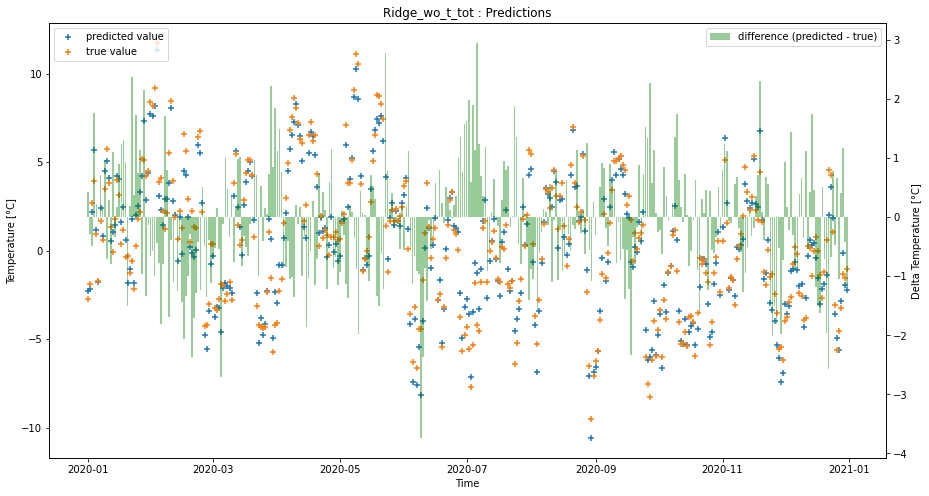

In [162]:
# Plot of the predictions
ML_plot_predictions(time_to_predict, y_to_predict, y_pred_sel_wo_t_tot, 'Ridge_wo_t_tot')

<span style="color:red">
Comparison with the original notebook: The scores are similar (original 0.74, 0.68, adjusted 0.85, 0.77).
</span>

#### **E.5. Intermediate comparison of variables selections**

As for th comparison of the ML models (Section E.3) , the Mean Absolute Error (MAE) will be used to compare the models based on the selections of variables presented above.

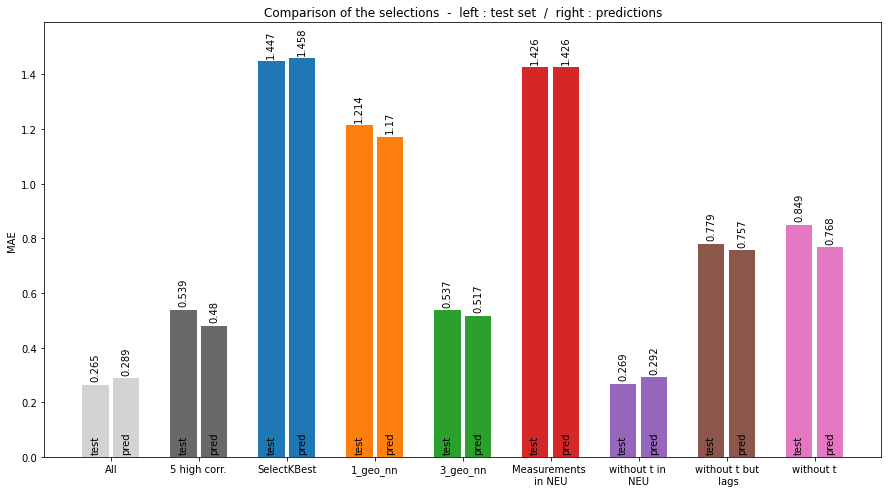

In [163]:
import re # Module used to display xticks labels on multiple lines.

# scores
mae_te_values_var = [MAE_te_ridge_std, MAE_te_sel_5_high_corr, MAE_te_sel_skb, MAE_te_sel_neigh, MAE_te_sel_neighs, MAE_te_sel_NEU, MAE_te_sel_wo_t_NEU, MAE_te_sel_lags, MAE_te_sel_wo_t_tot]
mae_pred_values_var = [MAE_pred_ridge_std, MAE_pred_sel_5_high_corr, MAE_pred_sel_skb, MAE_pred_sel_neigh, MAE_pred_sel_neighs, MAE_pred_sel_NEU, MAE_pred_sel_wo_t_NEU, MAE_pred_sel_lags, 
                       MAE_pred_sel_wo_t_tot]

# legend
mae_titles_var = ['All', '5 high corr.', 'SelectKBest', '1_geo_nn', '3_geo_nn', 'Measurements in NEU', 'without t in NEU', 'without t but lags', 'without t']

# colors
nb_mae_var = len(mae_te_values_var) # number of mae scores to plot
cmap = matplotlib.cm.get_cmap('tab10') # set a discrete colormap
mae_colors_var = ['lightgrey', 'dimgrey'] +[cmap(i) for i in np.arange(nb_mae_var)] # get color for each bar, two different greys for baselines

# plot
fig, ax = plt.subplots(figsize=(15,8)) # Size of the figure

width = .3
space = .05
xcor_te = np.arange(nb_mae_var) - (width+space)/2
xcor_pred = np.arange(nb_mae_var) + (width+space)/2
xcor = np.arange(nb_mae_var)

plt.bar(xcor_te, mae_te_values_var, width, color=mae_colors_var)
plt.bar(xcor_pred, mae_pred_values_var, width, color=mae_colors_var)

xlabels = [re.sub("(.{13})", "\\1\n", label, 0, re.DOTALL) for label in mae_titles_var] # to split the x_labels after 13 characters
plt.xticks(xcor, xlabels)
# plt.xticks(xcor, mae_titles_var)

# display score values
for h_te, h_pred, v_te, v_pred in zip(xcor_te, xcor_pred, mae_te_values_var, mae_pred_values_var):
    ax.text(h_te, v_te + .02, str(round(v_te, 3)), horizontalalignment='center', rotation=90)
    ax.text(h_te, .02, 'test', horizontalalignment='center', rotation=90)
    ax.text(h_pred, v_pred + .02, str(round(v_pred, 3)), horizontalalignment='center', rotation=90)
    ax.text(h_pred, .02, 'pred', horizontalalignment='center', rotation=90)
ax.set_ylim(top=1.59)
plt.title('Comparison of the selections  -  left : test set  /  right : predictions')
plt.ylabel('MAE')
plt.show()


Comparison with the original notebook: The scores are similar (original 0.74, 0.68, adjusted 0.85, 0.77).


Remarks on the predictions scores:
- The selection without the temperature in Neuchatel 'without t in NEU' is quite near of the complete model;
- The nearest neighbour selections indicate that 3 stations give a quite good prediction. It could be interesting to see the evolution of the score depending on the number of nearest neighbours considered;
- The information given by the other stations is really helpful ('Measurements in NEU' has a score of 1.426 compared to 0.289 for the complete model) <span style="color:red">(resp. 1.363, 0.276 for the original version)</span>;
- The score  of the model based on the nearest neighbour ('1_geo_nn', score 1.17) is better than the one computed with the measurements in Neuchatel ('Measurements in NEU', score 1.426)<span style="color:red">(resp. 1.13, 1.36 for the original version)</span>;
- Temperature lags add no significantly information compared to the model without temperature at all. This is visible by comparing 'All' and 'without t in NEU' scores (difference 0.004) on the first hand, and 'without t but lags' and 'without t' scores (difference 0.011) on the other hand<span style="color:red">(resp. 0.001, 0.021 for the original version)</span>;
- The "prediction problem" ('without t but lags', score 0.757) is quite more complicated than the "technical problem" ('All', score 0.289)<span style="color:red">(resp. 0.658, 0.276 for the original version)</span>.
- The "new station problem" ('without t in NEU', score 0.292) is really near of the "technical problem" ('All', score 0.289), meanning that the knowledge of previous temperatures in a station does not inform very much<span style="color:red">(resp. 0.277, 0.276 for the original version)</span>.

#### **E.6. Final comparison**

For the sake of completeness, let's display all the scores together (models and variables selections) in a bar chart and compare the time series of the difference between the predicted and the real value for each model.

Comparison of the models with a bar chart of the scores.

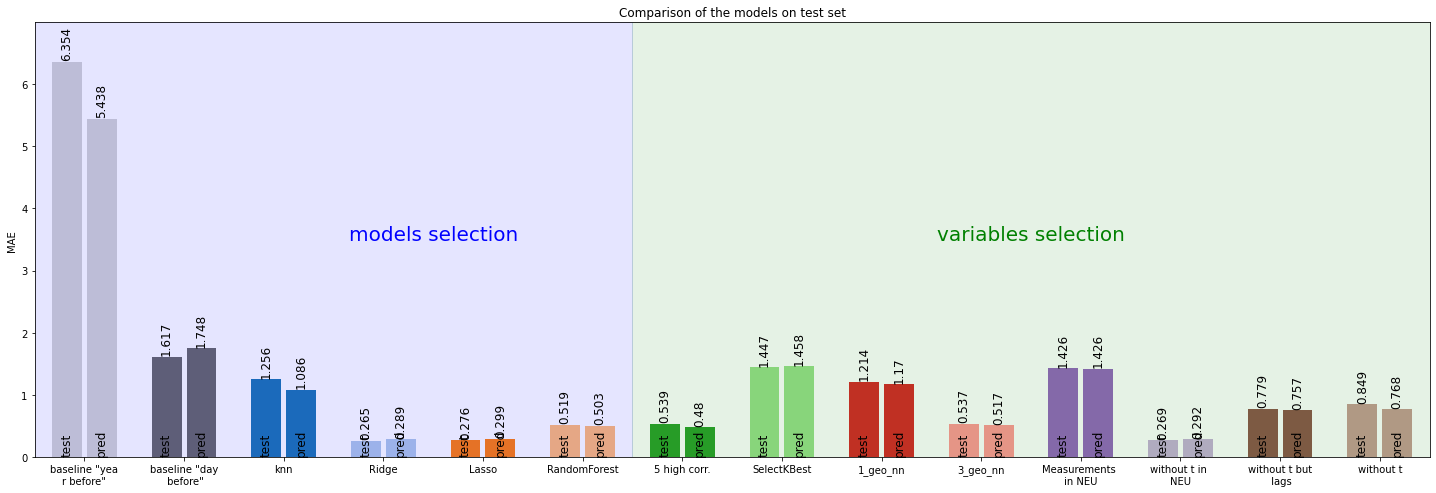

In [164]:
# scores
mae_te_values_tot = mae_te_values_mod + mae_te_values_var[1:] 
mae_pred_values_tot = mae_pred_values_mod + mae_pred_values_var[1:] 

# legend
mae_titles_tot = mae_titles_mod + mae_titles_var[1:] 

# colors
nb_mae_tot = len(mae_te_values_tot) # number of mae scores to plot
cmap = matplotlib.cm.get_cmap('tab20') # set a discrete colormap
mae_colors_tot = ['lightgrey', 'dimgrey'] +[cmap(i) for i in np.arange(nb_mae_tot)] # get color for each bar, two different greys for baselines

# plot
fig, ax = plt.subplots(figsize=(25,8)) # Size of the figure
width = .3
space = .05
xcor_te = np.arange(nb_mae_tot) - (width+space)/2
xcor_pred = np.arange(nb_mae_tot) + (width+space)/2
xcor = np.arange(nb_mae_tot)

plt.bar(xcor_te, mae_te_values_tot, width, color=mae_colors_tot)
plt.bar(xcor_pred, mae_pred_values_tot, width, color=mae_colors_tot)

xlabels = [re.sub("(.{13})", "\\1\n", label, 0, re.DOTALL) for label in mae_titles_tot] # to split the x_labels after 13 characters
plt.xticks(xcor, xlabels)
# plt.xticks(xcor, mae_titles_var)

# display score values
margin = .07
for h_te, h_pred, v_te, v_pred in zip(xcor_te, xcor_pred, mae_te_values_tot, mae_pred_values_tot):
    ax.text(h_te, v_te + margin, str(round(v_te, 3)), horizontalalignment='center', rotation=90, size=12)
    ax.text(h_te, margin, 'test', horizontalalignment='center', rotation=90, size=12)
    ax.text(h_pred, v_pred + margin, str(round(v_pred, 3)), horizontalalignment='center', rotation=90, size=12)
    ax.text(h_pred, margin, 'pred', horizontalalignment='center', rotation=90, size=12)
ax.set_ylim(top=6.99)
plt.title('Comparison of the selections  -  left : test set  /  right : predictions')
plt.ylabel('MAE')


# display "models selection zone"
start, end = -0.5, len(mae_te_values_mod) - .5
ax.axvspan(start, end, alpha=.1, color='blue')
trans = ax.get_xaxis_transform()
ax.text((start + end) / 2 + 1, .5, 'models selection', c='blue', size=20, horizontalalignment='center', transform=trans)

# display "variables selections zone"
start, end = len(mae_te_values_mod) - .5 , len(mae_te_values_tot) - .5 
ax.axvspan(start, end, alpha=.1, color='green')
trans = ax.get_xaxis_transform()
ax.text((start + end) / 2, .5, 'variables selection', c='green', size=20, horizontalalignment='center', transform=trans)

ax.set_xlim(xmin=-0.5, xmax=len(mae_te_values_tot) - .5)
    
plt.ylabel('MAE')
plt.title('Comparison of the models on test set')
plt.show()

Comparison of the models by plotting the time series of the difference between the predicted and the real value for each model.

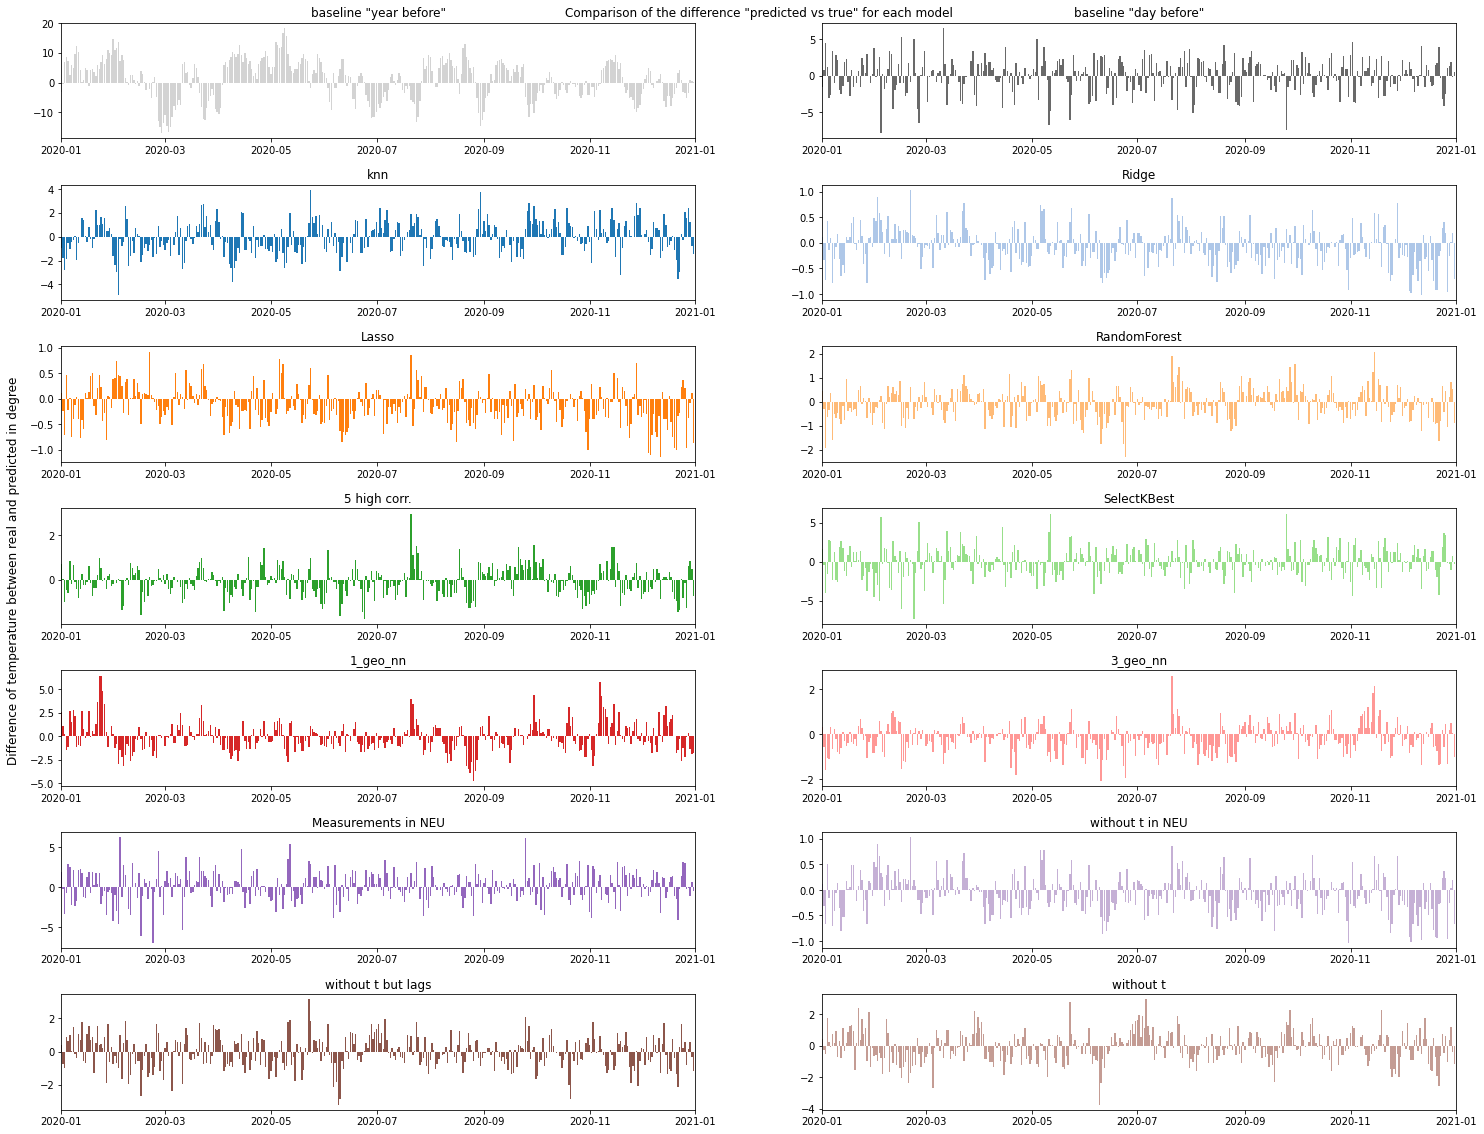

In [165]:
# differences
tot_text = ['knn', 'ridge_std', 'lasso_std', 'rf_ok', 'sel_5_high_corr', 'sel_skb', 'sel_neigh', 'sel_neighs', 'sel_NEU', 'sel_wo_t_NEU', 'sel_lags', 'sel_wo_t_tot']

delta_y_pred_knn= y_pred_knn - y_to_predict
delta_y_pred_ridge_std= y_pred_ridge_std - y_to_predict
delta_y_pred_lasso_std= y_pred_lasso_std - y_to_predict
delta_y_pred_rf= y_pred_rf - y_to_predict
delta_y_pred_sel_5_high_corr= y_pred_sel_5_high_corr - y_to_predict
delta_y_pred_sel_skb= y_pred_sel_skb - y_to_predict
delta_y_pred_sel_neigh= y_pred_sel_neigh - y_to_predict
delta_y_pred_sel_neighs= y_pred_sel_neighs - y_to_predict
delta_y_pred_sel_NEU= y_pred_sel_NEU - y_to_predict
delta_y_pred_sel_wo_t_NEU= y_pred_sel_wo_t_NEU - y_to_predict
delta_y_pred_sel_lags= y_pred_sel_lags - y_to_predict
delta_y_pred_sel_wo_t_tot= y_pred_sel_wo_t_tot - y_to_predict

deltas = [delta_y_pred_baseline_y, delta_y_pred_baseline_1, delta_y_pred_knn, delta_y_pred_ridge_std, delta_y_pred_lasso_std, delta_y_pred_rf, 
          delta_y_pred_sel_5_high_corr, delta_y_pred_sel_skb, delta_y_pred_sel_neigh, delta_y_pred_sel_neighs, delta_y_pred_sel_NEU, delta_y_pred_sel_wo_t_NEU, 
          delta_y_pred_sel_lags, delta_y_pred_sel_wo_t_tot]


fig = plt.figure(figsize=(25, 20))
fig.subplots_adjust(hspace=0.4)

plt.title('Comparison of the difference "predicted vs true" for each model')
plt.box(on=None)
plt.axis('off')

for mod in np.arange(len(deltas)):
    ax = fig.add_subplot(7, 2, mod + 1)
    ax.bar(time_to_predict, deltas[mod], label=mae_titles_tot[mod], color=mae_colors_tot[mod])
    ax.set_xlim(xmin='2020-01-01', xmax='2021-01-01')
    plt.title(mae_titles_tot[mod])
#     plt.ylabel('Difference of temperature in degree')
    
fig.text(0.095, 0.5, 'Difference of temperature between real and predicted in degree', verticalalignment='center', rotation='vertical', size=12) # ylabel trick
plt.show()

Remarks:
- As indicated by the scores, the baseline "year before" is noticeably worse thant the other models (see the y-axis scale).
- The baseline "year before" shows that some periods of several days were warmer/cooler than year before;
- No model has a typical pattern (e.g. rather warmer temperatures during the first half of year, and rather cooler for the second half, ...).
- Temperatures in March seem to be overvalued by several models (Ridge, Lasso, and to a lesser extent, RandomForest).

For this latter remark, let's display the predictions on March (and drop the kNN model which is less efficient).

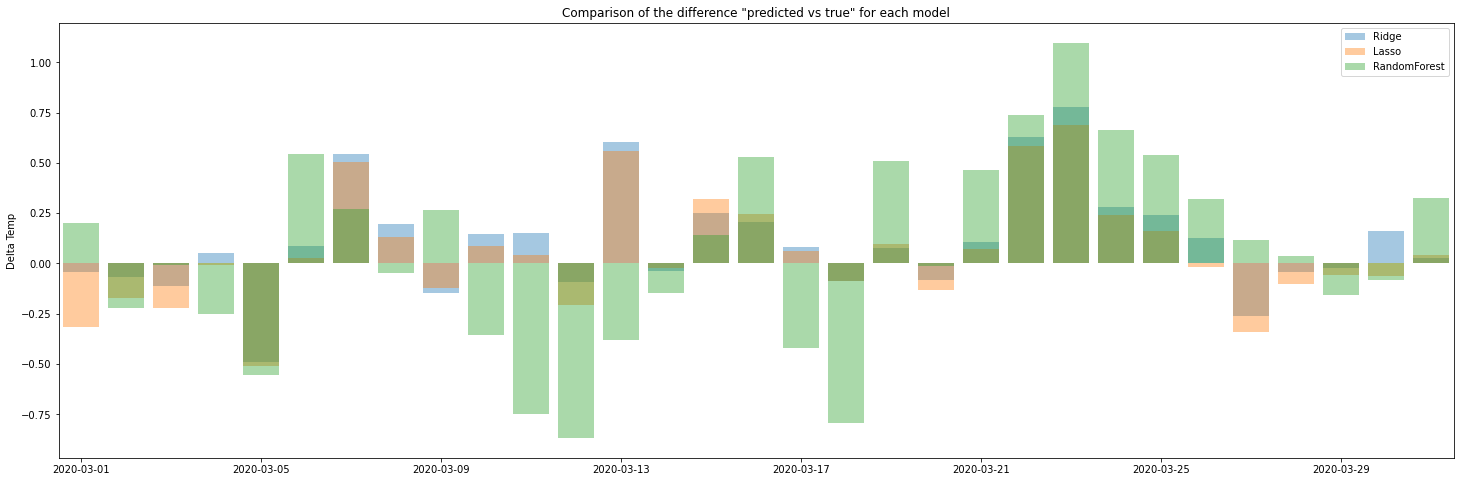

In [166]:
# Focus on Ridge, Lasso and Random Forest models
deltas_sel = [delta_y_pred_ridge_std, delta_y_pred_lasso_std, delta_y_pred_rf]

cmap = matplotlib.cm.get_cmap('tab10') # set a discrete colormap
mae_colors_sel = [cmap(i) for i in np.arange(len(deltas_sel))] # get color for each bar, two different greys for baselines

# Bar plot
fig, ax = plt.subplots(figsize=(25,8)) # Size of the figure

# Focus on March 2020
time_flt = (time_to_predict>="2020-03-01") & (time_to_predict<"2020-04-01")

for mod in np.arange(len(deltas_sel)):
     plt.bar(time_to_predict.loc[time_flt], deltas_sel[mod][time_flt], label=['Ridge', 'Lasso', 'RandomForest'][mod], color=mae_colors_sel[mod], alpha=.4)

ax.set_xlim(xmin='2020-02-29-12:00:00', xmax='2020-03-31-12:00:00')

plt.title('Comparison of the difference "predicted vs true" for each model')
plt.ylabel('Delta Temp')
plt.legend()
plt.show()

Let's focus on 2019-03-05. That day, the three models predicted a too low temperature.

In [167]:
d_day = "2020-03-05"

# Get the index of 2020-03-05 for y_to_predict
time_0305_flt = (time_to_predict==d_day)
id_0305 = time_to_predict.loc[time_0305_flt].index[0]

# Get the index of 2020-03-05 for the predictions
time_to_predict_id = time_to_predict.reset_index(drop=True)
time_0305_flt_id = (time_to_predict_id==d_day)
id_0305_mod = time_to_predict_id.loc[time_0305_flt_id].index[0]

print('Day considered: ', d_day)
print('True temperature : {}°C.'.format(y_to_predict.loc[id_0305]))
print('Predicted temperature with the Ridge model : {:.2f}°C.'.format(y_pred_ridge_std[id_0305_mod]))
print('Predicted temperature with the Lasso model : {:.2f}°C.'.format(y_pred_lasso_std[id_0305_mod]))
print('Predicted temperature with the RandomForest model : {:.2f}°C.'.format(y_pred_rf[id_0305_mod]))

Day considered:  2020-03-05
True temperature : -1.8857142857142861°C.
Predicted temperature with the Ridge model : -2.37°C.
Predicted temperature with the Lasso model : -2.39°C.
Predicted temperature with the RandomForest model : -2.44°C.


Looking back to the plot of the predictions over the whole year, the models themselves (and not the selections of the variables) seem to predict too high temperatures on average.

In [168]:
# differences
# tot_text = ['knn', 'ridge_std', 'lasso_std', 'rf', 'sel_5_high_corr', 'sel_skb', 'sel_neigh', 'sel_neighs', 'sel_NEU', 'sel_wo_t_NEU', 'sel_lags', 'sel_wo_t_tot']
mae_titles_tot
pos_neg_diff_df = pd.DataFrame(columns=['Total positive difference', 'Total negative difference', 'Total balance'], 
                               index=mae_titles_tot)
for t, m in enumerate(deltas):
    sum_delta_pos = 0
    sum_delta_neg = 0
    for i in m.index:
        sum_delta_pos = sum_delta_pos + np.max([m[i], 0.])
        sum_delta_neg = sum_delta_neg + np.min([m[i], 0.])
#    print("The '{}'-model predicted too high temperatures for a total of {:.2f} °C and too low temperatures for a total of {:.2f} °C".format(mae_titles_tot[t], sum_delta_pos, sum_delta_neg))
    pos_neg_diff_df.loc[mae_titles_tot[t]] = pd.Series({'Total positive difference':sum_delta_pos, 'Total negative difference':sum_delta_neg, 'Total balance':sum_delta_pos+sum_delta_neg})

pos_neg_diff_df

Total positive difference Total negative difference  \
baseline "year before"                   1163.31                  -826.829   
baseline "day before"                      319.9                  -319.729   
knn                                      183.259                  -214.177   
Ridge                                    38.0349                  -67.6592   
Lasso                                    30.0534                  -79.4522   
RandomForest                             77.0032                  -107.107   
5 high corr.                             72.3008                  -103.473   
SelectKBest                               257.94                  -275.831   
1_geo_nn                                 195.925                  -232.473   
3_geo_nn                                  57.487                  -131.817   
Measurements in NEU                      281.185                  -240.608   
without t in NEU                         37.7834                  -69.0841   
without t but lags                       126.969                  -150.015   
without t                                124.788                  -156.324   

                       Total balance  
baseline "year before"       336.486  
baseline "day before"       0.171429  
knn                         -30.9183  
Ridge                       -29.6242  
Lasso                       -49.3988  
RandomForest                -30.1041  
5 high corr.                -31.1722  
SelectKBest                 -17.8905  
1_geo_nn                    -36.5482  
3_geo_nn                    -74.3305  
Measurements in NEU          40.5763  
without t in NEU            -31.3007  
without t but lags          -23.0451  
without t                    -31.536

<span style="color:red">
Comparison with the original notebook: As for the original version, the DataFrame above shows that both baselines predicted too high temperature on average ('Total balance' column). However, all the models (except 'Measurements in NEU') predicted too low temperature on average, unlike in the original version. It's a bit surprising for me to ovserve this characteristic for almost every model.
</span>

In [169]:
print("Mean temperature of year 2015 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2015-01-01') & (df_NEU.time<'2016-01-01')].temperature.mean()))
print("Mean temperature of year 2016 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2016-01-01') & (df_NEU.time<'2017-01-01')].temperature.mean()))
print("Mean temperature of year 2017 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2017-01-01') & (df_NEU.time<'2018-01-01')].temperature.mean()))
print("Mean temperature of year 2018 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2018-01-01') & (df_NEU.time<'2019-01-01')].temperature.mean()))
print("Mean temperature of year 2019 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2019-01-01') & (df_NEU.time<'2020-01-01')].temperature.mean()))
print('')
print("Mean temperature of years 2015-2019 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2015-01-01') & (df_NEU.time<'2020-01-01')].temperature.mean()))
print('')
print("Mean temperature of year 2020 : {:.2f}°C.".format(df_NEU.loc[(df_NEU.time>='2020-01-01') & (df_NEU.time<'2021-01-01')].temperature.mean()))

Mean temperature of year 2015 : 0.11°C.
Mean temperature of year 2016 : -0.63°C.
Mean temperature of year 2017 : 0.31°C.
Mean temperature of year 2018 : 0.66°C.
Mean temperature of year 2019 : -0.54°C.

Mean temperature of years 2015-2019 : -0.02°C.

Mean temperature of year 2020 : 0.42°C.


### F. Conclusion

<span style="color:red">
Modification compared with the original notebook: In this conclusion, we focus on the differences between the original and adjusted versions.
</span>

#### **F.1. Final discussion**

This adjusted version gives very similar results as the original one. What I find surprising is that it's just not as good. Maybe a more accurate process could lead to slightly better scores with the adjusted version. I think about filling the values for the lag variables correctly, removing the variance non-stationarity from the measurements, ... . Another path to explore is to compute the score on the non-adjusted temperature (reverse the seasonal adjustement) to compare similar quantities.

Furthermore, the Exploratory data analysis (EDA) emphasizes similar characteristics in both versions.

#### **F.2. Summary of the three problems**

- Technical problem's score <span style="color:red">of the adjusted version </span>: 0.289 (0.276 for the original version);
- Prediction problem's score <span style="color:red">of the adjusted version </span>: 0.757 (0.658 for the original version);
- New station problem's score <span style="color:red">of the adjusted version </span>: 0.292 (0.277 for the original version);
- Baseline's score <span style="color:red">of the adjusted version </span>: 1.748 (1.679 for the original version).

The scores are similar, but slighly higher with the adjusted version.

#### **F.3. Going further**

- Work with longer time series in order to get complete and relevant lag variables;
- Perform a deeper seasonal adjustement.